# Figure 4: MB sensitivity of temperature and precipitation anomalies

creates the following Figure: `fig_4_advanced_climate_sensitivity_nonlinearities_3.pdf`

In [7]:
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '../oggm_run_gdir_folder/node_folder'
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [8]:
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


In [9]:
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
import numpy as np
import pandas as pd

# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import MBsandbox
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel

import time
import logging

log = logging.getLogger(__name__)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']

_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')

# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = True
warnings.filterwarnings("ignore", category=DeprecationWarning) 

correction = False

load = False
if load:
    gdirs = workflow.init_glacier_directories(
                ref_candidates)
    
    if correction:
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = ssp, temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = ssp, temporal_resol ='daily',
                                  climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
    else:
        #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
        #                         ssp = ssp, temporal_resol ='monthly',
        #                          climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
        #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
        #                         ssp = ssp, temporal_resol ='daily',
        #                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp126', temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp126', temporal_resol ='daily',
                                  climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp585', temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                         ssp = 'ssp585', temporal_resol ='daily',
                                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )
        
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                              temporal_resol='monthly')
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                          temporal_resol='daily')
    #t = workflow.execute_entity_task(process_era5_daily_data, gdirs, #climate_type=baseline_climate,
                              #temporal_resol='daily'process_era5_daily_data(gd)
    #                                )
else:
    do_not_load_gdirs = True
    if do_not_load_gdirs:
        pass
    else:
        gdirs = workflow.init_glacier_directories(ref_candidates)
                                 
        _doc = 'the calibrated melt_f, pf and temp.b to match geodetic mean observation, winter MB and approximately std of direct annual time series'
        cfg.BASENAMES['calib_geod_opt_winter_mb_approx_std'] = ('melt_f_geod_opt_winter_mb_approx_std.json', _doc)

        _doc2 = 'the calibrated melt_f and pf to match geodetic mean observation and winter MB bias, temp. bias set to zero!'
        cfg.BASENAMES['calib_geod_opt_winter_mb_temp_b_0'] = ('calib_geod_opt_winter_mb_temp_b_0.json', _doc2)

        _doc3 = 'the calibrated melt_f and pf to match geodetic mean observation and interannual direct glaciological standard deviation, temp. bias set to zero!'
        cfg.BASENAMES['calib_geod_opt_std_temp_b_0'] = ('calib_geod_opt_std_temp_b_0.json', _doc3)

        _doc4 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and globally cte prcp. fac extracted from median of ref glacier matching direct glaciological standard deviation'
        cfg.BASENAMES['calib_only_geod_temp_b_0_pf_cte_via_std'] = ('calib_only_geod_temp_b_0_pf_cte_via_std.json', _doc4)

        _doc5 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and per glacier one prcp. factor extracted from median of ref glacier matching direct glaciological standard deviation'
        cfg.BASENAMES['calib_only_geod_temp_b_0_pf_fit_via_winter_mb'] = ('calib_only_geod_temp_b_0_pf_fit_via_winter_mb.json', _doc5)


2023-01-13 12:38:56: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-01-13 12:38:56: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-01-13 12:38:56: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-01-13 12:38:56: oggm.cfg: Multiprocessing switched ON after user settings.
2023-01-13 12:38:56: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [10]:
calib_types = ['calib_geod_opt_winter_mb_approx_std',
               'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']

#%%capture --no-display
# do not show all the performance warnings
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' # 'calib_only_geod_temp_b_0_pf_cte_via_std'
#calib_type = 'calib_only_geod_temp_b_0_pf_cte_via_std'
temp_bias_type = '' #'extreme'
if temp_bias_type =='extreme':
    temp_bias_analyed = np.arange(-25, 25.1, 1)
else:
    temp_bias_analyed = np.arange(-5, 5.1, 1)

load = False # load_together
if load is True:
    correction_ind = '_no_bias_correction'
    for mb_type in ['mb_monthly', 'mb_real_daily']: #'mb_pseudo_daily',
    #for mb_type in ['mb_real_daily']: #'mb_pseudo_daily',
        for grad_type in ['cte']: #, 'var_an_cycle']:
        #for grad_type in ['var_an_cycle']:
            mb_type_l = []
            prcpsol_l = []
            grad_type_l = []
            prcpsol_w_l = []
            prcpsol_s_l = []
            cpdd_s_l = []
            cpdd_w_l = []
            cpdd_l = []
            spec_mb_w_l=[]
            spec_mb_s_l=[]
            spec_mb_l = []
            temp_bias_l = []
            sfc_type_l = []
            gdir_l = []
            ssp_l = []
            pf_l = []
            pf_l_calib = []
            melt_f_update_l = []
            melt_f_change_l = []
            y_l = []
            if temp_bias_type == 'extreme':  
                gdirs_list = [gdirs[12]]
            else:
                gdirs_list = gdirs
            for gdir in gdirs_list:
                try:
                    for sfc_type in ['False', 'neg_exp', 'linear']: #, 'linear_annual',
                        if 'annual' in sfc_type:
                            melt_f_update = 'annual'
                        else:
                            melt_f_update = 'monthly'
                        if 'linear' in sfc_type:
                            melt_f_change = 'linear'
                        elif 'neg_exp' in sfc_type:
                            melt_f_change = 'neg_exp'
                        else:
                            melt_f_change = 'False'
                            melt_f_update = 'False'

                        if mb_type == 'mb_real_daily':
                            fac = 1 #12/365.25
                        else:
                            #fac = 365.25/30 
                            fac = 365.25/12
                        kwargs = {'mb_type':mb_type, 'grad_type':grad_type}
                        json_filename = calib_type
                        fs_new = '_{}_sfc_type_{}_{}_{}'.format('W5E5', sfc_type, kwargs['mb_type'],
                                                                            kwargs['grad_type'])

                        d = gdir.read_json(filename=json_filename,
                                                           filesuffix=fs_new)
                        # get the corrected ref_hgt so that we can apply this again on the mb model
                        # if otherwise not melt_f could be found!
                        pf = d['pf']
                        melt_f = d['melt_f']
                        temp_bias = d['temp_bias']
                        climate_type = 'W5E5'
                        correction_ind2 = '_no_correction'
                        #filesuffix = f'_{calib_type}_gcm_{ensemble}_{ssp}_sfc_type_{sfc_type}_{mb_type}_{grad_type}{correction_ind}'
                        #climate_filename = 'gcm_data'
                        #climate_input_filesuffix = f'ISIMIP3b_{ensemble}_{ssp}{correction_ind2}' #daily
                        climate_filename = 'climate_historical'
                        #climate_input_filesuffix = f'ISIMIP3b_{ensemble}_{ssp}{correction_ind2}' #daily
                        climate_input_filesuffix = 'W5E5' #daily
                        if sfc_type!='False':
                            gd_mb = TIModel_Sfc_Type(gdir, melt_f,
                                                     prcp_fac=pf,
                                                     mb_type=kwargs['mb_type'],
                                                     grad_type=kwargs['grad_type'],
                                                     filename=climate_filename, 
                                                     baseline_climate=climate_input_filesuffix, #climate_type,
                                                     melt_f_ratio_snow_to_ice=0.5, melt_f_update=melt_f_update,
                                                     melt_f_change=melt_f_change,
                                                     )
                        else:
                            gd_mb = TIModel(gdir, melt_f,
                                                 prcp_fac=pf,
                                                filename=climate_filename, 
                                                baseline_climate=climate_input_filesuffix, #climate_type,
                                                 mb_type=kwargs['mb_type'],
                                                 grad_type=kwargs['grad_type']
                                            #     melt_f_ratio_snow_to_ice=,
                                            #melt_f_update=melt_f_update,
                                            #     melt_f_change=melt_f_change,
                                                 )
                        gd_mb.temp_bias = temp_bias

                        h, w = gdir.get_inversion_flowline_hw()
                        #if sfc_type != 'False':
                        #    gd_mb.pd_mb_annual = pd.DataFrame(index = gd_mb.pd_mb_annual.index, columns=np.arange(1978, 2101,1))
                        
                        pf_mul = 1
                        for temp_bias in temp_bias_analyed:
                            gd_mb.prcp_fac = pf*pf_mul
                            gd_mb.temp_bias = temp_bias
                            t=gd_mb.get_specific_mb(heights=h, widths=w, year=np.arange(2000, 2020,1))
                            for y in np.arange(2000,2020,1): #, 'ssp126']:
                                #temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_climate(h, y)
                                mb, temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_mb(h, y, add_climate=True)
                                #mb = gd_mb.get_annual_mb(h, y, add_climate=False)
                                
                                # seasonal stuff does not work for annual melt_f_update
                                if melt_f_update != 'annual':
                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = gd_mb.get_specific_winter_mb(h, y, w, add_climate=True)
                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = gd_mb.get_specific_summer_mb(h, y, w, add_climate=True)
                                    wi = w.copy()
                                else:
                                    # todo set them NaN
                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = np.repeat(np.NaN, 5)
                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = np.repeat(np.NaN, 5)
                                    wi = np.NaN
                                spec_mb_w_l.append(mb_w)
                                spec_mb_s_l.append(mb_s)
                                prcpsol_w_l.append(np.average(prcpsol_w, weights=wi))
                                prcpsol_s_l.append(np.average(prcpsol_s, weights=wi))
                                cpdd_w_l.append(np.average(tempformelt_w, weights=wi)*fac)
                                cpdd_s_l.append(np.average(tempformelt_s, weights=wi)*fac)
                                
                                prcpsol_l.append(np.average(prcpsol, weights=w))
                                cpdd_l.append(np.average(tempformelt, weights=w)*fac)
                                spec_mb_l.append(np.average(mb*cfg.PARAMS['ice_density']*gd_mb.SEC_IN_YEAR, weights=w))
                                temp_bias_l.append(temp_bias)
                                y_l.append(y)
                                sfc_type_l.append(sfc_type)
                                mb_type_l.append(mb_type)
                                #ssp_l.append(ssp)
                                gdir_l.append(gdir.rgi_id)
                                pf_l.append(pf*pf_mul)
                                pf_l_calib.append(pf)
                                melt_f_update_l.append(melt_f_update)
                                melt_f_change_l.append(melt_f_change)
                                grad_type_l.append(grad_type)

                            # reset again 
                        if temp_bias_type != 'extreme':
                            temp_bias = 0
                            for pf_mul in np.array([0.1, 0.2, 0.3, 0.5,0.7,1.25, 1.5, 2,3, 4]): #,8,9,10]):
                                gd_mb.prcp_fac = pf*pf_mul
                                gd_mb.temp_bias = temp_bias
                                t=gd_mb.get_specific_mb(heights=h, widths=w, year=np.arange(2000, 2020,1))
                                for y in np.arange(2000,2020,1): #, 'ssp126']:
                                    temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_climate(h, y)
                                    #mb, temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_mb(h, y, add_climate=True)
                                    mb = gd_mb.get_annual_mb(h, y, add_climate=False)

                                    # seasonal stuff
                                    if melt_f_update != 'annual':
                                        mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = gd_mb.get_specific_winter_mb(h, y, w, add_climate=True)
                                        mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = gd_mb.get_specific_summer_mb(h, y, w, add_climate=True)
                                        wi = w
                                    else:
                                        # todo set them NaN
                                        mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = np.repeat(np.NaN, 5)
                                        mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = np.repeat(np.NaN, 5)
                                        wi = np.NaN
                                    spec_mb_w_l.append(mb_w)
                                    spec_mb_s_l.append(mb_s)
                                    prcpsol_w_l.append(np.average(prcpsol_w, weights=wi))
                                    prcpsol_s_l.append(np.average(prcpsol_s, weights=wi))
                                    cpdd_w_l.append(np.average(tempformelt_w, weights=wi)*fac)
                                    cpdd_s_l.append(np.average(tempformelt_s, weights=wi)*fac)

                                    prcpsol_l.append(np.average(prcpsol, weights=w))
                                    cpdd_l.append(np.average(tempformelt, weights=w)*fac)
                                    spec_mb_l.append(np.average(mb*cfg.PARAMS['ice_density']*gd_mb.SEC_IN_YEAR, weights=w))
                                    temp_bias_l.append(temp_bias)
                                    y_l.append(y)
                                    sfc_type_l.append(sfc_type)
                                    mb_type_l.append(mb_type)
                                    #ssp_l.append(ssp)
                                    gdir_l.append(gdir.rgi_id)
                                    pf_l.append(pf*pf_mul)
                                    pf_l_calib.append(pf)
                                    melt_f_update_l.append(melt_f_update)
                                    melt_f_change_l.append(melt_f_change)
                                    grad_type_l.append(grad_type)


                except:
                    print(gdir.rgi_id)
            pd_sensitivity_mb = pd.DataFrame(np.array([y_l, temp_bias_l, sfc_type_l, mb_type_l, cpdd_l, cpdd_w_l, cpdd_s_l, prcpsol_l, prcpsol_w_l, prcpsol_s_l,
                                                       spec_mb_l, spec_mb_w_l, spec_mb_s_l, gdir_l, #ssp_l,
                                                       pf_l, pf_l_calib, melt_f_update_l, melt_f_change_l, grad_type_l]).T,
                                      columns=['year', 'temp_bias','sfc_type', 'mb_type', 'CPDD', 'winter CPDD', 'summer CPDD', 'solid annual prcp',
                                               'solid winter prcp', 'solid summer prcp', 'spec_mb', 'specific winter mb', 'specific summer mb', 'rgi_id', #'ssp',
                                              'pf', 'pf_calib', 'melt_f_update', 'melt_f_change', 'grad_type'])
            columns_float = ['year', 'temp_bias', 'CPDD', 'winter CPDD', 'summer CPDD', 'solid annual prcp',
                        'solid winter prcp', 'solid summer prcp', 'spec_mb', 'specific winter mb', 'specific summer mb',
                            'pf', 'pf_calib']
            pd_sensitivity_mb[columns_float] = pd_sensitivity_mb[columns_float].astype(float)
            pd_sensitivity_mb['spec_mb_only_melt'] = pd_sensitivity_mb['spec_mb'] - pd_sensitivity_mb['solid annual prcp']
            pd_sensitivity_mb['winter_mb_only_melt'] = pd_sensitivity_mb['specific winter mb'] - pd_sensitivity_mb['solid winter prcp']
            pd_sensitivity_mb['summer_mb_only_melt'] = pd_sensitivity_mb['specific summer mb'] - pd_sensitivity_mb['solid summer prcp']
            pd_sensitivity_mb['pf_mul'] = (pd_sensitivity_mb['pf'] / pd_sensitivity_mb['pf_calib']).round(2)
            if temp_bias_type == 'extreme':  
                pd_sensitivity_mb.to_csv(f'{data_path}/additional/temp_sensitivity_extreme_{calib_type}_{mb_type}_{grad_type}_all_ti_models.csv')
            else:
                pd_sensitivity_mb.to_csv(f'{data_path}/additional/climate_sensitivity_ref_glaciers_{calib_type}_{mb_type}_{grad_type}_all_ti_models.csv')
            print(f'{mb_type}_{grad_type}: done')
elif load=='load_together':
    rgi_w_l = []
    pd_sensitivity_mb_l = []
    for mb_type in ['mb_monthly',  'mb_real_daily']: #'mb_pseudo_daily', 'mb_pseudo_daily',
        for grad_type in ['cte']: #, 'var_an_cycle']:
            _pd_mb = pd.read_csv(f'{data_path}/additional/climate_sensitivity_ref_glaciers_{calib_type}_{mb_type}_{grad_type}_all_ti_models.csv',
                                 index_col = 'Unnamed: 0')
            _pd_mb = _pd_mb.dropna()
            print(len(_pd_mb.rgi_id.unique()))
            rgi_w_l.append(list(_pd_mb.rgi_id.unique()))
            pd_sensitivity_mb_l.append(_pd_mb)
        pd_sensitivity_mb = pd.concat(pd_sensitivity_mb_l)   
    assert pd_sensitivity_mb['spec_mb_only_melt'].round(4).max() <= 0
    assert pd_sensitivity_mb['winter_mb_only_melt'].round(2).max() <= 0
    assert pd_sensitivity_mb['summer_mb_only_melt'].round(2).max() <= 0

    # check if for a single glacier, the specific MB average over 2000-2019 is everywhere the same
    t = pd_sensitivity_mb.loc[pd_sensitivity_mb.temp_bias == 0]
    t = t.loc[t.pf_mul==1]
    t = t.groupby(['mb_type', 'melt_f_update', 'melt_f_change', 'rgi_id']).mean()
    rgi_w_indexi = t.groupby('rgi_id').spec_mb.std().dropna()
    #rgi_w_indexi

    np.testing.assert_allclose(t.groupby('rgi_id').spec_mb.std().dropna(), 0, atol=0.1)
    # test if it is calibrated to the right geodetic estimates!
    test_spec_mb_mean = t.groupby('rgi_id').spec_mb.mean()
    geod = pd_geodetic.loc[test_spec_mb_mean.index].dmdtda *1000
    np.testing.assert_allclose(test_spec_mb_mean, geod, rtol=0.05)

    # a bit stupid, but here I just select those glaciers that actually 
    rgi_w_all = list(set(rgi_w_l[0]).intersection(rgi_w_l[1]).intersection(rgi_w_l[2]).intersection(rgi_w_l[3]).intersection(rgi_w_l[4]).intersection(rgi_w_l[5]))
    for r in pd_sensitivity_mb.rgi_id.unique():
        if r not in rgi_w_all:
            pd_sensitivity_mb = pd_sensitivity_mb.where(pd_sensitivity_mb.rgi_id != r).dropna()
    if temp_bias_type == 'extreme':    
        pd_sensitivity_mb.to_csv(f'{data_path}/climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models_extreme.csv')
    else:
        pd_sensitivity_mb.to_csv(f'{data_path}/2_climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv')

else:
    pd_sensitivity_mb = pd.read_csv(f'{data_path}/2_climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv',
                                    index_col = 'Unnamed: 0')

**Different plot figure definitions create the entire plot**:
- it is a bit more complicated than it should because there were other options that are yet not anymore used anymore ...

In [24]:
def plot_non_linearities_temp_bias(rgi='all', sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                                   calib_period_avg=False, anomaly =True, 
                         calib_type = 'calib_only_geod_temp_b_0_pf_cte_via_std', only_simplest = False, alpha_sfc_type=0.6,
                                   ms_sfc_type = 10, lw = 2,
                                   alpha_no_sfc_type=0.6,
                                    grad_type = 'cte',
                                   time_span='all',
                                   dynamical = False,
                                  me_sfc_type=10, c=3, plot_text=False,
                                ls_dict = {'mb_monthly':'-', 'mb_real_daily': '--'}):    
    
    num_text_x =0.007
    if only_simplest:
        num_text_y = 0.93
    else:
        num_text_y = 0.95

    if only_simplest:
        ylim_0 = -8000
    else:
        ylim_0 = -11000

    ylim_1 = 3800
    
    if anomaly:
        add_anom = '_anomaly'
    else:
        add_anom = ''

    if sensitivity == 'varying_temp_bias_prcp_fac':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity.csv', index_col = 'Unnamed: 0')
        if calib_period_avg:
            #pd_sensitivity_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_{grad_type}.csv', index_col = 'Unnamed: 0')
            if dynamical:
                fname = f'climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv'
            else:
                fname = f'2_climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv'
            pd_sensitivity_mb = pd.read_csv(f'{data_path}/{fname}',
                                            index_col = 'Unnamed: 0')
            #if dynamical:
            #    # make sure that all entries go from 2004-2019
            #    pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias <4)]
            #    # the year where most hypsometry changes might be included ... 
            if time_span == '5_last_years':
                pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.year>=2015)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.grad_type==grad_type)]
            # I don't want too extreme values, they don't make sense
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias>=-4)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias<=4)]


        else:
            pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity_monthly_annual_melt_f_update.csv', index_col = ['Unnamed: 0'])

        if melt_f_update == 'monthly':
            melt_f_update_non = 'annual'
        else:
            melt_f_update_non = 'monthly'
        pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.melt_f_update != melt_f_update_non)]
        ls_false = '-'
        sfc_type_l = ['False','neg_exp', 'linear']
        ls_fit_false = '-'
        ls_fit_sfc = '-'

    elif sensitivity == 'varying_years_ssp585':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_years.csv', index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/non_linear_analysis_ref_years_{calib_type}.csv',
                                        index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd_sensitivity_mb.loc[pd_sensitivity_mb.ssp == 'ssp585']
        ls_false = 'x'
        sfc_type_l = ['False', 'linear']
        ls_fit_false = '-'
        ls_fit_sfc = '--'
    else:
        raise InvalidWorkflowError('need to set another sensitivity!')
    if type(rgi) == list:
        pd_sensitivity_mb.index = pd_sensitivity_mb.rgi_id
        pd_sensitivity_mb = pd_sensitivity_mb.loc[rgi]
        #pd_sensitivity_mb = pd_sensitivity_mb.reset_index()
    if sensitivity == 'varying_temp_bias_prcp_fac':
        pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[pd_sensitivity_mb['pf_mul'].round(2) == 1]
    else: 
        pd_sensitivity_mb_sel = pd_sensitivity_mb

    n = len(pd_sensitivity_mb_sel.rgi_id.unique())
    if (rgi == 'all') or (type(rgi) == list):    
        if sensitivity == 'varying_temp_bias_prcp_fac':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
        elif sensitivity == 'varying_years_ssp585':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['year','sfc_type', 'mb_type']).mean()

        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
    else:
        pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.loc[pd_sensitivity_mb_sel.rgi_id == rgi]
        #print(len(pd_sensitivity_mb_mean.rgi_id.unique()))
        if sensitivity == 'varying_temp_bias_prcp_fac':
                pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()

    
    if only_simplest or c==3:
        pass
    else:
        plt.subplot(2,3,1)    
        plt.gca().text(num_text_x,num_text_y, num_dict[1-1], fontsize=30, transform=plt.gca().transAxes)
        ax_temp_b = plt.gca()
        if sensitivity == 'varying_temp_bias_prcp_fac':
            plt.axvline(0, ls='--', color = 'grey')
        plt.axhline(0, ls='--', color = 'grey')
        for j,sfc_type in enumerate(['False', 'neg_exp', 'linear']):
            pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]

            for color, mb_type in zip(['green', #'blue',
                                       'orange'], ['mb_monthly', #'mb_pseudo_daily',
                                                'mb_real_daily']):
                #if only_simplest and mb_type != 'mb_monthly':
                if only_simplest and mb_type == 'mb_pseudo_daily':
                    break
                else:
                    color = color #'black'
                pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
                #hist_CPDD_mean = pd_sel_t['CPDD'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean()
                elif sensitivity == 'varying_years_ssp585':
                    condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[condi].mean()
                pd_sel_t['spec_mb_only_melt_anomaly'] = pd_sel_t['spec_mb_only_melt']- hist_spec_mb_mean
                #pd_sel_t['CPDD_anomaly'] = pd_sel_t['CPDD'] - hist_CPDD_mean
                #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
                #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
                #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

                #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
                #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
                #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
                #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    pd_sel_t = pd_sel_t.sort_values('temp_bias')
                    x = pd_sel_t['temp_bias']
                    if anomaly:
                        y = pd_sel_t['spec_mb_only_melt_anomaly']
                    else:
                        y= pd_sel_t['spec_mb_only_melt']

                elif sensitivity == 'varying_years_ssp585':
                    pd_sel_t = pd_sel_t.sort_values('year')
                    x = pd_sel_t['year']
                    if anomaly:
                        y = pd_sel_t['spec_mb_only_melt_anomaly'].cumsum()
                    else:
                        y = pd_sel_t['spec_mb_only_melt'].cumsum()

                if sfc_type == 'False':
                    plt.plot(x,y,
                             color = color, lw =lw,
                             label = f'{mb_type}', alpha= alpha_no_sfc_type, ls = ls_dict[mb_type]) #' sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(x, y,
                             'x', color = color, ms = ms_sfc_type,markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha =alpha_sfc_type) #' sfc type {sfc_type}',
                else:
                    plt.plot(x, y,
                             'o', color = color, ms = ms_sfc_type,
                             label = f'{mb_type}', alpha =alpha_sfc_type) #' sfc type {sfc_type}',

                ### NEW: also plot solid prcp stuff inside 
                pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']

                #if anomaly:
                #    y = pd_sel_t['spec_mb_solid_prcp_anomaly']
                #else: 
                y= pd_sel_t['spec_mb_solid_prcp']
                if sfc_type == 'False':
                    plt.plot(x, y,
                             color = color, lw=lw,alpha= alpha_no_sfc_type,
                                     label = f'{mb_type} sfc type {sfc_type}', ls = ls_dict[mb_type])
                elif sfc_type == 'neg_exp':
                    plt.plot(x, y,
                             'x', color = color, ms = ms_sfc_type,markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha =alpha_sfc_type) #' sfc type {sfc_type}',
                else:
                    plt.plot(x, y, #pd_sel_t['spec_mb_anomaly'],
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)  


        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        #ax.get_legend().remove()
        if only_simplest:
            pass
        else:
            labels_v = []
            for l in labels:
                if l == 'mb_monthly':
                    ll = 'monthly'
                elif l == 'mb_real_daily':
                    ll = 'daily'
                elif l == 'mb_pseudo_daily':
                    ll = 'pseudo_daily'
                labels_v.append(ll)
            if grad_type =='cte':
                grad_type_b = 'constant'
            else:
                grad_type_b = 'variable'
            leg1 = ax.legend(handles[::2][:3],labels_v[::2][:3], title = f'climate data\n({grad_type_b}\nlapse rate):',
                             loc='upper left', ncol=2,handlelength=1,
                             bbox_to_anchor=(0, 0.60)) # right') # loc = 'upper left')

            #leg1 = ax.legend(handles[::2][:3],labels[::2][:3], title = f'mb type:\n(all {grad_type} gradient)',
            #                 loc='lower left', bbox_to_anchor=(0,0.16)) # right') # loc = 'upper left')
            ax.add_artist(leg1)

        ax = plt.gca()
        if sensitivity == 'varying_years_ssp585':
            no_sfc = matplotlib.lines.Line2D([], [], color='grey',
                                             marker =ls_false,
                                             ms = ms_sfc_type,
                                             label='no surface type distinction') #marker = '.'
        else:
            no_sfc = matplotlib.lines.Line2D([], [], color='grey',
                                             ls =ls_false, label='no surface type distinction') #marker = '.'
        #no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls='-', label='no surface type distinction') #marker = '.'
        w_sfc_neg_exp = matplotlib.lines.Line2D([], [], color='grey', marker='x',markeredgewidth=me_sfc_type,ms = ms_sfc_type,
                                                lw=0, label='with surface type distinction,\nlinear melt factor change')

        w_sfc = matplotlib.lines.Line2D([], [], color='grey', marker='o', lw=0, ms = ms_sfc_type,
                                        label='with surface type distinction,\nlinear melt factor change')
        ax.legend([no_sfc, w_sfc_neg_exp, w_sfc], 
                  [r'no $f_{ice}$ change',
                   'yes (neg_exp change)',
                   'yes (linear change)'],
                  loc='lower left', handlelength=1,
                  title = 'surface type distinction:')#, loc=3)
        if anomaly:
            plt.ylabel('glacier-wide melt anomaly (kg/m2)')
        else:
            plt.ylabel(r'specific MB (kg m$^{-2}$)')

        if sensitivity == 'varying_temp_bias_prcp_fac':
            #pass
            plt.xlabel(f'temperature bias $t_b$ (K)')
        elif sensitivity == 'varying_years_ssp585':
            plt.xlabel('year')
        plt.ylim([ylim_0, ylim_1])

        ###plt.text(0.2, 2050, 'solid precipitation')
        ###plt.text(3, -5000, 'melt')
    
    if only_simplest or c==3:
        pass
    else:
        #if c==3:
        #    plt.subplot(3,3,2)  # , sharey=ax_temp_b)
        #else:
        plt.subplot(2,3,2)  # , sharey=ax_temp_b)
        plt.gca().text(num_text_x,num_text_y, num_dict[2-1], fontsize=30, transform=plt.gca().transAxes)
        plt.axvline(0, ls='--', color = 'grey')
        plt.axhline(0, ls='--', color = 'grey')
        for j,sfc_type in enumerate(['False', 'neg_exp','linear']):
            pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type] 
            for color, mb_type in zip(['green', #'blue',
                                       'orange'],
                                      ['mb_monthly', #'mb_pseudo_daily',
                                       'mb_real_daily']):
                if only_simplest and mb_type == 'mb_pseudo_daily':
                    break
                else:
                    color = color #'black'
                pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
                #(ar, br) = np.polyfit(pd_sel_t['CPDD'], pd_sel_t['spec_mb_only_melt'], 1)
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    hist_CPDD_mean = pd_sel_t['CPDD'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean()
                elif sensitivity == 'varying_years_ssp585':
                    condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                    hist_CPDD_mean =  pd_sel_t['CPDD'].loc[condi].mean()
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[condi].mean()
                pd_sel_t['spec_mb_only_melt_anomaly'] = pd_sel_t['spec_mb_only_melt']- hist_spec_mb_mean
                pd_sel_t['CPDD_anomaly'] = pd_sel_t['CPDD'] - hist_CPDD_mean
                pd_sel_t = pd_sel_t.sort_values('CPDD_anomaly')
                #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
                #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
                #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)


                #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
                #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
                #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
                #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
                if anomaly:
                    y= pd_sel_t['spec_mb_only_melt_anomaly']
                else:
                    y= pd_sel_t['spec_mb_only_melt']
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['CPDD_anomaly'], y,ls = ls_dict[mb_type],
                            color = color, lw=lw,alpha= alpha_no_sfc_type,
                                     label = f'{mb_type} sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                                 'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                else:
                    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)


                pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']

                y= pd_sel_t['spec_mb_solid_prcp']
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                             color = color, lw=lw,alpha= alpha_no_sfc_type,
                                     label = f'{mb_type} sfc type {sfc_type}', ls = ls_dict[mb_type])
                else:
                    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)  

        #plt.legend()
        if anomaly:
            plt.ylabel('glacier-wide melt anomaly (kg/m2)')
        else:
            plt.ylabel(r'specific MB (kg m$^{-2}$)')
        #ax = plt.gca().copy()
        plt.xlabel('CPDD anomaly (K)')
        plt.ylabel('')
        plt.ylim([ylim_0,ylim_1])
        #plt.gca().set_yticklabels('')

        ###plt.text(230, 2050, 'solid precipitation')
        ###plt.text(400, -4500, 'melt')
    
    if only_simplest:
        plt.subplot(1,3,1)
        plt.gca().text(num_text_x,num_text_y, '(a)', fontsize=30, transform=plt.gca().transAxes)
    else:
        if c==3:
            plt.subplot(2,4,2)
            plt.gca().text(num_text_x,num_text_y, '(b)',
                           fontsize=30, transform=plt.gca().transAxes)
        else:
            plt.subplot(2,3,3)  # , sharey=ax_temp_b)
            plt.gca().text(num_text_x,num_text_y, num_dict[3-1], fontsize=30, transform=plt.gca().transAxes)
    plt.axvline(0, ls='--', color = 'grey')
    plt.axhline(0, ls='--', color = 'grey')
    
    for j,sfc_type in enumerate(sfc_type_l):
        pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type] 
        for color, mb_type in zip(['green', 'orange', #'blue'
                                  ], ['mb_monthly', 'mb_real_daily',#'mb_pseudo_daily'
                                     ]):
        #for color, mb_type in zip(['green', 'blue', 'red'], ['mb_monthly', 'mb_pseudo_daily','mb_real_daily']):
            #if only_simplest and mb_type != 'mb_monthly':
            if only_simplest and mb_type == 'mb_pseudo_daily':
                break
            else:
                pass #color = 'black'
            pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
            #(ar, br) = np.polyfit(pd_sel_t['CPDD'], pd_sel_t['spec_mb_only_melt'], 1)
            if sensitivity == 'varying_temp_bias_prcp_fac':
                hist_CPDD_mean = pd_sel_t['CPDD'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean()
            elif sensitivity == 'varying_years_ssp585':
                condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                hist_CPDD_mean =  pd_sel_t['CPDD'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[condi].mean()
            pd_sel_t['spec_mb_anomaly'] = pd_sel_t['spec_mb']- hist_spec_mb_mean
            pd_sel_t['CPDD_anomaly'] = pd_sel_t['CPDD'] - hist_CPDD_mean
            pd_sel_t = pd_sel_t.sort_values('CPDD_anomaly')
            #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
            #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
            #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)
                
            pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']
            y= pd_sel_t[f'spec_mb{add_anom}']  #pd_sel_t['spec_mb_solid_prcp']
            if sfc_type == 'False':
                plt.plot(pd_sel_t['CPDD_anomaly'], y,
                         color = color, lw=lw, alpha= alpha_no_sfc_type,
                                 label = f'{mb_type}', ls = ls_dict[mb_type])
                ls_fit = ls_fit_false
                lw_fit = 3
            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['CPDD_anomaly'], y,
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha = alpha_sfc_type)  
            else:
                plt.plot(pd_sel_t['CPDD_anomaly'], y,
                             'o', color = color, ms = ms_sfc_type, #markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha = alpha_sfc_type) 
                ls_fit = ls_fit_sfc
                lw_fit = 3

                
            if anomaly:
                yy= pd_sel_t['spec_mb_only_melt_anomaly']
            else:
                yy= pd_sel_t['spec_mb_only_melt']
            if sfc_type == 'False':
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,
                             color = 'grey', lw =2,alpha= 0.4,
                                 label = f'{mb_type} sfc type {sfc_type}', ls =ls_dict[mb_type])
            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
            else:
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)


            pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']
            yy= pd_sel_t['spec_mb_solid_prcp']
            if sfc_type == 'False':
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,ls = ls_dict[mb_type],
                         color = 'grey', lw =2,alpha= 0.4,
                                 label = f'{mb_type} sfc type {sfc_type}')
            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
            else:
                plt.plot(pd_sel_t['CPDD_anomaly'], yy,
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)  
            
            #z = np.poly1d(np.polyfit(pd_sel_t['CPDD_anomaly'], y, 4))
            #tck = scipy.interpolate.splrep(pd_sel_t['CPDD_anomaly'], y, s=0)
            #xfit = np.arange(pd_sel_t['CPDD_anomaly'].min(),pd_sel_t['CPDD_anomaly'].max(),100)
            #yfit = scipy.interpolate.splev(xfit, tck, der=0)
            
            #plt.plot(pd_sel_t['CPDD_anomaly'],z(pd_sel_t['CPDD_anomaly']),
            #             ls=ls_fit,
            #             color=color, lw=lw_fit)
            if sensitivity == 'varying_years_ssp585':
                sns.regplot(x = pd_sel_t['CPDD_anomaly'], y= y,
                            data = pd_sel_t, color=color, truncate=True, lowess=True, #order =4,
                            scatter = False,
                           #robust=False,
                            line_kws={'ls':ls_fit, 'lw':lw_fit})
    if only_simplest:
        if anomaly:
            plt.ylabel(r'specific MB anomaly (kg m$^{-2}$)')
        else:
            plt.ylabel(r'specific MB (kg m$^{-2}$)')
        ax = plt.gca()
        
        if sensitivity == 'varying_years_ssp585':
            no_sfc = matplotlib.lines.Line2D([], [], color='grey',
                                             ls = ls_fit_false,
                                             marker =ls_false,
                                             ms = ms_sfc_type+5,
                                             lw=3,
                                             label=f'no $f_m$ change') #marker = '.'
        else:
            no_sfc = matplotlib.lines.Line2D([], [], color='grey',
                                         ls =ls_false, lw=lw, label=f'no $f_m$ change') #marker = '.'
        #no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls='-', label='no surface type distinction') #marker = '.'
        w_sfc_neg_exp = matplotlib.lines.Line2D([], [], color='grey', marker='x', markeredgewidth=me_sfc_type,
                                                 ms = ms_sfc_type,
                                                lw=2, label='with surface type distinction,\nlinear melt factor change')
        if sensitivity == 'varying_years_ssp585':
            w_sfc = matplotlib.lines.Line2D([], [], color='grey', marker='o', lw=3, 
                                        ls = ls_fit_sfc,
                                         ms = ms_sfc_type+5, #markeredgewidth=me_sfc_type,
                                        label='with surface type distinction,\nlinear melt factor change')
        else:
            w_sfc = matplotlib.lines.Line2D([], [], color='grey', marker='o', lw=0, 
                                         ms = ms_sfc_type+5, #markeredgewidth=me_sfc_type,
                                        label='with surface type distinction,\nlinear melt factor change')
        
        
        handles, labels = ax.get_legend_handles_labels()
        print(handles, labels)
        labels_v = []
        for l in labels:
            if l == 'mb_monthly':
                ll = 'monthly'
            elif l == 'mb_real_daily':
                ll = 'daily'
            else:
                ll = l
            labels_v.append(ll)
        if grad_type =='cte':
            grad_type_b = 'constant'
        else:
            grad_type_b = 'variable'
        print(labels_v)
        leg1 = ax.legend(handles[:2],labels_v[:2], title = f'climate data\n({grad_type_b} lapse rate):',
                         loc='upper right', ncol=2,handlelength=1,
                         bbox_to_anchor=(1.01, 0.96)) # right') # loc = 'upper left')
        ax.add_artist(leg1)
        print(labels_v)
        if sensitivity == 'varying_years_ssp585':
            ax.legend([no_sfc,  w_sfc],
                      [r'no $f_{m}$ change',
                       #'yes (neg_exp change)',
                       'linear change'],
                      loc='lower left',
                      handlelength=1,
                      title = 'surface type distinction:')#, loc=3)
        else:
            ax.legend([no_sfc, w_sfc_neg_exp, w_sfc],
                      [r'no $f_{m}$ change',
                       'neg. exp change',
                       'linear change'],
                      loc='lower left',
                      handlelength=1,
                      title = 'surface type distinction:')#, loc=3)
        
        ax.text(50, 2000, f'average over {n} glaciers', color='grey')


    else:
        pass
        #plt.gca().set_yticklabels('')

    plt.xlabel('CPDD anomaly (K)')
    if not only_simplest:
        pass
        ###plt.text(500, -3300, 'sum')
    plt.ylim([ylim_0,ylim_1])

    
    suptitle = False
    if suptitle:
        if (rgi == 'all') or (type(rgi) == list):  
            if calib_period_avg:
                plt.suptitle(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')
            else: 
                plt.suptitle(f'{n} ref glaciers: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
        else:
            plt.suptitle(f'rgi_id: {rgi}: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
    else:
        print(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')


    plt.tight_layout(h_pad=0.01)
    
    #return plt.show()
    


def plot_non_linearities_prcp_fac(rgi='all', sensitivity='varying_temp_bias_prcp_fac',
                                  melt_f_update = 'monthly',
                                  calib_period_avg=True, anomaly =False, 
                                  calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb',
                                  only_simplest =False,
                                  alpha_sfc_type=0.6, ms_sfc_type = 10, lw =2,
                                  alpha_no_sfc_type=0.6,
                                  grad_type='cte', c= 2,
                                  dynamical = False,
                                  time_span='all',
                                  me_sfc_type = 10, ylim='',
                                 ls_dict = {'mb_monthly':'-', 'mb_real_daily': '--'}):
    if ylim=='':
        ylim_0 = -4900
        if only_simplest:
            ylim_1 = 6200
        else:
            ylim_1 = 8500
    else:
        ylim_0,ylim_1 = ylim
    
    num_text_x = 0.007
    if only_simplest:
        num_text_y = 0.93
    else:
        num_text_y = 0.95
    if anomaly:
        add_anom = '_anomaly'
    else:
        add_anom = ''

    if sensitivity == 'varying_temp_bias_prcp_fac':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity.csv', index_col = 'Unnamed: 0')
        if calib_period_avg:
            
            if dynamical:
                fname = f'climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv'
            else:
                fname = f'2_climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv'
            pd_sensitivity_mb = pd.read_csv(f'{data_path}/{fname}',
                                            index_col = 'Unnamed: 0')
            #if dynamical:
            #   # make sure that all entries go from 2004-2019
            #    pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias <4)]
            if time_span == '5_last_years':
                pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.year>=2015)]

            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.grad_type==grad_type)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.pf_mul<=2)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.pf_mul>=0.3)]

        else:
            pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity_monthly_annual_melt_f_update.csv',
                                            index_col = ['Unnamed: 0'])

        if melt_f_update == 'monthly':
            melt_f_update_non = 'annual'
        else:
            melt_f_update_non = 'monthly'
        pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.melt_f_update != melt_f_update_non)]
        ls_false = '-'
        sfc_type_l = ['False','neg_exp', 'linear']
        ls_fit_false = '-'
        ls_fit_sfc = '--'


    elif sensitivity == 'varying_years_ssp585':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_years.csv', index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/non_linear_analysis_ref_years_{calib_type}.csv',
                                        index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd_sensitivity_mb.loc[pd_sensitivity_mb.ssp == 'ssp585']
        ls_false = 'x'
        sfc_type_l = ['False', 'linear']
        ls_fit_false = '-'
        ls_fit_sfc = '--'

    else:
        raise InvalidWorkflowError('need to set another sensitivity!')
    if type(rgi) == list:
        pd_sensitivity_mb.index = pd_sensitivity_mb.rgi_id
        pd_sensitivity_mb = pd_sensitivity_mb.loc[rgi]
    pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[pd_sensitivity_mb['temp_bias'].round(2) == 0]
    pd_sensitivity_mb_sel = pd_sensitivity_mb_sel.dropna()
    n = len(pd_sensitivity_mb_sel.rgi_id.unique())
    print(n)
    if (rgi == 'all') or (type(rgi) == list):    
        if sensitivity == 'varying_temp_bias_prcp_fac':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()
        else:
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['year','sfc_type', 'mb_type']).mean()
        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
    else:
        pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.loc[pd_sensitivity_mb_sel.rgi_id == rgi]
        if sensitivity == 'varying_temp_bias_prcp_fac':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.groupby(['pf_mul','sfc_type', 'mb_type']).mean()
        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
    #print(pd_sensitivity_mb_mean.loc[(pd_sensitivity_mb_mean.pf_mul.round(2)==1)])

    if only_simplest:
        pass
    else:
        if c==3:
            plt.subplot(2,4,5)
            plt.gca().text(num_text_x,num_text_y, '(e)', fontsize=30, transform=plt.gca().transAxes)

        else:
            plt.subplot(2,3,4)
            plt.gca().text(num_text_x,num_text_y, num_dict[4-1], fontsize=30, transform=plt.gca().transAxes)
        plt.axvline(1, ls='--', color = 'grey')
        #plt.axhline(0, ls='--', color = 'grey')
        for j,sfc_type in enumerate(['False', 'neg_exp','linear']):
            pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]
            #print(len(pd_sel))
            for color, mb_type in zip(['green', #'blue',
                                       'orange'], ['mb_monthly',#'mb_pseudo_daily',
                                                'mb_real_daily']):
                #if only_simplest and mb_type != 'mb_monthly':
                if only_simplest and mb_type == 'mb_pseudo_daily':
                    break
                else:
                    color = color #'black'
                pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
                hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean()
                pd_sel_t['spec_mb_only_melt_anomaly'] = pd_sel_t['spec_mb_only_melt']- hist_spec_mb_mean

                #pd_sel_t = pd_sel_t.sort_values('CPDD_anomaly')
                #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
                #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
                #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

                #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
                #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
                #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
                #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                             color = 'grey', lw =2, alpha=0.4,ls=ls_dict[mb_type],
                             label = f'{mb_type}') #' sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                                 label = f'{mb_type}', alpha=0.4) #' sfc type {sfc_type}', 
                else:
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 'o', color = 'grey', ms = ms_sfc_type,
                                 label = f'{mb_type}', alpha=0.4) #' sfc type {sfc_type}', 

                pd_sel_t['spec_mb_anomaly'] = pd_sel_t['spec_mb']- hist_spec_mb_mean

                #pd_sel_t = pd_sel_t.sort_values('CPDD_anomaly')
                #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
                #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
                #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

                #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
                #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
                #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
                #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 color = 'grey',lw =2, alpha = 0.4,ls = ls_dict[mb_type],
                                     label = f'{mb_type} sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                else:
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 'o', color = 'grey', ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                
                ########
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}'], 
                             color = color, lw =lw,ls = ls_dict[mb_type],
                                     label = f'{mb_type} sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}'],
                                 'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                else:
                    plt.plot(pd_sel_t['pf_mul'], pd_sel_t[f'spec_mb{add_anom}'],
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)

        #plt.semilogx()
        #plt.legend()
        ###plt.text(1.2, 1100, 'solid precipitation')
        ###plt.text(1.5, -3300, 'melt') 

        ax = plt.gca()
        #handles, labels = ax.get_legend_handles_labels()
        #ax.get_legend().remove()
        #leg1 = ax.legend(handles[::2][:3],labels[::2][:3], title = 'mb type:\n(all cte gradient)', loc='upper left', bbox_to_anchor=(0,0.98)) # loc = 'upper left')
        #ax.add_artist(leg1)


        plt.ylabel(f'specific MB{add_anom}' +r' (kg m$^{-2}$)')
        #plt.xlabel('factor multiplied to calibrated precipitation factor')


        plt.xlabel(r'factor multiplied to'+'\n'+r'initial precipitation factor ($p_f$)')
        plt.ylim([ylim_0,ylim_1])
        plt.axhline(0, ls='--', color='grey')

    
    #####
    plt.subplot(2,4,6)
    plt.gca().text(num_text_x,num_text_y, '(f)', fontsize=30, transform=plt.gca().transAxes)
    plt.xlabel('CPDD anomaly (K)')
    plt.axhline(0, ls='--', color = 'grey')
    plt.axvline(0, ls='--', color = 'grey')

    for j,sfc_type in enumerate(sfc_type_l):
        pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]
        for color, mb_type in zip(['green', 'orange',
                                   #'blue'
                                  ], ['mb_monthly', 'mb_real_daily',#'mb_pseudo_daily'
                                            ]):
            #if only_simplest and mb_type != 'mb_monthly':
            if only_simplest and mb_type == 'mb_pseudo_daily':
                break
            else:
                pass
                #color = 'black'

            pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
            if sensitivity =='varying_temp_bias_prcp_fac':
                hist_solid_winter_prcp_mean = pd_sel_t['solid winter prcp'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean()
            elif sensitivity == 'varying_years_ssp585':
                condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                hist_solid_winter_prcp_mean = pd_sel_t['solid winter prcp'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[condi].mean()
            pd_sel_t.loc[:,'spec_mb_anomaly'] = pd_sel_t.loc[:,'spec_mb'].values- hist_spec_mb_mean
            if sfc_type == 'False':
                plt.plot(np.repeat(0,7),  pd_sel_t[f'spec_mb{add_anom}'],ls = ls_dict[mb_type],
                        color = color,lw =lw, alpha = alpha_no_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}')
                ls_fit=ls_fit_false

            elif sfc_type == 'neg_exp':
                plt.plot(np.repeat(0,7), pd_sel_t[f'spec_mb{add_anom}'],
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            else:
                plt.plot(np.repeat(0,7), pd_sel_t[f'spec_mb{add_anom}'],
                             'o', color = color, ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            
    
    #############
    if only_simplest:
        plt.subplot(1,3,2)
        plt.gca().text(num_text_x,num_text_y, '(b)', fontsize=30, transform=plt.gca().transAxes)
    elif c==3:
        plt.subplot(2,4,7)
        plt.gca().text(num_text_x,num_text_y, '(g)', fontsize=30, transform=plt.gca().transAxes)

    else:
        plt.subplot(2,3,5)
        plt.gca().text(num_text_x,num_text_y, num_dict[5-1], fontsize=30, transform=plt.gca().transAxes)
    plt.axvline(0, ls='--', color = 'grey')
    plt.axhline(0, ls='--', color = 'grey')

    for j,sfc_type in enumerate(sfc_type_l):
        pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]
        for color, mb_type in zip(['green', 'orange',
                                   #'blue'
                                  ], ['mb_monthly', 'mb_real_daily',#'mb_pseudo_daily'
                                            ]):
            #if only_simplest and mb_type != 'mb_monthly':
            if only_simplest and mb_type == 'mb_pseudo_daily':
                break
            else:
                pass
                #color = 'black'

            pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
            if sensitivity =='varying_temp_bias_prcp_fac':
                hist_solid_winter_prcp_mean = pd_sel_t['solid winter prcp'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean()
            elif sensitivity == 'varying_years_ssp585':
                condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                hist_solid_winter_prcp_mean = pd_sel_t['solid winter prcp'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[condi].mean()
            pd_sel_t.loc[:,'spec_mb_anomaly'] = pd_sel_t.loc[:,'spec_mb'].values- hist_spec_mb_mean
            pd_sel_t.loc[:,'solid winter prcp anomaly'] = pd_sel_t.loc[:,'solid winter prcp'].values - hist_solid_winter_prcp_mean
            pd_sel_t = pd_sel_t.sort_values('solid winter prcp anomaly')
            #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
            #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
            #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

            #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
            #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
            #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
            #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
            if sfc_type == 'False':
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                                 color = 'grey',lw =2, alpha = 0.4,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 color = 'grey',lw =2, alpha = 0.4,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                                 color = color,lw =lw, alpha = alpha_no_sfc_type,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                ls_fit=ls_fit_false

            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            else:
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'o', color = color, ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                ls_fit=ls_fit_sfc
            
            
        
                
            #z = np.poly1d(np.polyfit(pd_sel_t['solid winter prcp anomaly'], 
            #                         pd_sel_t[f'spec_mb{add_anom}'], 4))
            #lw_fit=3
            #plt.plot(pd_sel_t['solid winter prcp anomaly'],z(pd_sel_t['solid winter prcp anomaly']),
            #         ls=ls_fit,
            #         color=color, lw=lw_fit)
            if sensitivity == 'varying_years_ssp585':
                sns.regplot(x = pd_sel_t['solid winter prcp anomaly'], y= pd_sel_t[f'spec_mb{add_anom}'],
                            data = pd_sel_t, color=color, truncate=True, lowess=True, #order =4,
                            scatter = False,
                            #robust=False,
                            line_kws={'ls':ls_fit, 'lw':3})
    #plt.legend()
    if only_simplest:
        plt.ylabel('')
    else:
        plt.ylabel(f'specific MB{add_anom}' +r' (kg m$^{-2}$)')
    plt.ylabel(f'specific MB{add_anom}' +r' (kg m$^{-2}$)')

    plt.xlabel(r'solid winter precipitation anomaly'+'\n'+ r'(kg m$^{-2}$)') # unit over that season!!!
    plt.ylim([ylim_0,ylim_1])
    if not only_simplest:
        plt.ylabel('')
        plt.gca().set_yticklabels('')
        ### plt.text(1450, 500, 'sum')
    plt.axhline(0, ls='--', color='grey')
    
    #####
    #plt.subplot(2,3,6) #, sharey=ax)
    if only_simplest:
        plt.subplot(1,3,3)
        plt.gca().text(num_text_x,num_text_y, '(c)', fontsize=30, transform=plt.gca().transAxes)
    elif c==3:
        plt.subplot(2,4,8)
        plt.gca().text(num_text_x,num_text_y, '(h)', fontsize=30, transform=plt.gca().transAxes)

    else:
        plt.subplot(2,3,6)
        plt.gca().text(num_text_x,num_text_y, num_dict[6-1], fontsize=30, transform=plt.gca().transAxes)
    plt.axvline(0, ls='--', color = 'grey')
    plt.axhline(0, ls='--', color = 'grey')
    for j,sfc_type in enumerate(sfc_type_l):
        pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]
        for color, mb_type in zip(['green', 'orange', #'blue'
                                  ], ['mb_monthly', 'mb_real_daily',#'mb_pseudo_daily'
                                     ]):
        #for color, mb_type in zip(['green', 'blue','red'], ['mb_monthly','mb_pseudo_daily', 'mb_real_daily']):
            #if only_simplest and mb_type != 'mb_monthly':
            if only_simplest and mb_type == 'mb_pseudo_daily':
                break
            else:
                pass #color = 'black'
            pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
            if sensitivity =='varying_temp_bias_prcp_fac':
                hist_solid_summer_prcp_mean = pd_sel_t['solid summer prcp'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[np.round(pd_sel_t.pf_mul,2) == 1].mean()
            elif sensitivity == 'varying_years_ssp585':
                condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                hist_solid_summer_prcp_mean = pd_sel_t['solid summer prcp'].loc[condi].mean()
                hist_spec_mb_mean = pd_sel_t['spec_mb'].loc[condi].mean()
            pd_sel_t.loc[:,'spec_mb_anomaly'] = pd_sel_t.loc[:,'spec_mb'].values- hist_spec_mb_mean
            pd_sel_t.loc[:,'solid summer prcp anomaly'] = pd_sel_t.loc[:,'solid summer prcp'].values - hist_solid_summer_prcp_mean
            pd_sel_t = pd_sel_t.sort_values('solid summer prcp anomaly')

            #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
            #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
            #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

            #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
            #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
            #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
            #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
            if sfc_type == 'False':
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                                 color = 'grey',lw =2, alpha = 0.4, ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                                 color = 'grey',lw =2, alpha = 0.4,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                                 color = color,lw =lw, alpha = alpha_no_sfc_type,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
                ls_fit=ls_fit_false

            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            else:
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}']-pd_sel_t[f'spec_mb_only_melt{add_anom}'],
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'o', color = color, ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                ls_fit=ls_fit_sfc

            
            #z = np.poly1d(np.polyfit(pd_sel_t['solid summer prcp anomaly'], 
            #                         pd_sel_t[f'spec_mb{add_anom}'], 4))
            #plt.plot(pd_sel_t['solid summer prcp anomaly'],z(pd_sel_t['solid summer prcp anomaly']),
            #         ls=ls_fit,
            #         color=color, lw=3)
            if sensitivity == 'varying_years_ssp585':
                sns.regplot(x = pd_sel_t['solid summer prcp anomaly'], y= pd_sel_t[f'spec_mb{add_anom}'],
                            data = pd_sel_t, color=color, truncate=True, lowess=True, #order=4,
                            scatter = False, 
                            #robust=False,
                            line_kws={'ls':ls_fit, 'lw':3})
    #print(pd_sel_t)
    #plt.legend()
    plt.ylabel(f'specific mass-balance{add_anom}' +r' (kg m$^{-2}$)')
    plt.ylabel('')
    #plt.gca().set_yticklabels('')
    plt.xlabel(r'solid summer precipitation anomaly'+'\n'+ r'(kg m$^{-2}$)') ## unit over that season
    plt.ylim([ylim_0,ylim_1])
    if not only_simplest:
        pass
        ### plt.text(400, 400, 'sum')
    plt.axhline(0, ls='--', color='grey')

    print(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')
    suptitle=False
    if suptitle:
        if (rgi == 'all') or (type(rgi) == list):    
            if calib_period_avg:
                plt.suptitle(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')
            else: 
                plt.suptitle(f'{n} ref glaciers: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
        else:
            plt.suptitle(f'rgi_id: {rgi}: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
    plt.tight_layout()
    
    #return plt.show()
    #pathi = '/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/additional'
    #if rgi=='all':
    #    plt.savefig(f'{pathi}/prcp_anomalies_{calib_type}.pdf')

In [25]:
def plot_non_linearities_temp_bias_solid_prcp(rgi='all', sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                                              calib_period_avg=False, anomaly =True, 
                         calib_type = 'calib_only_geod_temp_b_0_pf_cte_via_std', only_simplest = False, alpha_sfc_type=0.6,
                                              ms_sfc_type = 10, lw = 2,
                                              grad_type = 'cte',
                                              dynamical=False,
                                              time_span = 'all',
                                              ylim='',xlim='',
                                  me_sfc_type=10, ls_dict = {'mb_monthly':'-', 'mb_real_daily': '--'}):
    
    # I tried to incorporate the new things here, but eventually it did not work, 
    # todo: check if the new plot works and then adapt it also to the prcp. plot thing
    # and check grad_type cte vs variable!!!
    
    num_text_x =0.007
    if only_simplest:
        num_text_y = 0.93
    else:
        num_text_y = 0.95


    if anomaly:
        add_anom = '_anomaly'
    else:
        add_anom = ''
    if sensitivity == 'varying_temp_bias_prcp_fac':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity.csv', index_col = 'Unnamed: 0')
        if calib_period_avg:
            #pd_sensitivity_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_{grad_type}.csv', index_col = 'Unnamed: 0')
            
            if dynamical:
                fname = f'climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv'
            else:
                fname = f'2_climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv'
            pd_sensitivity_mb = pd.read_csv(f'{data_path}/{fname}',
                                            index_col = 'Unnamed: 0')
            #if dynamical:
            #   # make sure that all entries go from 2004-2019
            #    pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias <4)]
            if time_span == '5_last_years':
                pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.year>=2015)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.grad_type==grad_type)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias>=-4)]
            pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.temp_bias<=4)]
        else:
            pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_sensitivity_monthly_annual_melt_f_update.csv',
                                            index_col = ['Unnamed: 0'])

        if melt_f_update == 'monthly':
            melt_f_update_non = 'annual'
        else:
            melt_f_update_non = 'monthly'
        pd_sensitivity_mb = pd_sensitivity_mb.loc[(pd_sensitivity_mb.melt_f_update != melt_f_update_non)]
        ls_false = '-'
    elif sensitivity == 'varying_years_ssp585':
        #pd_sensitivity_mb = pd.read_csv('non_linear_analysis_ref_years.csv', index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/non_linear_analysis_ref_years_{calib_type}.csv',
                                        index_col = 'Unnamed: 0')
        pd_sensitivity_mb = pd_sensitivity_mb.loc[pd_sensitivity_mb.ssp == 'ssp585']
        ls_false = '.'
    else:
        raise InvalidWorkflowError('need to set another sensitivity!')
    if type(rgi) == list:
        pd_sensitivity_mb.index = pd_sensitivity_mb.rgi_id
        pd_sensitivity_mb = pd_sensitivity_mb.loc[rgi]
        #pd_sensitivity_mb = pd_sensitivity_mb.reset_index()
    if sensitivity == 'varying_temp_bias_prcp_fac':
        pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[pd_sensitivity_mb['pf_mul'].round(2) == 1]
    else: 
        pd_sensitivity_mb_sel = pd_sensitivity_mb

    n = len(pd_sensitivity_mb_sel.rgi_id.unique())
    if (rgi == 'all') or (type(rgi) == list):    
        if sensitivity == 'varying_temp_bias_prcp_fac':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
        elif sensitivity == 'varying_years_ssp585':
            pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['year','sfc_type', 'mb_type']).mean()

        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
    else:
        pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.loc[pd_sensitivity_mb_sel.rgi_id == rgi]
        #print(len(pd_sensitivity_mb_mean.rgi_id.unique()))
        if sensitivity == 'varying_temp_bias_prcp_fac':
                pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
        pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
    
    if ylim=='':
        if only_simplest:
            ylim_0 = -9900
        else:
            ylim_0 = -11000

        ylim_1 = 3800
    else:
        ylim_0,ylim_1 = ylim
    
    if xlim=='':
        xlim_0 = -1000
        xlim_1 = 500
    else:
        xlim_0,xlim_1 = xlim
    
    if only_simplest:
        pass
    else:
        plt.subplot(2,4,1)    
        plt.gca().text(num_text_x,num_text_y, num_dict[1-1], fontsize=30, transform=plt.gca().transAxes)
        ax_temp_b = plt.gca()
        if sensitivity == 'varying_temp_bias_prcp_fac':
            plt.axvline(0, ls='--', color = 'grey')
        plt.axhline(0, ls='--', color = 'grey')
        for j,sfc_type in enumerate(['False', 'neg_exp', 'linear']):
            pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type]

            for color, mb_type in zip(['green',# 'blue',
                                       'orange'], ['mb_monthly', #'mb_pseudo_daily',
                                                   'mb_real_daily']):
                #if only_simplest and mb_type != 'mb_monthly':
                if only_simplest and mb_type == 'mb_pseudo_daily':
                    break
                else:
                    color = color #'black'
                pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
                #hist_CPDD_mean = pd_sel_t['CPDD'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean()
                elif sensitivity == 'varying_years_ssp585':
                    condi = (pd_sel_t.year <2015) & (pd_sel_t.year >=1979)
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[condi].mean()
                pd_sel_t['spec_mb_only_melt_anomaly'] = pd_sel_t['spec_mb_only_melt']- hist_spec_mb_mean
                #pd_sel_t['CPDD_anomaly'] = pd_sel_t['CPDD'] - hist_CPDD_mean
                #(ar, br) = np.polyfit(pd_sel_t['CPDD_anomaly_1979_2014'], pd_sel_t['spec_mb_anomaly'], 1)
                #xr = np.polyval([ar, br], pd_sel_t['CPDD_anomaly_1979_2014'])
                #plt.plot(pd_sel_t['CPDD_anomaly_1979_2014'], xr , color = color, lw=3)

                #(ar2, br2,cr2) = np.polyfit(pd_sel_t['CPDD_anomaly'], pd_sel_t['spec_mb_only_melt_anomaly'], 2)
                #xr2 = np.polyval([ar2, br2, cr2], np.sort(pd_sel_t['CPDD_anomaly']))
                #plt.plot(np.sort(pd_sel_t['CPDD_anomaly']),
                #         xr2 , color = color, ls = '--', alpha = 1, lw=3)
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    pd_sel_t = pd_sel_t.sort_values('temp_bias')
                    x = pd_sel_t['temp_bias']
                    if anomaly:
                        y = pd_sel_t['spec_mb_only_melt_anomaly']
                    else:
                        y= pd_sel_t['spec_mb_only_melt']

                elif sensitivity == 'varying_years_ssp585':
                    pd_sel_t = pd_sel_t.sort_values('year')
                    x = pd_sel_t['year']
                    if anomaly:
                        y = pd_sel_t['spec_mb_only_melt_anomaly'].cumsum()
                    else:
                        y = pd_sel_t['spec_mb_only_melt'].cumsum()

                if sfc_type == 'False':
                    plt.plot(x,y,
                             color = 'grey', lw =2, ls = ls_dict[mb_type],
                             alpha = 0.4,
                             label = f'{mb_type}') #' sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(x, y,
                             'x', color = 'grey', ms = ms_sfc_type,markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha =0.4) #' sfc type {sfc_type}',
                else:
                    plt.plot(x, y,
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type}', alpha =0.4) #' sfc type {sfc_type}',

                ### NEW: also plot solid prcp stuff inside 
                pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']
                #if anomaly:
                #    y = pd_sel_t['spec_mb_solid_prcp_anomaly']
                #else: 
                y= pd_sel_t['spec_mb_solid_prcp']
                if sfc_type == 'False':
                    plt.plot(x, y,ls = ls_dict[mb_type],
                             color = 'grey', lw =2, alpha =0.4,
                             label=f'{mb_type} sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(x, y,
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha =0.4) #' sfc type {sfc_type}',
                else:
                    plt.plot(x, y, #pd_sel_t['spec_mb_anomaly'],
                             'o', color = 'grey', ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = 0.4)  
                    
                    
                ### NEW: also plot total specific MB 
                y = pd_sel_t['spec_mb']
                if sfc_type == 'False':
                    plt.plot(x, y,ls = ls_dict[mb_type],
                             color = color, lw =lw,
                                     label = f'{mb_type} sfc type {sfc_type}')
                elif sfc_type == 'neg_exp':
                    plt.plot(x, y,
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type}', alpha =alpha_sfc_type) #' sfc type {sfc_type}',
                else:
                    plt.plot(x, y, #pd_sel_t['spec_mb_anomaly'],
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)  


        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        #ax.get_legend().remove()
        if only_simplest:
            pass
        else:
            labels_v = []
            for l in labels:
                if l == 'mb_monthly':
                    ll = 'monthly'
                elif l == 'mb_real_daily':
                    ll = 'daily'
                elif l == 'mb_pseudo_daily':
                    ll = 'pseudo-daily'
                labels_v.append(ll)
            if grad_type =='cte':
                grad_type_b = 'constant'
            else:
                grad_type_b = 'variable'
            leg1 = ax.legend(handles[2::3][:2],
                             labels_v[2::3][:2],
                             title = f'climate data\n({grad_type_b} lapse rate):',
                             loc='upper left', ncol=2, handlelength=1,
                             bbox_to_anchor=(0, 0.47), framealpha = 0.5) # right') # loc = 'upper left')

            #leg1 = ax.legend(handles[::2][:3],labels[::2][:3], title = f'mb type:\n(all {grad_type} gradient)',
            #                 loc='lower left', bbox_to_anchor=(0,0.16)) # right') # loc = 'upper left')
            ax.add_artist(leg1)

        ax = plt.gca()
        no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls =ls_false, lw=3,label='no surface type distinction') #marker = '.'
        #no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls='-', label='no surface type distinction') #marker = '.'
        w_sfc_neg_exp = matplotlib.lines.Line2D([], [], color='grey', marker='x',
                                                markeredgewidth=me_sfc_type,ms = ms_sfc_type,
                                                lw=0, label='with surface type distinction,\nlinear melt factor change')

        w_sfc = matplotlib.lines.Line2D([], [], color='grey', marker='o', lw=0,
                                        ms = ms_sfc_type,
                                        label='with surface type distinction,\nlinear melt factor change')
        ax.legend([no_sfc, w_sfc_neg_exp, w_sfc], 
                  [r'no $d_{f}$ change',
                   'neg. exp change',
                   'linear change'],
                  loc='lower left', handlelength=1,
                  title = 'surface type distinction:')#, loc=3)
        if anomaly:
            plt.ylabel('glacier-wide melt anomaly (kg/m2)')
        else:
            plt.ylabel(r'specific MB (kg m$^{-2}$)')

        if sensitivity == 'varying_temp_bias_prcp_fac':
            #pass
            plt.xlabel(f'temperature bias $t_b$ (K)')
        elif sensitivity == 'varying_years_ssp585':
            plt.xlabel('year')
        plt.ylim([ylim_0, ylim_1])

        plt.text(0.05, 2400, 'solid\nprecipitation', color = 'grey')
        plt.text(0.05, -500, 'sum', color = 'black')
        plt.text(0.05, -2600, 'melt', color = 'grey')
        #plt.gca().invert_xaxis()
    
    if only_simplest:
        pass
    else:
        plt.subplot(2,4,3)  # , sharey=ax_temp_b)
        plt.gca().text(num_text_x,num_text_y, '(c)', fontsize=30, transform=plt.gca().transAxes)
        plt.axvline(0, ls='--', color = 'grey')
        plt.axhline(0, ls='--', color = 'grey')
        for j,sfc_type in enumerate(['False', 'neg_exp','linear']):
            pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type] 
            for color, mb_type in zip(['green', #'blue',
                                       'orange'], ['mb_monthly', #'mb_pseudo_daily',
                                                   'mb_real_daily']):
                if only_simplest and mb_type == 'mb_pseudo_daily':
                    break
                else:
                    color = color #'black'
                pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
                #(ar, br) = np.polyfit(pd_sel_t['CPDD'], pd_sel_t['spec_mb_only_melt'], 1)
                if sensitivity == 'varying_temp_bias_prcp_fac':
                    hist_CPDD_mean = pd_sel_t['CPDD'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                    hist_spec_mb_mean = pd_sel_t['spec_mb_only_melt'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean()

                pd_sel_t['CPDD_anomaly'] = pd_sel_t['CPDD'] - hist_CPDD_mean
                pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']
                hist_solid_winter_prcp_mean = pd_sel_t['solid winter prcp'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
                pd_sel_t.loc[:,'solid winter prcp anomaly'] = pd_sel_t.loc[:,'solid winter prcp'].values - hist_solid_winter_prcp_mean                
                pd_sel_t = pd_sel_t.sort_values('solid winter prcp anomaly')
                if sfc_type == 'False':
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], 
                             pd_sel_t['spec_mb_only_melt'],ls = ls_dict[mb_type],
                             color = 'grey',lw =2, alpha = 0.4,
                             label = f'{mb_type} sfc type {sfc_type}')
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], 
                             pd_sel_t['spec_mb_solid_prcp'],ls = ls_dict[mb_type],
                             color = 'grey',lw =2, alpha = 0.4,
                             label = f'{mb_type} sfc type {sfc_type}')
                    
                    plt.plot(pd_sel_t['solid winter prcp anomaly'],
                             pd_sel_t[f'spec_mb{add_anom}'],
                                    color = color,lw =lw,ls = ls_dict[mb_type],
                                     label = f'{mb_type} sfc type {sfc_type}')
                    
                elif sfc_type == 'neg_exp':
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_solid_prcp'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                    
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                                 'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                    
                else:
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                                 'o', color = 'grey', ms = ms_sfc_type, alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t['spec_mb_solid_prcp'],
                                 'o', color = 'grey', ms = ms_sfc_type, alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                    
                    plt.plot(pd_sel_t['solid winter prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                                 'o', color = color, ms = ms_sfc_type,
                                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
                    

                #y= pd_sel_t['spec_mb_solid_prcp']
                #if sfc_type == 'False':
                #    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                #             ls_false, color = color, lw =lw,
                #                     label = f'{mb_type} sfc type {sfc_type}')
                #else:
                #    plt.plot(pd_sel_t['CPDD_anomaly'], y,
                #                 'o', color = color, ms = ms_sfc_type,
                #                 label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)  

        #plt.legend()
        if anomaly:
            plt.ylabel('glacier-wide melt anomaly (kg/m2)')
        else:
            plt.ylabel('') #r'specific MB (kg m$^{-2}$)')
        #ax = plt.gca().copy()
        #plt.xlabel('solid winter prcp anomaly (K)')
        plt.xlabel(r'solid winter precipitation anomaly'+'\n'+ r'(kg m$^{-2}$)')

        #plt.ylabel('')
        #plt.ylim([ylim_0,ylim_1])
        #plt.gca().set_yticklabels('')

        #plt.text(230, 2250, 'solid precipitation')
        #plt.text(750, -6000, 'melt')
        plt.gca().set_ylim([ylim_0,ylim_1])

    if only_simplest:
        plt.subplot(1,3,1)
        plt.gca().text(num_text_x,num_text_y, '(a)', fontsize=30, transform=plt.gca().transAxes)
    else:
        plt.subplot(2,4,4)  # , sharey=ax_temp_b)
        ax = plt.gca()
        ax.text(num_text_x,num_text_y, '(d)', fontsize=30, transform=plt.gca().transAxes)
    plt.axvline(0, ls='--', color = 'grey')
    plt.axhline(0, ls='--', color = 'grey')
    for j,sfc_type in enumerate(['False','neg_exp', 'linear']):
        pd_sel = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == sfc_type] 
        for color, mb_type in zip(['green', 'orange', #'blue'
                                  ], ['mb_monthly', 'mb_real_daily',#'mb_pseudo_daily'
                                     ]):
        #for color, mb_type in zip(['green', 'blue', 'red'], ['mb_monthly', 'mb_pseudo_daily','mb_real_daily']):
            #if only_simplest and mb_type != 'mb_monthly':
            if only_simplest and mb_type == 'mb_pseudo_daily':
                break
            else:
                pass #color = 'black'
            pd_sel_t = pd_sel.loc[pd_sel.mb_type ==mb_type].copy()
            
            hist_solid_summer_prcp_mean = pd_sel_t['solid summer prcp'].loc[np.round(pd_sel_t.temp_bias,2) == 0].mean() #0 #pd_sel_t['CPDD'].loc[condi].mean()
            pd_sel_t.loc[:,'solid summer prcp anomaly'] = pd_sel_t.loc[:,'solid summer prcp'].values - hist_solid_summer_prcp_mean                
            pd_sel_t = pd_sel_t.sort_values('solid summer prcp anomaly')
            pd_sel_t['spec_mb_solid_prcp'] = pd_sel_t['spec_mb'] - pd_sel_t['spec_mb_only_melt']

            if sfc_type == 'False':
                plt.plot(pd_sel_t['solid summer prcp anomaly'], 
                             pd_sel_t['spec_mb_only_melt'],
                             color = 'grey',lw =2, alpha = 0.4,ls = ls_dict[mb_type],
                             label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid summer prcp anomaly'], 
                         pd_sel_t['spec_mb_solid_prcp'],ls = ls_dict[mb_type],
                         color = 'grey',lw =2, alpha = 0.4,
                         label = f'{mb_type} sfc type {sfc_type}')
                
                ax.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             color = color,lw =lw,ls = ls_dict[mb_type],
                                 label = f'{mb_type} sfc type {sfc_type}')
            elif sfc_type == 'neg_exp':
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                plt.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_solid_prcp'],
                             'x', color = 'grey', ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                
                ax.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'x', color = color, ms = ms_sfc_type, markeredgewidth=me_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            else:
                ax.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_only_melt'],
                                 'o', color = 'grey', ms = ms_sfc_type, alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                ax.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t['spec_mb_solid_prcp'],
                                 'o', color = 'grey', ms = ms_sfc_type, alpha = 0.4, 
                                 label = f'{mb_type} sfc type {sfc_type}')
                
                ax.plot(pd_sel_t['solid summer prcp anomaly'], pd_sel_t[f'spec_mb{add_anom}'],
                             'o', color = color, ms = ms_sfc_type,
                             label = f'{mb_type} sfc type {sfc_type}', alpha = alpha_sfc_type)
            
    if only_simplest:
        plt.ylabel(r'specific MB (kg m$^{-2}$)')
        no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls =ls_false, lw=lw, label='no melt_f change') #marker = '.'
        #no_sfc = matplotlib.lines.Line2D([], [], color='grey', ls='-', label='no surface type distinction') #marker = '.'
        w_sfc_neg_exp = matplotlib.lines.Line2D([], [], color='grey', marker='x', markeredgewidth=me_sfc_type,
                                                 ms = ms_sfc_type,
                                                lw=0, label='with surface type distinction,\nlinear melt factor change')
        w_sfc = matplotlib.lines.Line2D([], [], color='grey', marker='o', lw=0, 
                                         ms = ms_sfc_type, #markeredgewidth=me_sfc_type,
                                        label='with surface type distinction,\nlinear melt factor change')
        
        handles, labels = ax.get_legend_handles_labels()
        labels_v = []
        for l in labels:
            if l == 'mb_monthly':
                ll = 'monthly'
            elif l == 'mb_real_daily':
                ll = 'daily'
            else:
                ll = l
            labels_v.append(ll)
        if grad_type =='cte':
            grad_type_b = 'constant'
        else:
            grad_type_b = 'variable'
        leg1 = ax.legend(handles[:2],labels_v[:2], title = f'climate data\n({grad_type_b} lapse rate):',
                         loc='upper right', ncol=2,handlelength=1,
                         bbox_to_anchor=(1.01, 0.96)) # right') # loc = 'upper left')
        ax.add_artist(leg1)
        ax.legend([no_sfc, w_sfc_neg_exp, w_sfc],
                  [r'no $f_{ice}$ change',
                   'neg_exp change',
                   'linear change'],
                  loc='lower left',
                  handlelength=1,
                  title = 'surface type distinction:')#, loc=3)
        
        ax.text(50, 2000, f'average over {n} glaciers', color='grey')


    else:
        pass #ax.set_yticklabels('')

    ax.set_xlabel(r'solid summer precipitation anomaly'+'\n'+ r'(kg m$^{-2}$)')
    #if not only_simplest:
    #    plt.text(750, -4700, 'sum')
    ax.set_ylim([ylim_0,ylim_1])
    ax.set_xlim([xlim_0, xlim_1])
    #ax.set_ylim([-8000,])

    
    suptitle = False
    if suptitle:
        if (rgi == 'all') or (type(rgi) == list):  
            if calib_period_avg:
                plt.suptitle(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')
            else: 
                plt.suptitle(f'{n} ref glaciers: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
        else:
            plt.suptitle(f'rgi_id: {rgi}: climate of year 2000 with anomalies (melt_f_update: {melt_f_update})')
    else:
        print(f'{n} ref glaciers: mean climate and specific MB of 2000-2020 with anomalies\n(melt_f_update: {melt_f_update}, calib_type: {calib_type})')

    plt.tight_layout(h_pad=0.01)    


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217
217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


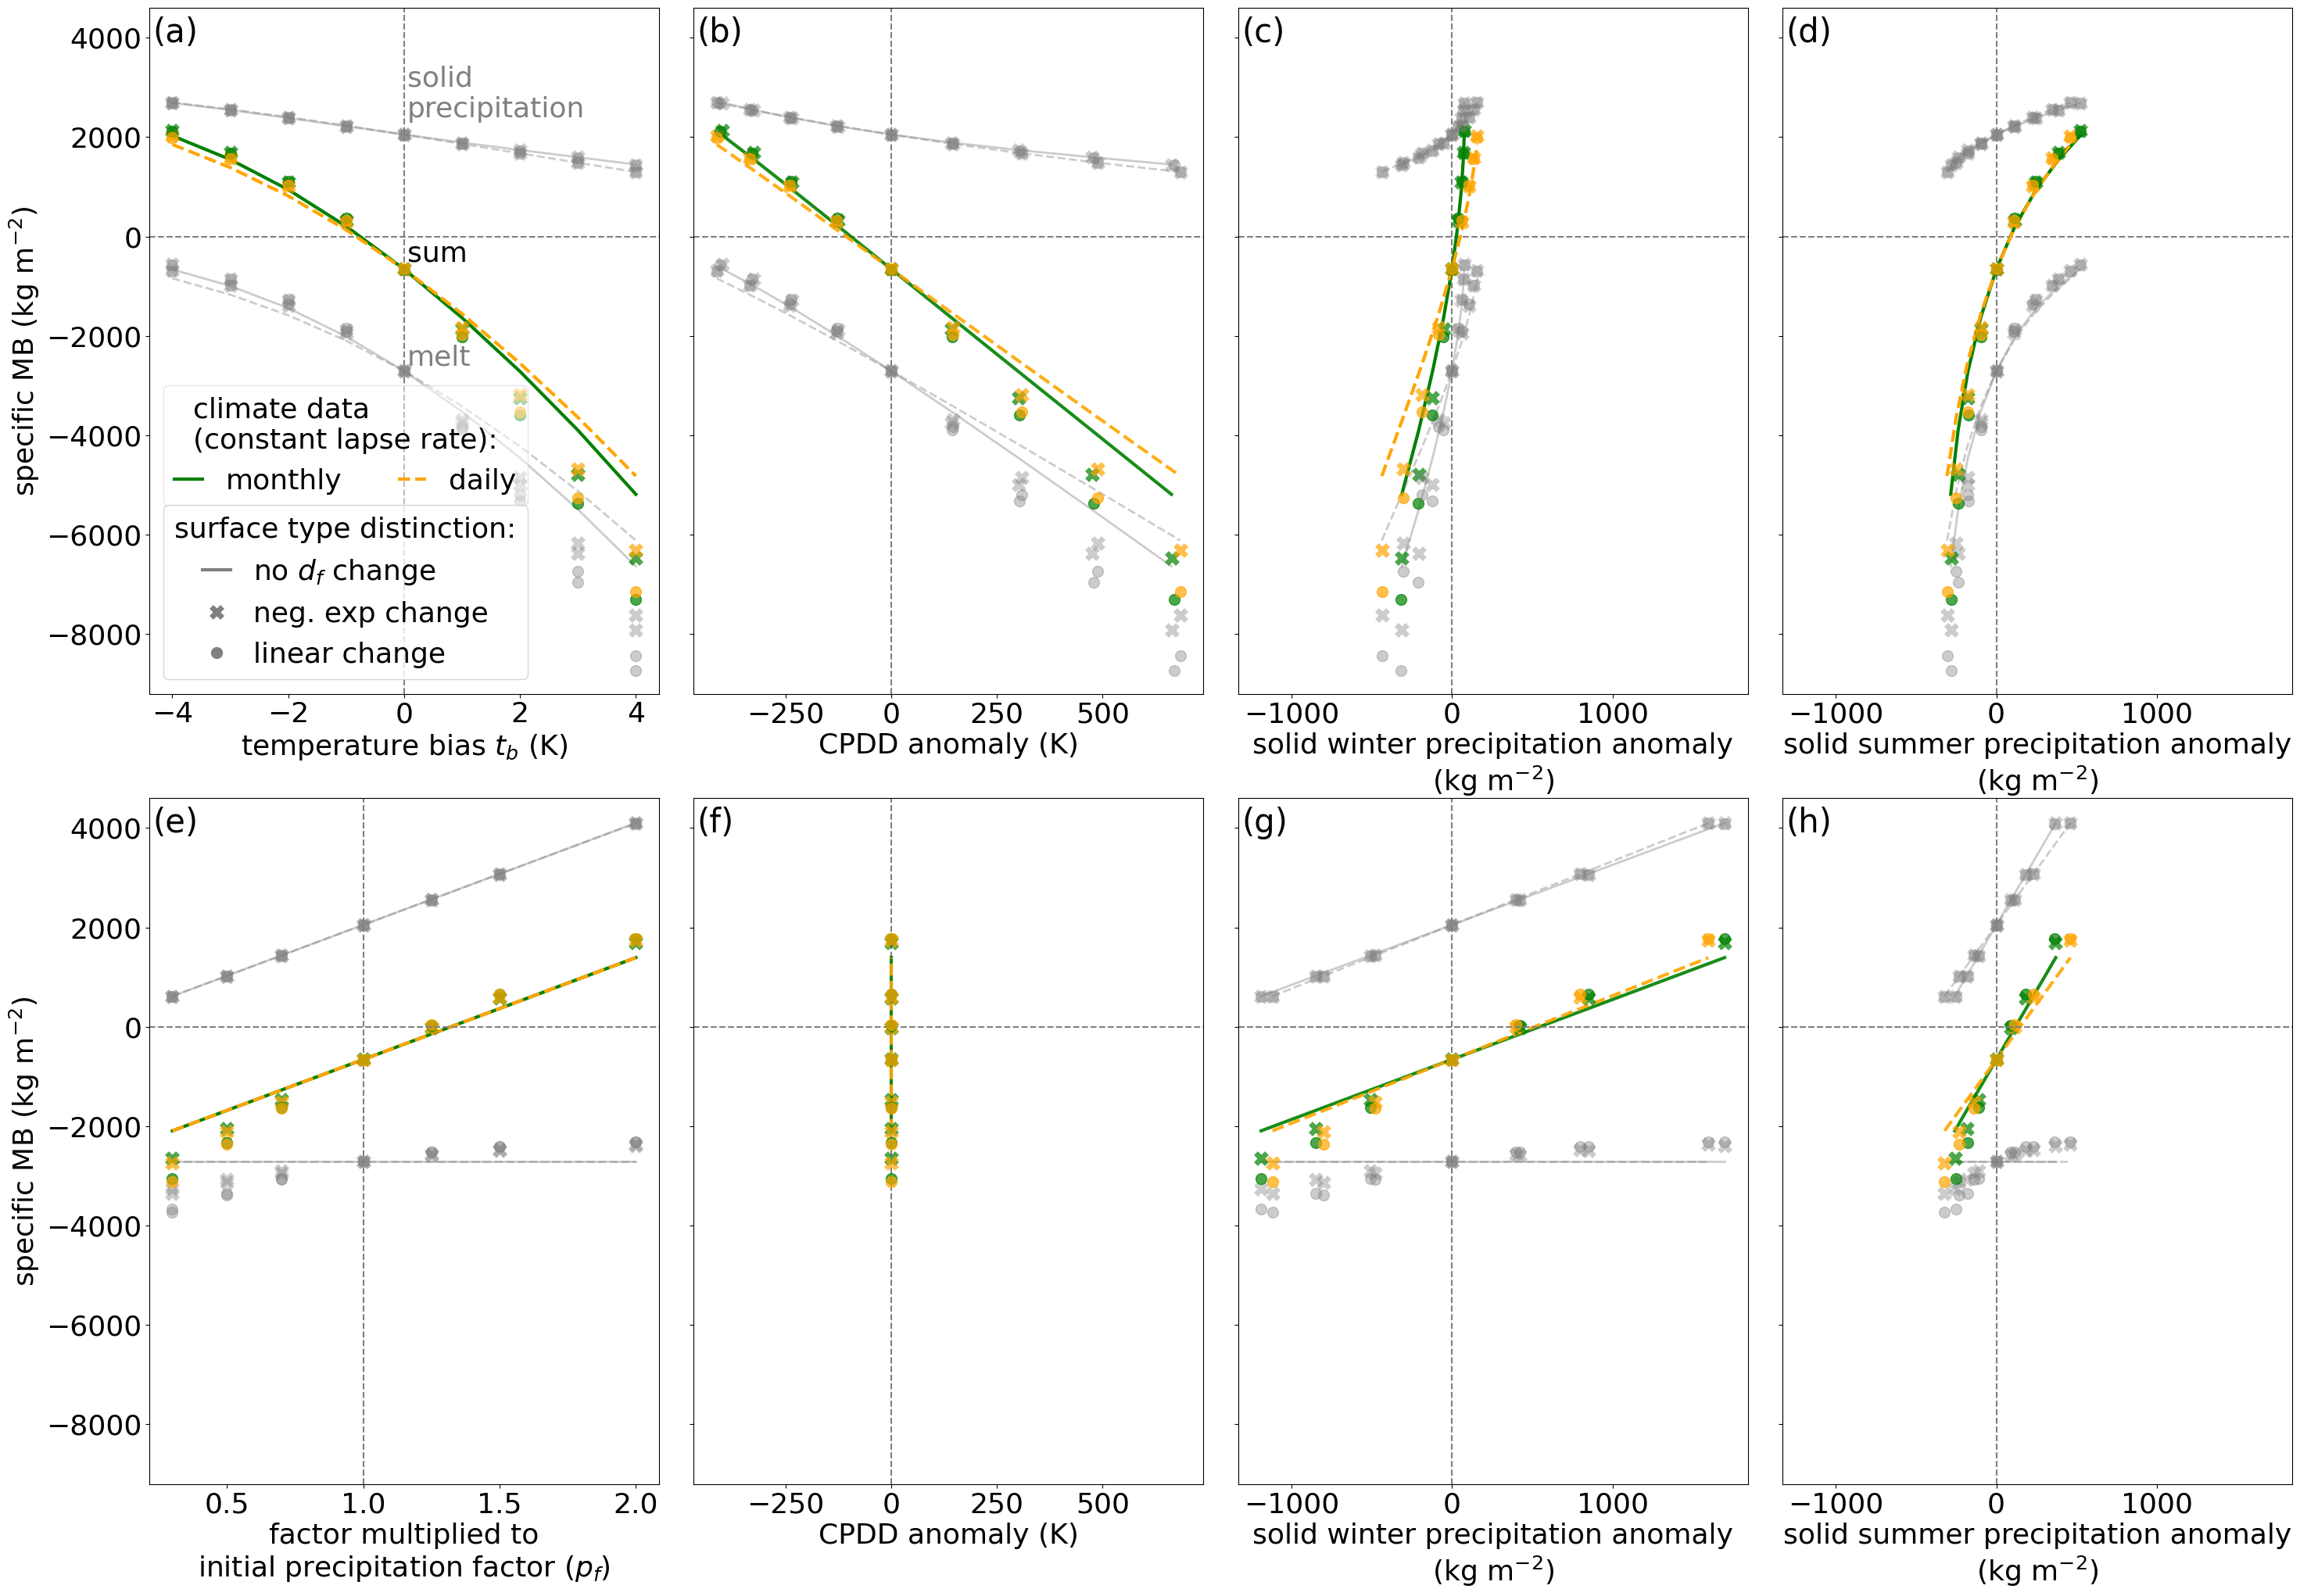

In [26]:

plt.rc('font', size=26) 
dynamical = False
time_span = 'all'
rgi = 'all'
only_simplest = False
grad_type='cte'
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=2, ncols=4,figsize=(30,21), sharey=True)
ylim = (-9200,4600)

fig.delaxes(axs[1][2])
xlims = (-1333.1442793442345, 1842.6261695394835)
plot_non_linearities_temp_bias(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                                   melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                    calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                    only_simplest=only_simplest,
                               ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                                  alpha_sfc_type=0.7, c=3, lw=3,
                               alpha_no_sfc_type=0.9,
                              dynamical=dynamical, time_span=time_span)

plot_non_linearities_temp_bias_solid_prcp(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                          lw=3,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=only_simplest, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                                          #alpha_no_sfc_type=0.9,
                              alpha_sfc_type=0.7,dynamical=dynamical,time_span=time_span,ylim=ylim,
                                         xlim=xlims)

plot_non_linearities_prcp_fac(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                              calib_period_avg=True, anomaly =False, 
                         calib_type = calib_type, only_simplest=only_simplest, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.7,
                              grad_type = grad_type,
                               me_sfc_type=5, c=3,
                              alpha_no_sfc_type=0.9,
                              dynamical=dynamical, time_span=time_span,
                              ylim=ylim, lw=3,
                             )

axs[0][3].set_xlim(xlims)
axs[0][2].set_xlim(xlims) #(-400, 990))
axs[1][3].set_xlim(xlims) #(-400, 990))
axs[1][1].set_xlim(axs[0][1].get_xlim()) #(-400, 990))

plt.tight_layout(h_pad=0.01)    
#fig.delaxes(axs[1][1])

plt.savefig(f'{fig_path}/fig_4_advanced_climate_sensitivity_nonlinearities_3.pdf')

depending on how the anomaly occurs, specific MB changes differently depending on what kind of solid precipitation anomaly occurs:


**actually, I am wondering, if in the future, it is not rather a solid precipitation anomaly induced by a changing temperature than by a changing total precipitation amount**

- if precipitation amount is the same and only the ratio between solid and liquid prcp is changed, 
    - in general, 
        - in the extreme case, all precipitation is solid and an even colder t_bias will not result in any larger MB, but also, solid winter prcp. can not get larger than a specific value (explains the positive solid winter prcp. anomaly part)
        - in the extreme warm case, all precipitation is liquid and an even warmer t_bias will not result in any more negative solid winter prcp, but it will still result in more negative MB (explains the negative solid wummer prcp. anomaly part)
        
        
    - the larger the winter prcp. the larger is the sensitivity to the MB (even for the "linear" TI-model)
        - why? More solid winter prcp occurs for smaller temperatures. As in that case, the smaller temperatures will get below the temperature threshold -> we get into non-linearities ... 
        - with different surface types, less solid winter prcp. results in more melt (this reduces a bit the "non-linearity")
    - the larger the summer prcp. the smaller is the sensitivity to the MB (even for the "linear" TI-model)
        - Why? More MB changes occur for only small decreases in solid summer prcp, as already almost all summer prcp is liquid, and the actual "driver" of the SMB is the increased CPDD in these cases ... 

---

## Analysis and figures that did not made it into the manuscript or supplements:


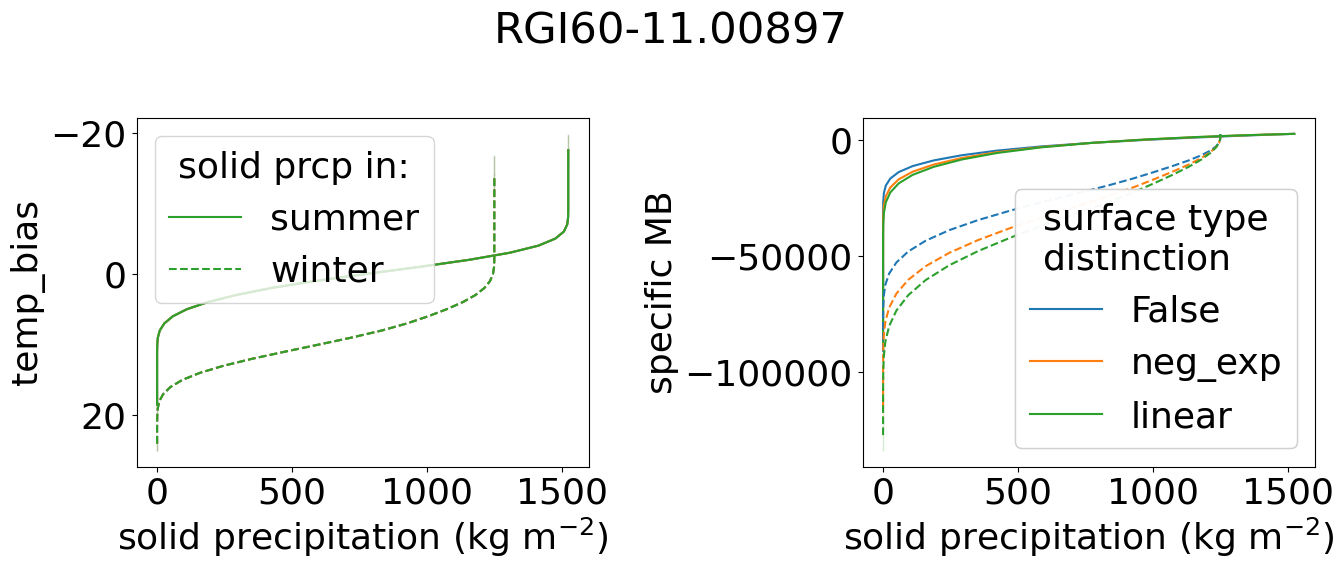

In [27]:
pathi = f'{data_path}/additional/temp_sensitivity_extreme_calib_only_geod_temp_b_0_pf_fit_via_winter_mb_mb_monthly_cte_all_ti_models.csv'

pd_t = pd.read_csv(pathi)

pd_concept_sensitivity = pd_t.groupby(['temp_bias', 'sfc_type']).mean().reset_index()
hue_order = ['False', 'neg_exp', 'linear']
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.lineplot(x='solid summer prcp', y='temp_bias',
             data=pd_concept_sensitivity,
             hue='sfc_type', hue_order=hue_order)
sns.lineplot(x='solid winter prcp', y='temp_bias',
             data=pd_concept_sensitivity,
             hue='sfc_type', ls='--', hue_order=hue_order)
handles, labels = plt.gca().get_legend_handles_labels()
handles[5].set_linestyle('--')
plt.xlabel(r'solid precipitation (kg m$^{-2}$)')
plt.gca().invert_yaxis()
plt.legend(handles[2::3], ['summer', 'winter'], title = 'solid prcp in:') #, loc = 'lower center')


plt.subplot(122)
sns.lineplot(x='solid summer prcp', y='spec_mb', data=pd_concept_sensitivity,
             hue='sfc_type', hue_order=hue_order)
sns.lineplot(x='solid winter prcp', y='spec_mb', data=pd_concept_sensitivity,
             hue='sfc_type', ls = '--', hue_order=hue_order)
#sns.lineplot(x='solid annual prcp', y='spec_mb', data=pd_concept_sensitivity,
 #            hue='sfc_type', ls = ':')
plt.ylabel('specific MB')
plt.xlabel(r'solid precipitation (kg m$^{-2}$)')
leg0 = plt.legend(handles[:3], labels[:3], title = 'surface type\ndistinction')
plt.gca().add_artist(leg0)
plt.suptitle(pd_t.rgi_id.unique()[0])

plt.tight_layout()

#rgi_id = 'RGI60-11.00289'
#pd_t = pd_t.loc[(pd_t.rgi_id == rgi_id)]

#### Dynamical run temperature sensitivities

In [ ]:
- todo: from here on the plots are unsorted and the code does not run!

In [5]:
############# dynamical run ... #######################
### dynamical non-linearities included with topographical feedback:
# do I need store_monthly_hydro=True ?!
# todo: actually need to start projection hydro in 2019 (as the historical missed it ?)
# or just drop it and we will average over it anyways???
import xarray as xr
from MBsandbox.flowline_TIModel import run_from_climate_data_TIModel
cfg.PARAMS['continue_on_error'] = False
pd_ref = pd.DataFrame(ref_candidates)
#gdirs_hef = [gdirs[pd_ref.loc[pd_ref[0] == 'RGI60-11.00897'].index.values[0]]]
gdirs_aletsch = [gdirs[pd_ref.loc[pd_ref[0] == 'RGI60-11.00897'].index.values[0]]]

cfg.PARAMS['mp_processes'] = 7
melt_f_update = 'monthly'
load = False
if load:
    for calib_type in [calib_types[-1]]:
        for mb_type in ['mb_monthly',  'mb_real_daily']: #'mb_pseudo_daily',
            if mb_type == 'mb_real_daily':
                temp_resol = 'daily'
            else:
                temp_resol = 'monthly'
            for grad_type in ['cte']: #, 'var_an_cycle']:
                mb_type_l = []
                prcpsol_l = []
                grad_type_l = []
                prcpsol_w_l = []
                prcpsol_s_l = []
                cpdd_s_l = []
                cpdd_w_l = []
                cpdd_l = []
                spec_mb_w_l=[]
                spec_mb_s_l=[]
                spec_mb_l = []
                temp_bias_l = []
                sfc_type_l = []
                gdir_l = []
                ssp_l = []
                pf_l = []
                pf_l_calib = []
                melt_f_update_l = []
                melt_f_change_l = []
                y_l = [] 
                
                for sfc_type in ['False', 'neg_exp', 'linear']: #, 'linear_annual',
                        if 'annual' in sfc_type:
                            melt_f_update = 'annual'
                        else:
                            melt_f_update = 'monthly'
                        if 'linear' in sfc_type:
                            melt_f_change = 'linear'
                        elif 'neg_exp' in sfc_type:
                            melt_f_change = 'neg_exp'
                        else:
                            melt_f_change = 'False'
                            melt_f_update = 'False'

                        if mb_type == 'mb_real_daily':
                            fac = 1 #12/365.25
                        else:
                            #fac = 365.25/30 
                            fac = 365.25/12
                        if sfc_type=='False':
                            mb_model_sub_class = TIModel #TIModel_Sfc_Type
                            kwargs_for_TIModel_Sfc_Type = {}
                        else:
                            mb_model_sub_class = TIModel_Sfc_Type
                            kwargs_for_TIModel_Sfc_Type={'melt_f_change': melt_f_change,
                                                         'melt_f_update': melt_f_update,
                                                         'tau_e_fold_yr':1}

                        for gdir in gdirs: #gdirs_aletsch: #gdirs_sel:
                            try:
                                json_filename = calib_type
                                from_json = True
                                # get the apparent_mb (necessary for inversion)
                                ye = 2020
                                residual = 0
                                if from_json:
                                    if melt_f_change!='False':
                                        if kwargs_for_TIModel_Sfc_Type['melt_f_update'] == 'annual':
                                            fs_new = '_{}_sfc_type_{}_annual_{}_{}'.format('W5E5', melt_f_change, mb_type, grad_type)
                                        else:
                                            fs_new = '_{}_sfc_type_{}_{}_{}'.format('W5E5', melt_f_change, mb_type, grad_type)
                                    else:
                                        fs_new = '_{}_sfc_type_{}_{}_{}'.format('W5E5', melt_f_change, mb_type, grad_type)
                                    # json_filename = 'melt_f_geod_opt_winter_mb_approx_std'
                                    # get the calibrated melt_f that suits to the prcp factor
                                    try:
                                        d = gdir.read_json(filename=json_filename,
                                                           filesuffix=fs_new)
                                        # get the corrected ref_hgt so that we can apply this again on the mb model
                                        # if otherwise not melt_f could be found!
                                        pf = d['pf']
                                        melt_f = d['melt_f']
                                        temp_bias = d['temp_bias']
                                    except:
                                        raise InvalidWorkflowError(
                                            'there is no calibrated melt_f for this precipitation factor, glacier, climate'
                                            'mb_type and grad_type, need to do the calibration first!')


                                gd_mb = mb_model_sub_class(gdir, None, mb_type=mb_type,
                                                        grad_type=grad_type,
                                                        baseline_climate=climate_type, residual=residual,
                                                        **kwargs_for_TIModel_Sfc_Type)
                                gd_mb.melt_f = melt_f
                                gd_mb.prcp_fac = pf
                                gd_mb.temp_bias = temp_bias

                                oggm.core.climate.apparent_mb_from_any_mb(gdir, mb_model=gd_mb,
                                                                mb_years=np.arange(2004, ye, 1))
                                # here glen-a is calibrated to match gdirs glaciers in total (as there is only one glacier, it just matches perfectly the one glacier!)
                                border = 80
                                filter = border >= 20
                                pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus([gdir],
                                                                                      apply_fs_on_mismatch=False,
                                                                                                 ignore_missing=False,
                                                                                      error_on_mismatch=True,
                                                                                      filter_inversion_output=filter) 

                                # so for init_present_time_glacier, automatically the new glen a volume inversion is used!
                                workflow.execute_entity_task(tasks.init_present_time_glacier, [gdir]) #gdirs_sel)
                                y0 = gdir.get_climate_info('_daily_W5E5')['baseline_hydro_yr_0']
                                # One adds 1 because the run ends at the end of the year
                                ye = gdir.get_climate_info('_daily_W5E5')['baseline_hydro_yr_1'] + 1

                                # here get the flowline diagnostic information
                                _,w = gdir.get_inversion_flowline_hw()

                                pf_mul = 1.0
                                gd_mb.prcp_fac = pf*pf_mul
                                for temp_bias in np.arange(-1, 5.1, 1):
                                        #try:
                                        gd_mb.temp_bias = temp_bias

                                        fs = f'sens_t_dyn_hist_W5E5_{calib_type}_{mb_type}_{grad_type}_{melt_f_change}_{melt_f_update}_{str(temp_bias)}_{str(pf_mul)}'
                                    
                                        run_from_climate_data_TIModel(gdir, #run_task=run_from_climate_data_TIModel,
                                                                     bias=0,  # will actually point to the residual, should always be zero! 
                                                                     mb_model_sub_class=mb_model_sub_class, 
                                                                     # we use the temperature-index model variant with surface type distinction!
                                                                     min_ys=y0,
                                                                     ye=ye,  # starting and end year of the volume run 
                                                                     mb_type=mb_type,
                                                                     grad_type=grad_type,
                                                                     #init_model_filesuffix = '_historical_run',  
                                                                     # start from the stage of the end of the historical run 
                                                                     #climate_type = 'gcm_data',
                                                                     kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                                                     climate_filename='climate_historical',
                                                                     output_filesuffix=fs,
                                                                     climate_input_filesuffix='W5E5', 
                                                                     store_model_geometry = True,
                                                                     all_from_json=False,
                                                                     melt_f = gd_mb.melt_f,
                                                                     precipitation_factor = gd_mb.prcp_fac,
                                                                     temperature_bias = gd_mb.temp_bias,
                                                                     json_filename=calib_type,
                                                                     store_fl_diagnostics=True,
                                                                     no_qc=True)
                                        f = gdir.get_filepath('fl_diagnostics', filesuffix=fs)
                                        with xr.open_dataset(f) as ds:
                                            fl_ids = ds.flowlines.data
                                        with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as ds:
                                            ds = ds.load()
                                            bed_h = ds['bed_h']
                                        if ds.area_m2.isel(time=-1).max() == 0:
                                            pass
                                        else:
                                            if melt_f_change != 'False':
                                                fls = gdir.read_pickle('model_flowlines') #, filesuffix=fs)
                                                gd_mb.reset_pd_mb_bucket(init_model_fls=fls)
                                            for y in np.arange(2004,2020,1):

                                                thick = ds['thickness_m'].loc[{'time': y}].values
                                                # this is the bin area along the flowline
                                                area = ds['area_m2'].loc[{'time': y}].values
                                                ### if it fails for one year, let it fail for all years 
                                                # (e.g. because glacier got zero in 2019 already)
                                                #if np.all(area==0):
                                                #    # glacier is gone
                                                #    pass
                                                #else:
                                                

                                                mb, temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  add_climate=True,
                                                                                                                  fl_id=fl_ids[-1])

                                                # seasonal stuff would need some rethinking about the changing widths , .... 
                                                # seasonal stuff does not work for annual melt_f_update
                                                if melt_f_update != 'annual':
                                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = gd_mb.get_specific_winter_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  widths=area,
                                                                                                                  add_climate=True,
                                                                                                                  fl_id=fl_ids[-1])
                                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = gd_mb.get_specific_summer_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  add_climate=True,
                                                                                                                  widths=area,
                                                                                                                  fl_id=fl_ids[-1])
                                                    #wi = w.copy()
                                                    # experimental
                                                    wi = area.copy()
                                                else:
                                                    # todo set them NaN
                                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = np.repeat(np.NaN, 5)
                                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = np.repeat(np.NaN, 5)
                                                    wi = np.NaN

                                                # if area == 0, this will fail!!!
                                                prcpsol_l.append(np.average(prcpsol, weights=area))
                                                cpdd_l.append(np.average(tempformelt, weights=area)*fac)
                                                spec_mb_l.append(np.average(mb*cfg.PARAMS['ice_density']*gd_mb.SEC_IN_YEAR, weights=area))
                                                temp_bias_l.append(temp_bias)
                                                y_l.append(y)
                                                sfc_type_l.append(sfc_type)
                                                mb_type_l.append(mb_type)
                                                #ssp_l.append(ssp)
                                                gdir_l.append(gdir.rgi_id)
                                                pf_l.append(pf*pf_mul)
                                                pf_l_calib.append(pf)
                                                melt_f_update_l.append(melt_f_update)
                                                melt_f_change_l.append(melt_f_change)
                                                grad_type_l.append(grad_type)


                                                spec_mb_w_l.append(mb_w)
                                                spec_mb_s_l.append(mb_s)
                                                prcpsol_w_l.append(np.average(prcpsol_w, weights=wi))
                                                prcpsol_s_l.append(np.average(prcpsol_s, weights=wi))
                                                cpdd_w_l.append(np.average(tempformelt_w, weights=wi)*fac)
                                                cpdd_s_l.append(np.average(tempformelt_s, weights=wi)*fac)
                                        #except:
                                        #pass
                                    
                                    
                                temp_bias = 0.0
                                gd_mb.temp_bias = temp_bias
                                for pf_mul in np.array([0.1, 0.2, 0.3, 0.5,0.7,1.25, 1.5, 2,3, 4]): #,8,9,10]):
                                    try:
                                        gd_mb.prcp_fac = pf*pf_mul
                                        fs = f'sens_p_dyn_hist_W5E5_{calib_type}_{mb_type}_{grad_type}_{melt_f_change}_{melt_f_update}_{str(temp_bias)}_{str(pf_mul)}'
                                    
                                        run_from_climate_data_TIModel(gdir, #run_task=run_from_climate_data_TIModel,
                                                                     bias=0,  # will actually point to the residual, should always be zero! 
                                                                     mb_model_sub_class=mb_model_sub_class, 
                                                                     # we use the temperature-index model variant with surface type distinction!
                                                                     min_ys=y0,
                                                                     ye=ye,  # starting and end year of the volume run 
                                                                     mb_type=mb_type,
                                                                     grad_type=grad_type,
                                                                     #init_model_filesuffix = '_historical_run',  
                                                                     # start from the stage of the end of the historical run 
                                                                     #climate_type = 'gcm_data',
                                                                     kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                                                     climate_filename='climate_historical',
                                                                     output_filesuffix=fs,
                                                                     climate_input_filesuffix='W5E5', 
                                                                     store_model_geometry = True,
                                                                     all_from_json=False,
                                                                     melt_f = gd_mb.melt_f,
                                                                     precipitation_factor = gd_mb.prcp_fac,
                                                                     temperature_bias = gd_mb.temp_bias,
                                                                     json_filename=calib_type,
                                                                     store_fl_diagnostics=True,
                                                                     no_qc=True)
                                        f = gdir.get_filepath('fl_diagnostics', filesuffix=fs)
                                        with xr.open_dataset(f) as ds:
                                            fl_ids = ds.flowlines.data
                                        with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as ds:
                                            ds = ds.load()
                                            bed_h = ds['bed_h']
                                        if ds.area_m2.isel(time=-1).max() == 0:
                                            pass
                                        else:
                                            if melt_f_change != 'False':
                                                fls = gdir.read_pickle('model_flowlines')
                                                gd_mb.reset_pd_mb_bucket(init_model_fls=fls)
                                            for y in np.arange(2004,2020,1):

                                                thick = ds['thickness_m'].loc[{'time': y}].values
                                                # this is the bin area along the flowline
                                                area = ds['area_m2'].loc[{'time': y}].values
                                                # if it fails for one year, let it fail for all years ...
                                                #if np.all(area==0):
                                                #    # glacier is gone
                                                #    pass
                                                #else:
                                                
                                                mb, temp, tempformelt, prcp, prcpsol = gd_mb.get_annual_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  add_climate=True,
                                                                                                                  fl_id=fl_ids[-1])

                                                # seasonal stuff would need some rethinking about the changing widths , .... 
                                                # seasonal stuff does not work for annual melt_f_update
                                                if melt_f_update != 'annual':
                                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = gd_mb.get_specific_winter_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  widths=area,
                                                                                                                  add_climate=True,
                                                                                                                  fl_id=fl_ids[-1])
                                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = gd_mb.get_specific_summer_mb(heights=bed_h + thick,
                                                                                                                  year=y,
                                                                                                                  add_climate=True,
                                                                                                                  widths=area,
                                                                                                                  fl_id=fl_ids[-1])
                                                    #wi = w.copy()
                                                    # experimental
                                                    wi = area.copy()
                                                else:
                                                    # todo set them NaN
                                                    mb_w, temp_w, tempformelt_w, prcp_w, prcpsol_w = np.repeat(np.NaN, 5)
                                                    mb_s, temp_s, tempformelt_s, prcp_s, prcpsol_s = np.repeat(np.NaN, 5)
                                                    wi = np.NaN


                                                prcpsol_l.append(np.average(prcpsol, weights=area))
                                                cpdd_l.append(np.average(tempformelt, weights=area)*fac)
                                                spec_mb_l.append(np.average(mb*cfg.PARAMS['ice_density']*gd_mb.SEC_IN_YEAR,
                                                                            weights=area))
                                                temp_bias_l.append(temp_bias)
                                                y_l.append(y)
                                                sfc_type_l.append(sfc_type)
                                                mb_type_l.append(mb_type)
                                                #ssp_l.append(ssp)
                                                gdir_l.append(gdir.rgi_id)
                                                pf_l.append(pf*pf_mul)
                                                pf_l_calib.append(pf)
                                                melt_f_update_l.append(melt_f_update)
                                                melt_f_change_l.append(melt_f_change)
                                                grad_type_l.append(grad_type)

                                                

                                                spec_mb_w_l.append(mb_w)
                                                spec_mb_s_l.append(mb_s)
                                                prcpsol_w_l.append(np.average(prcpsol_w, weights=wi))
                                                prcpsol_s_l.append(np.average(prcpsol_s, weights=wi))
                                                cpdd_w_l.append(np.average(tempformelt_w, weights=wi)*fac)
                                                cpdd_s_l.append(np.average(tempformelt_s, weights=wi)*fac)
                                    except:
                                        pass
                            except:
                                pass 
                                        
                pd_sensitivity_mb = pd.DataFrame(np.array([y_l, temp_bias_l, sfc_type_l, mb_type_l, cpdd_l, cpdd_w_l, cpdd_s_l,
                                                           prcpsol_l, prcpsol_w_l, prcpsol_s_l,
                                                           spec_mb_l, spec_mb_w_l, spec_mb_s_l, gdir_l, 
                                                           pf_l, pf_l_calib, melt_f_update_l, melt_f_change_l, grad_type_l]).T,
                                                  columns=['year', 'temp_bias','sfc_type', 'mb_type', 'CPDD', 'winter CPDD',
                                                           'summer CPDD', 'solid annual prcp',
                                                           'solid winter prcp', 'solid summer prcp', 'spec_mb', 'specific winter mb',
                                                           'specific summer mb', 'rgi_id',
                                                           'pf', 'pf_calib', 'melt_f_update', 'melt_f_change', 'grad_type'])
                columns_float = ['year', 'temp_bias', 'CPDD', 'winter CPDD', 'summer CPDD', 'solid annual prcp',
                                'solid winter prcp', 'solid summer prcp', 'spec_mb', 'specific winter mb', 'specific summer mb',
                                'pf', 'pf_calib']
                pd_sensitivity_mb[columns_float] = pd_sensitivity_mb[columns_float].astype(float)
                pd_sensitivity_mb['spec_mb_only_melt'] = pd_sensitivity_mb['spec_mb'] - pd_sensitivity_mb['solid annual prcp']
                pd_sensitivity_mb['winter_mb_only_melt'] = pd_sensitivity_mb['specific winter mb'] - pd_sensitivity_mb['solid winter prcp']
                pd_sensitivity_mb['summer_mb_only_melt'] = pd_sensitivity_mb['specific summer mb'] - pd_sensitivity_mb['solid summer prcp']
                pd_sensitivity_mb['pf_mul'] = (pd_sensitivity_mb['pf'] / pd_sensitivity_mb['pf_calib']).round(2)

                pd_sensitivity_mb.to_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_{mb_type}_{grad_type}_all_ti_models_dynamical.csv')
                print(f'{mb_type}_{grad_type}: done')
                
    rgi_w_l = []
    pd_sensitivity_mb_l = []
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']: #'mb_pseudo_daily',
        for grad_type in ['cte']: #, 'var_an_cycle']:
            _pd_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_{mb_type}_{grad_type}_all_ti_models_dynamical.csv',
                                 index_col = 'Unnamed: 0')
            #_pd_mb = _pd_mb.dropna()
            print(len(_pd_mb.rgi_id.unique()))
            rgi_w_l.append(list(_pd_mb.rgi_id.unique()))
            pd_sensitivity_mb_l.append(_pd_mb)
    pd_sensitivity_mb = pd.concat(pd_sensitivity_mb_l)   
    assert pd_sensitivity_mb['spec_mb_only_melt'].round(4).max() <= 0
    #assert pd_sensitivity_mb['winter_mb_only_melt'].round(2).max() <= 0
    #assert pd_sensitivity_mb['summer_mb_only_melt'].round(2).max() <= 0

    # check if for a single glacier, the specific MB average over 2000-2019 is everywhere the same
    t = pd_sensitivity_mb.loc[pd_sensitivity_mb.temp_bias == 0]
    t = t.loc[t.pf_mul==1]
    t = t.groupby(['mb_type', 'melt_f_update', 'melt_f_change', 'rgi_id']).mean()
    rgi_w_indexi = t.groupby('rgi_id').spec_mb.std().dropna()
    #rgi_w_indexi
    # if dynamic need a larger absolute tolerance!
    np.testing.assert_allclose(t.groupby('rgi_id').spec_mb.std().dropna(), 0, atol=70)
    # test if it is calibrated to the right geodetic estimates!
    test_spec_mb_mean = t.groupby('rgi_id').spec_mb.mean()
    geod = pd_geodetic.loc[test_spec_mb_mean.index].dmdtda*1000
    # as it is now the dynamic stuff, it won't work anymore 
    np.testing.assert_allclose(test_spec_mb_mean,
                               geod, atol=250)

    # a bit stupid, but here I just select those glaciers that actually 
    rgi_w_all = list(set(rgi_w_l[0]).intersection(rgi_w_l[1]).intersection(rgi_w_l[2])) #.intersection(rgi_w_l[3]).intersection(rgi_w_l[4]).intersection(rgi_w_l[5]))
    for r in pd_sensitivity_mb.rgi_id.unique():
        if r not in rgi_w_all:
            pd_sensitivity_mb = pd_sensitivity_mb.where(pd_sensitivity_mb.rgi_id != r).dropna()
    pd_sensitivity_mb.to_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_all_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv')
        
    
else:
    pd_sensitivity_mb_dyn = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_all_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv', index_col=[0])

2022-12-06 12:46:44: oggm.cfg: PARAMS['continue_on_error'] changed from `True` to `False`.
2022-12-06 12:46:44: oggm.cfg: Multiprocessing: using the requested number of processors (N=7)


In [6]:
pd_sensitivity_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv',
                                        index_col=[0])
stat = pd_sensitivity_mb.loc[(pd_sensitivity_mb.grad_type == 'cte')]
stat = stat.loc[(stat.rgi_id=='RGI60-11.01450')]
stat = stat.loc[(stat.year>=2004)]
pd_sensitivity_mb_dyn = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv',
                                   index_col=[0])

dyn = pd_sensitivity_mb_dyn.loc[(pd_sensitivity_mb_dyn.grad_type == 'cte')]

In [17]:
stat_sel = stat.groupby(['temp_bias','sfc_type','mb_type']).mean().reset_index()
stat_sel = stat_sel.loc[(stat_sel.mb_type=='mb_monthly')&(stat_sel.sfc_type=='False')]

/tmp/ipykernel_161177/2612757476.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stat_sel = stat.groupby(['temp_bias','sfc_type','mb_type']).mean().reset_index()


In [ ]:
plt.plot(stat_sel['solid winter prcp'], stat_sel['specific winter mb'],'.')

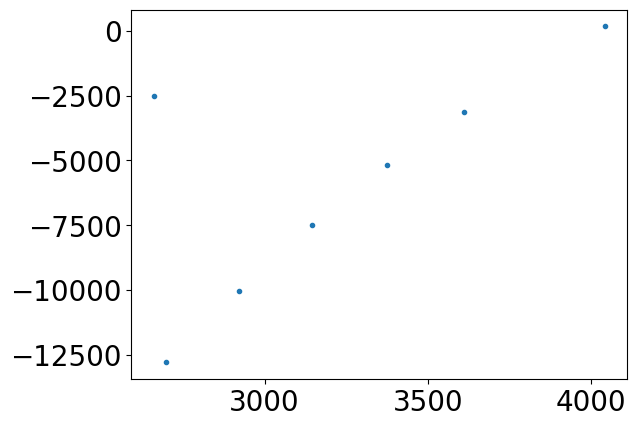

In [33]:
plt.plot(stat_sel['solid annual prcp'], stat_sel['spec_mb'],'.')

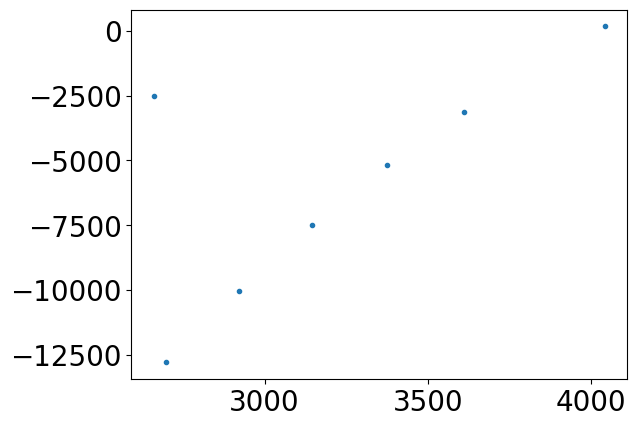

In [41]:
plt.plot(stat_sel['solid annual prcp'], stat_sel['spec_mb'],'.')


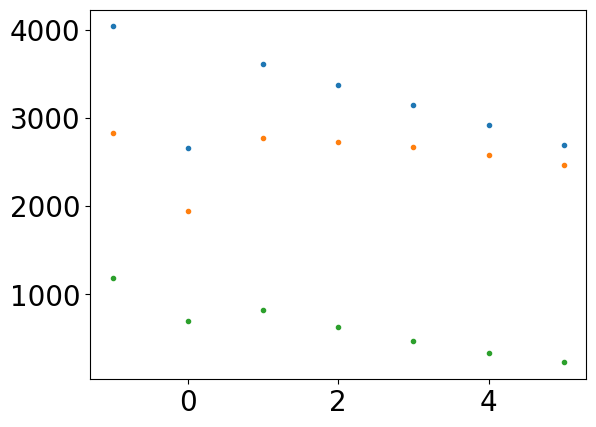

In [40]:
plt.plot(stat_sel['temp_bias'], stat_sel['solid annual prcp'],'.')
plt.plot(stat_sel['temp_bias'], stat_sel['solid winter prcp'],'.')
plt.plot(stat_sel['temp_bias'], stat_sel['solid summer prcp'],'.')

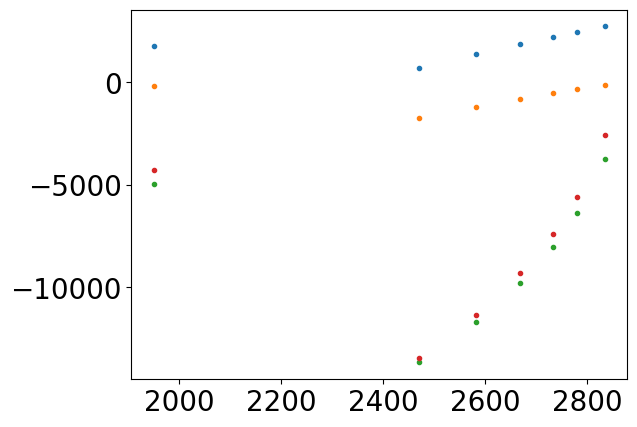

In [32]:
plt.plot(stat_sel['solid winter prcp'], stat_sel['specific winter mb'],'.')
plt.plot(stat_sel['solid winter prcp'], stat_sel['winter_mb_only_melt'],'.')

plt.plot(stat_sel['solid winter prcp'], stat_sel['summer_mb_only_melt'],'.')
plt.plot(stat_sel['solid winter prcp'], stat_sel['specific summer mb'],'.')


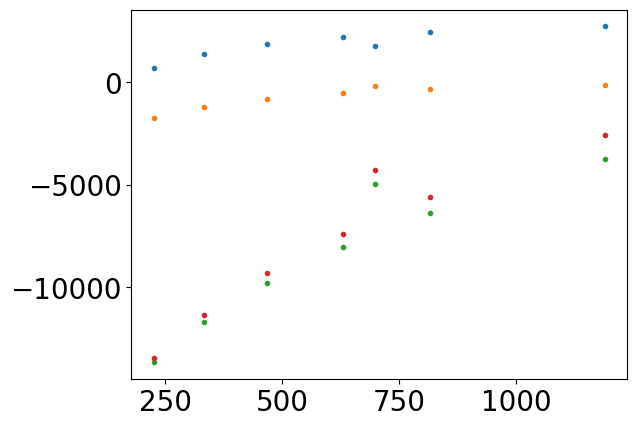

In [34]:
plt.plot(stat_sel['solid summer prcp'], stat_sel['specific winter mb'],'.')
plt.plot(stat_sel['solid summer prcp'], stat_sel['winter_mb_only_melt'],'.')

plt.plot(stat_sel['solid summer prcp'], stat_sel['summer_mb_only_melt'],'.')
plt.plot(stat_sel['solid summer prcp'], stat_sel['specific summer mb'],'.')


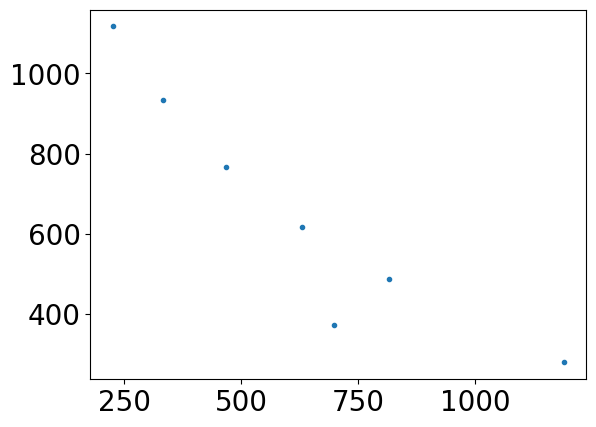

In [36]:
plt.plot(stat_sel['solid summer prcp'], stat_sel['CPDD'],'.')

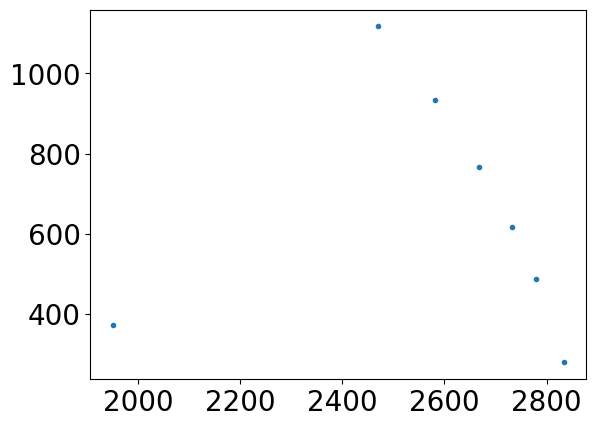

In [35]:
plt.plot(stat_sel['solid winter prcp'], stat_sel['CPDD'],'.')

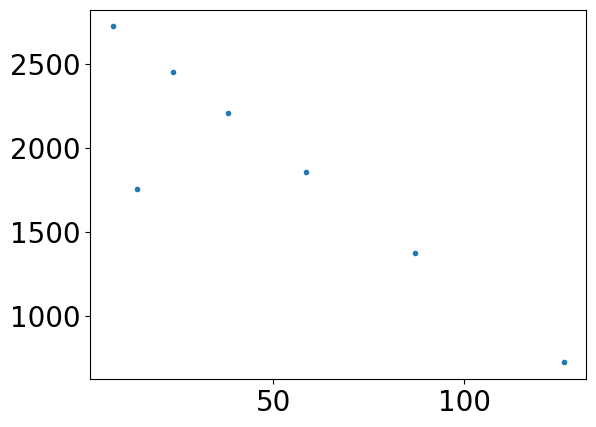

In [18]:
plt.plot(stat_sel['winter CPDD'], stat_sel['specific winter mb'],'.')

In [7]:
stat = stat.loc[(stat.pf_mul<=dyn.pf_mul.unique().max())]
stat = stat.loc[(stat.temp_bias<=dyn.temp_bias.unique().max())]
stat = stat.loc[(stat.temp_bias>=dyn.temp_bias.unique().min())]


In [8]:
stat_0 = stat.loc[(stat.temp_bias==0)]
stat_0 = stat_0.loc[(stat_0.pf_mul==1)]
#stat_0 = stat_0.loc[(stat_0.year==2019)]
dyn_0 = dyn.loc[(dyn.temp_bias==0)]
dyn_0 = dyn_0.loc[(dyn_0.pf_mul==1)]
#dyn_0 = dyn_0.loc[(dyn_0.year==2019)]

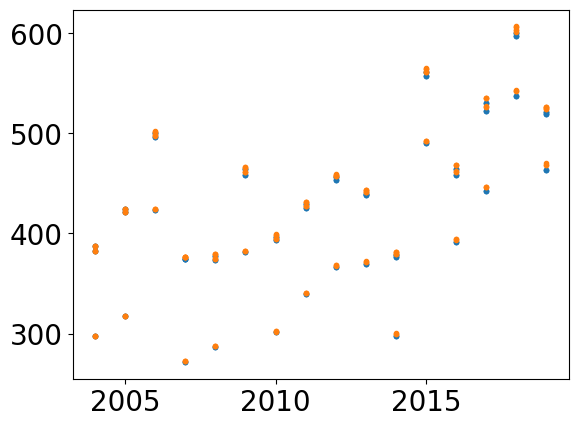

In [9]:
plt.plot(stat_0.year, stat_0.CPDD, '.')
plt.plot(dyn_0.year, dyn_0.CPDD, '.')

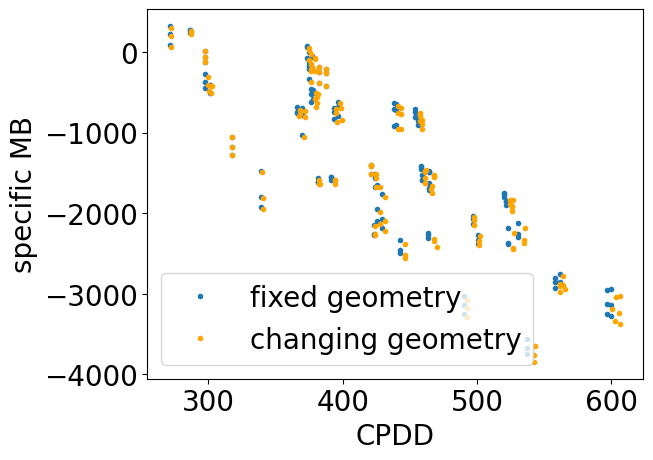

In [10]:
plt.plot(stat_0.CPDD,stat_0.spec_mb,'.', label='fixed geometry')
plt.plot(dyn_0.CPDD, dyn_0.spec_mb,'.', color='orange', label='changing geometry')
plt.xlabel('CPDD')
plt.ylabel('specific MB')
plt.legend()

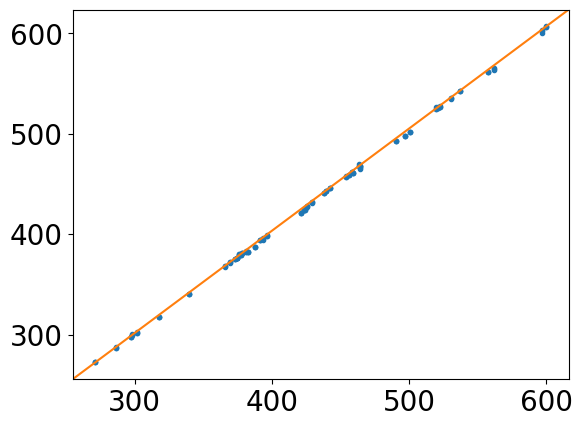

In [499]:
plt.plot(stat_0.CPDD,dyn_0.CPDD,'.')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)

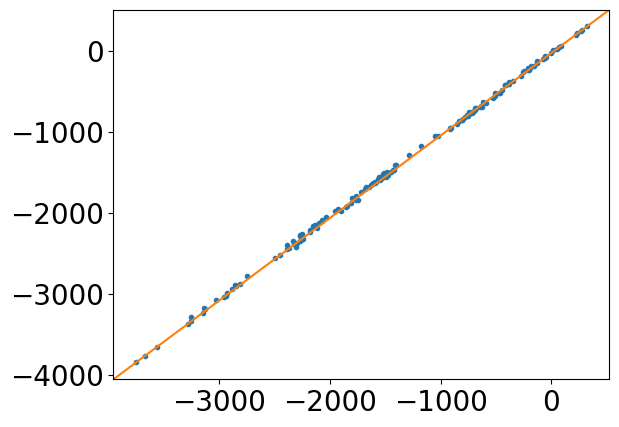

In [500]:
plt.plot(stat_0.spec_mb,dyn_0.spec_mb,'.')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)

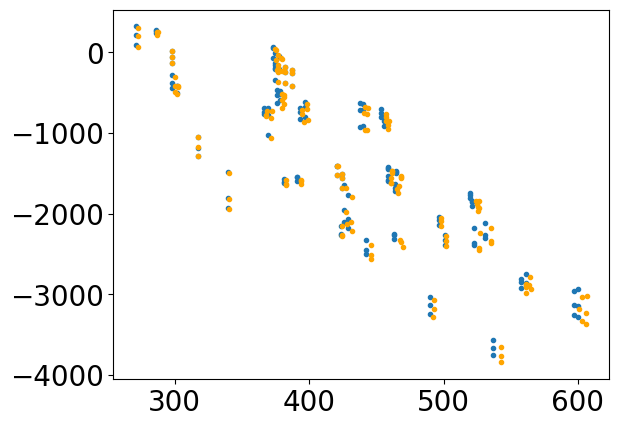

In [501]:
plt.plot(stat_0.CPDD,stat_0.spec_mb,'.')
plt.plot(dyn_0.CPDD, dyn_0.spec_mb,'.', color='orange')

In [320]:
stat.temp_bias.unique()

array([-2., -1.,  0.,  1.,  2.,  3.,  4.])

In [418]:
dyn.temp_bias.unique()

array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,
       -1.5])

In [317]:
np.shape(dyn)

(2592, 23)

In [316]:
np.shape(stat)

(2160, 23)

In [7]:
pd_sensitivity_mb_mean = pd_sensitivity_mb.groupby(['mb_type', 'sfc_type', 'temp_bias', 'pf_mul']).mean()
pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean['pf_mul'].round(2) == 1]
sensitivity = 'varying_temp_bias_prcp_fac'
rgi = 'all'

/tmp/ipykernel_175908/915220147.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb.groupby(['mb_type', 'sfc_type', 'temp_bias', 'pf_mul']).mean()


In [8]:
pd_sensitivity_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_types[-1]}_cte.csv', index_col = 'Unnamed: 0')
pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[pd_sensitivity_mb['pf_mul'].round(2) == 1]

pd_sensitivity_mb_sel = pd_sensitivity_mb_sel.loc[pd_sensitivity_mb_sel.rgi_id == gdirs[20].rgi_id]
print(len(pd_sensitivity_mb_sel.rgi_id.unique()))
if sensitivity == 'varying_temp_bias_prcp_fac':
        pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.reset_index()
pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.mb_type == 'mb_monthly']
pd_sensitivity_mb_mean = pd_sensitivity_mb_mean.loc[pd_sensitivity_mb_mean.sfc_type == 'False']

NameError: name 'gdirs' is not defined

In [23]:
pd_sensitivity_mb = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/non_linear_analysis_ref_years_{calib_type}.csv',
                                        index_col = 'Unnamed: 0')
pd_sensitivity_mb = pd_sensitivity_mb.loc[pd_sensitivity_mb.ssp == 'ssp585']

In [7]:
fig_path = '/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/figures_paper_oct_2022'


/tmp/ipykernel_3275/1542571978.py:94: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['year','sfc_type', 'mb_type']).mean()


[<matplotlib.lines.Line2D object at 0x7f2e50ec2f10>, <matplotlib.lines.Line2D object at 0x7f2e50dccf40>, <matplotlib.lines.Line2D object at 0x7f2e513cf040>, <matplotlib.lines.Line2D object at 0x7f2e50dac640>] ['mb_monthly', 'mb_real_daily', 'mb_monthly', 'mb_real_daily']
['monthly', 'daily', 'monthly', 'daily']
['monthly', 'daily', 'monthly', 'daily']
91 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
91
91 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_3275/2871530394.py:81: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['year','sfc_type', 'mb_type']).mean()


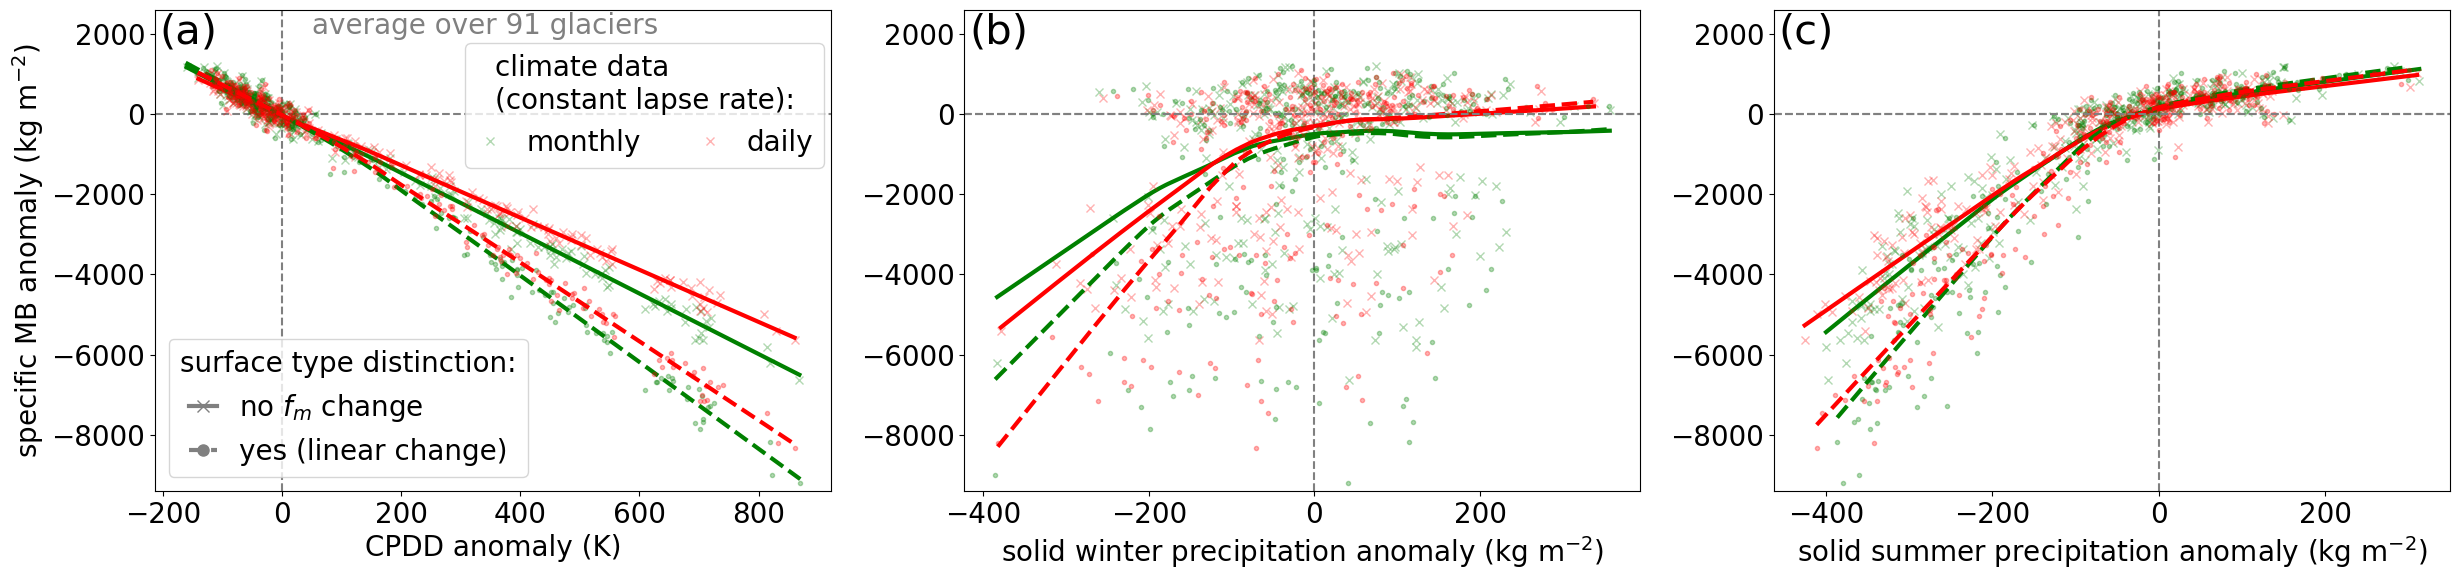

In [140]:
sensitivity = 'varying_years_ssp585'
anomaly = True
rgi = 'all'
grad_type='cte'
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(rgi=rgi, sensitivity=sensitivity,
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = anomaly,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 3, me_sfc_type=3, grad_type=grad_type,
                              alpha_sfc_type=0.3, alpha_no_sfc_type=0.3)
axs[0].set_ylim([-9400,2600])

plot_non_linearities_prcp_fac(rgi=rgi, sensitivity=sensitivity, melt_f_update = 'monthly', 
                              calib_period_avg=True, anomaly =anomaly, 
                         calib_type = calib_type, only_simplest=True, ms_sfc_type = 3, #xs=axs
                              alpha_sfc_type=0.3, alpha_no_sfc_type=0.3,
                              grad_type = grad_type,
                               me_sfc_type=3,
                              ylim=axs[0].get_ylim()
                             )
axs[1].set_ylabel('')
plt.tight_layout()
plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_1850_2100_ssp585_{grad_type}.png')

- each dot corresponds to one year (hence in total 250 dots)
- anomaly is relative to 1979-2014


/tmp/ipykernel_119124/940251898.py:84: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217
217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_119124/1171522957.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


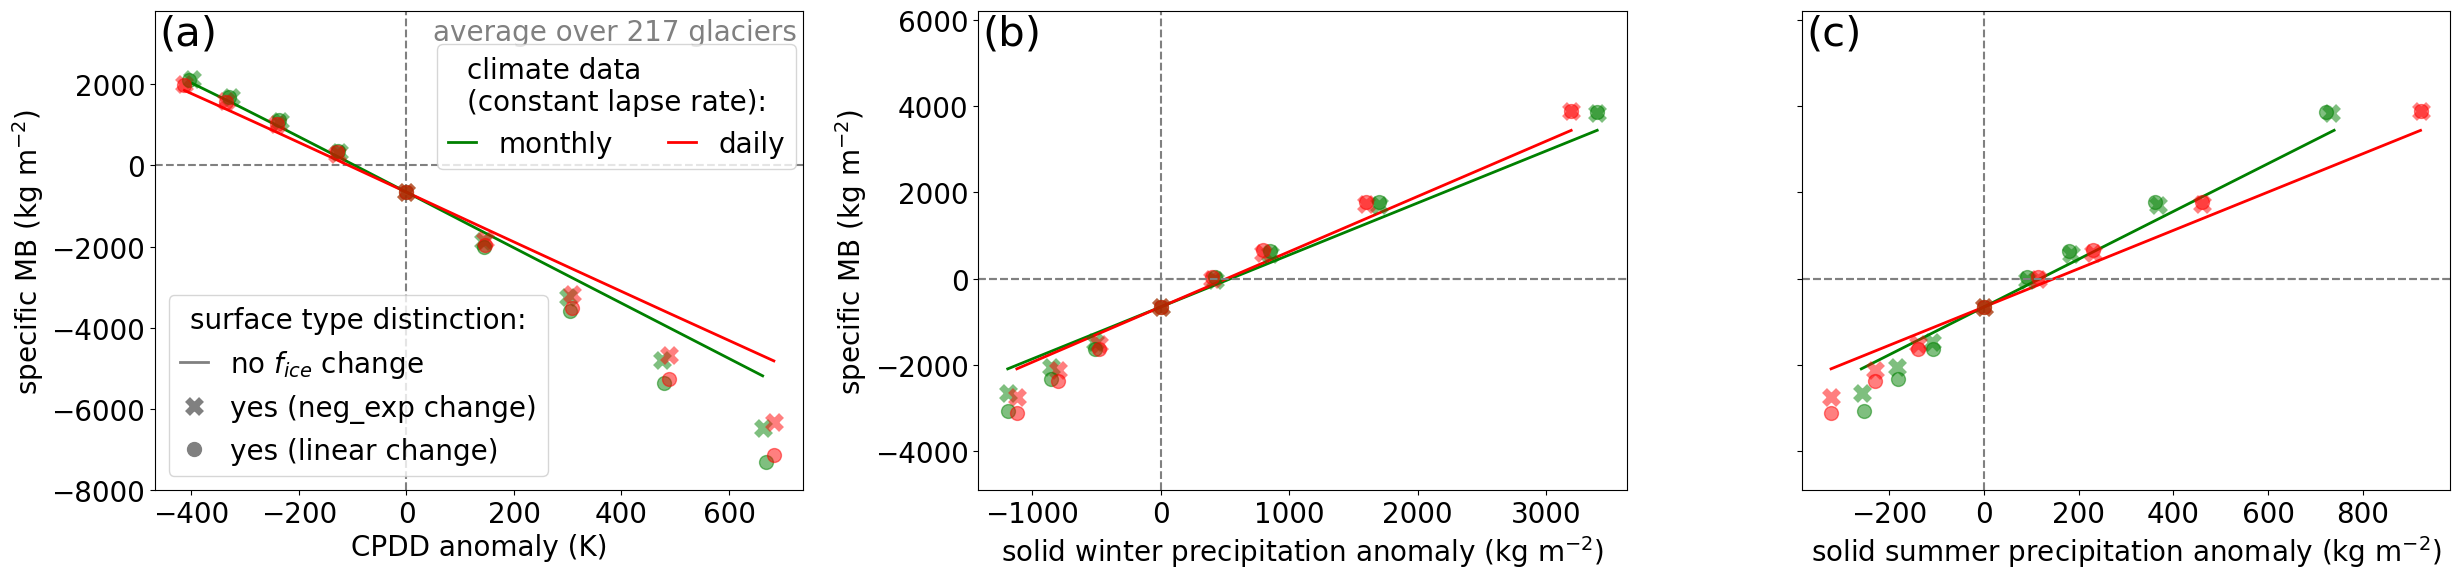

In [23]:
rgi = 'all'
grad_type='cte'
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly', calib_period_avg=True, anomaly =False, 
                         calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()

plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}.png')
plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}.pdf')

/tmp/ipykernel_14883/1769436931.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_14883/3023829559.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()
/tmp/ipykernel_14883/1769436931.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
/tmp/ipykernel_14883/3023829559.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should 

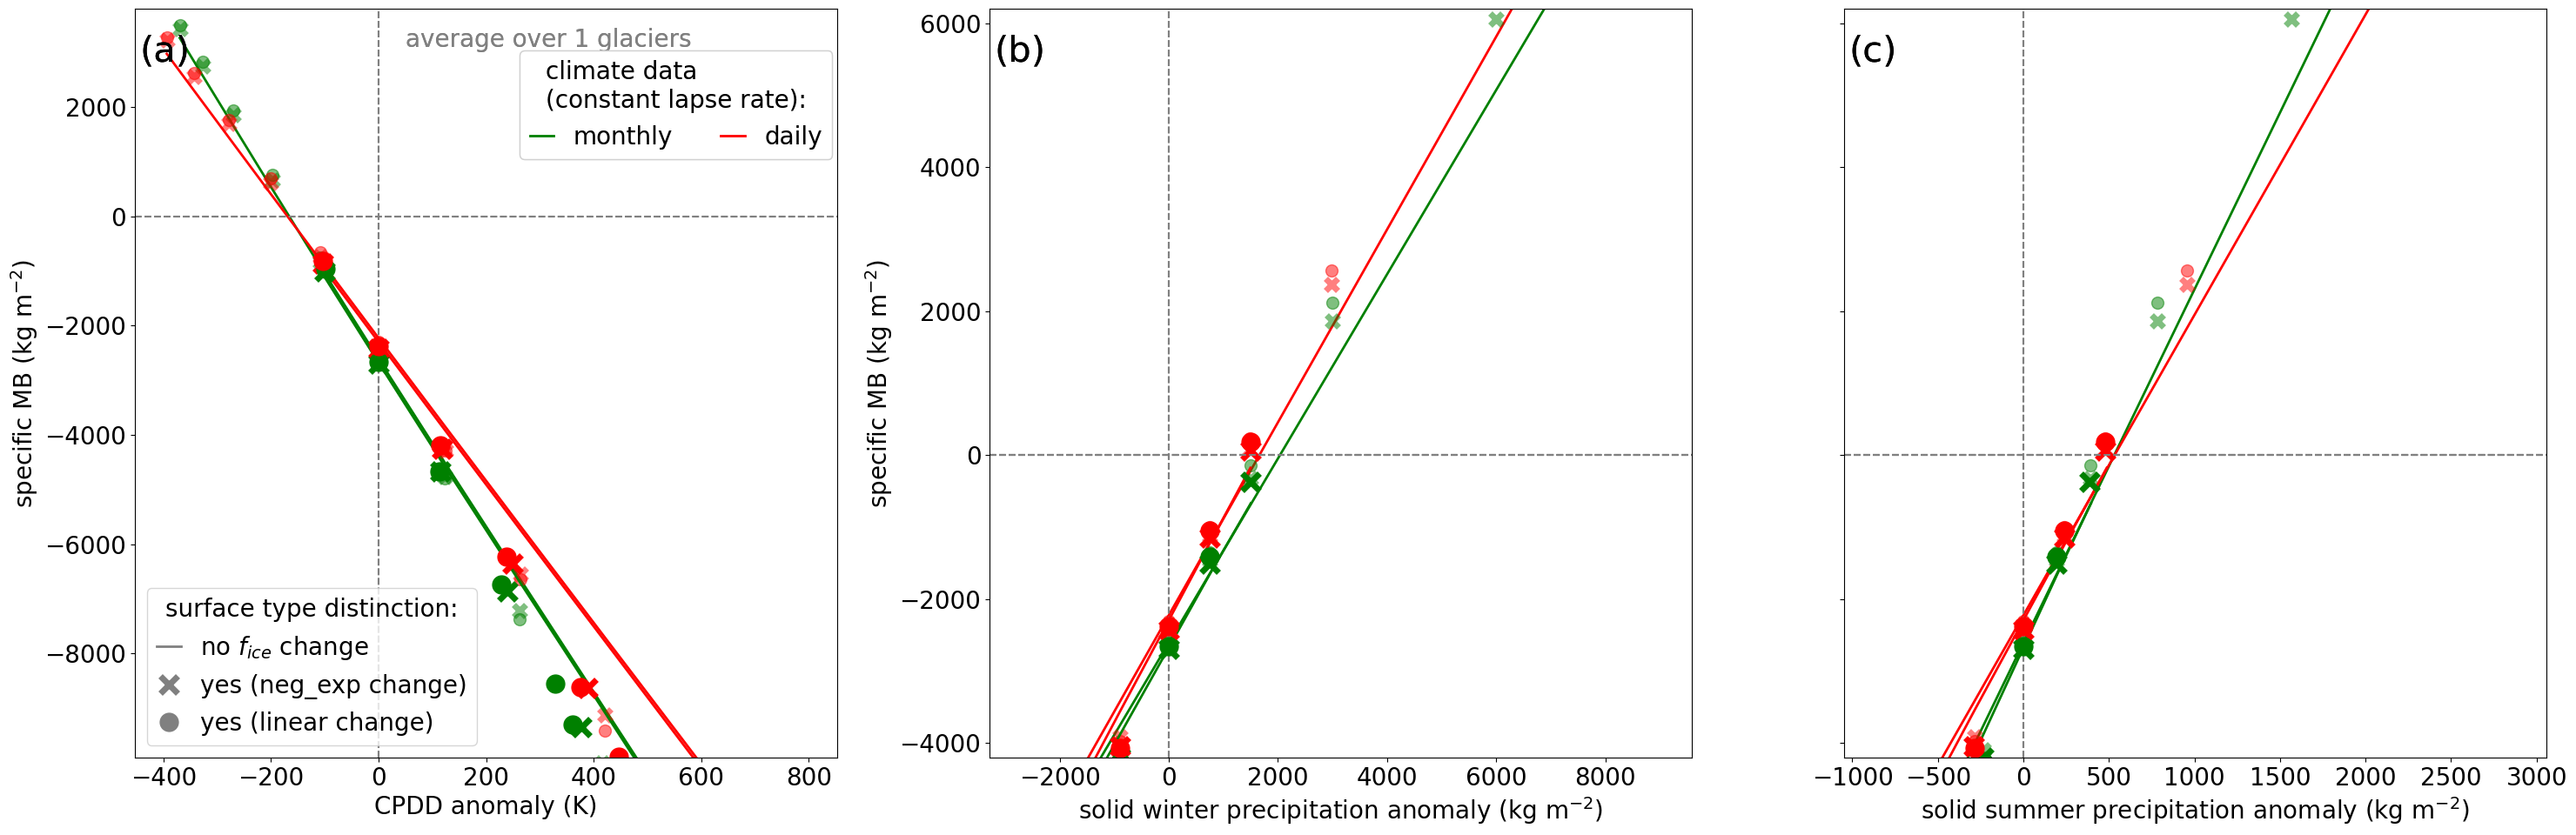

In [513]:
rgi = ['RGI60-11.01450']
grad_type='cte'
time_span = '5_last_years'
dynamical = False
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(30,10))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )

rgi = ['RGI60-11.01450']

grad_type='cte'
time_span = '5_last_years'
dynamical = True
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
#fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 15, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=1)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 15, #xs=axs
                              alpha_sfc_type=1,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()

/tmp/ipykernel_14883/1769436931.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_14883/3023829559.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()
/tmp/ipykernel_14883/1769436931.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_14883/3023829559.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


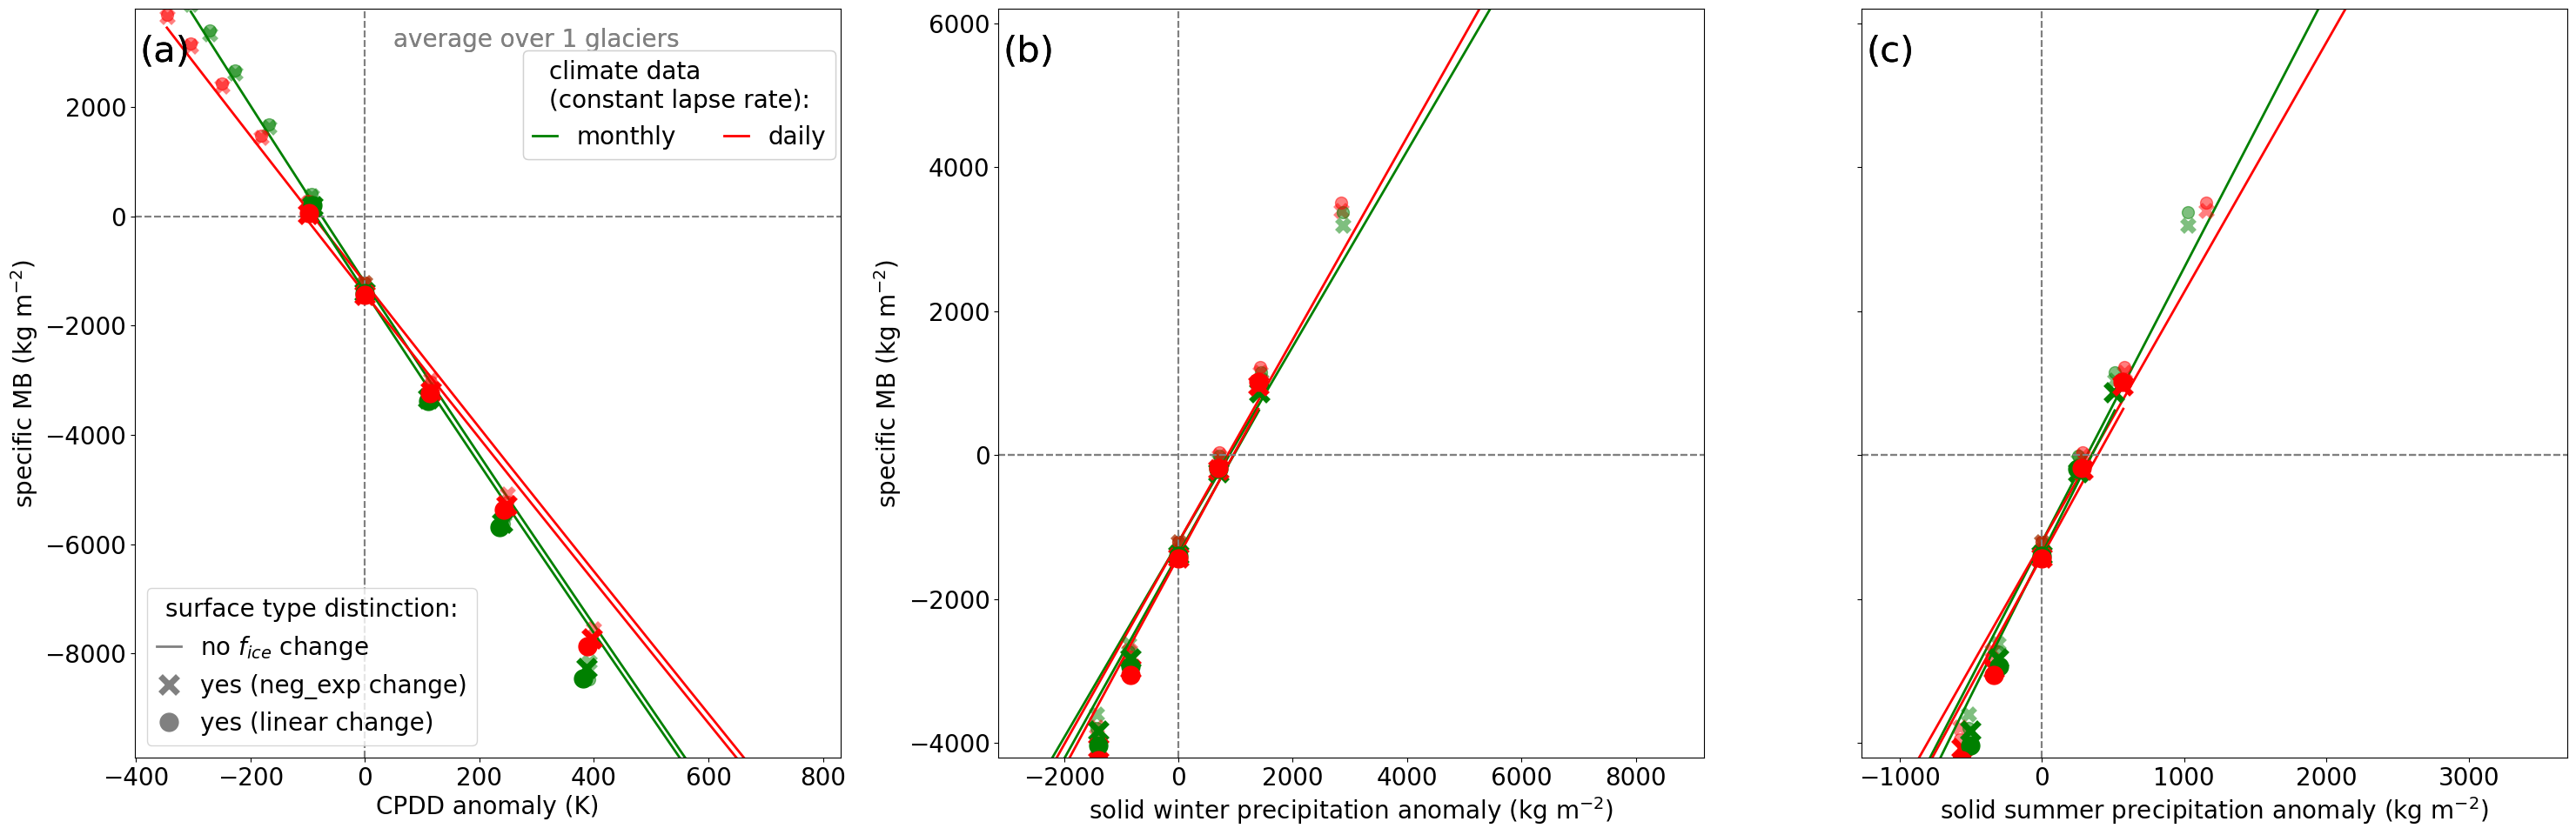

In [514]:
rgi = ['RGI60-11.01450']
grad_type='cte'
time_span = 'all'
dynamical = False
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(30,10))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )


dynamical = True
#fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 15, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=1)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 15, #xs=axs
                              alpha_sfc_type=1,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()

/tmp/ipykernel_14883/1769436931.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
/tmp/ipykernel_14883/3023829559.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


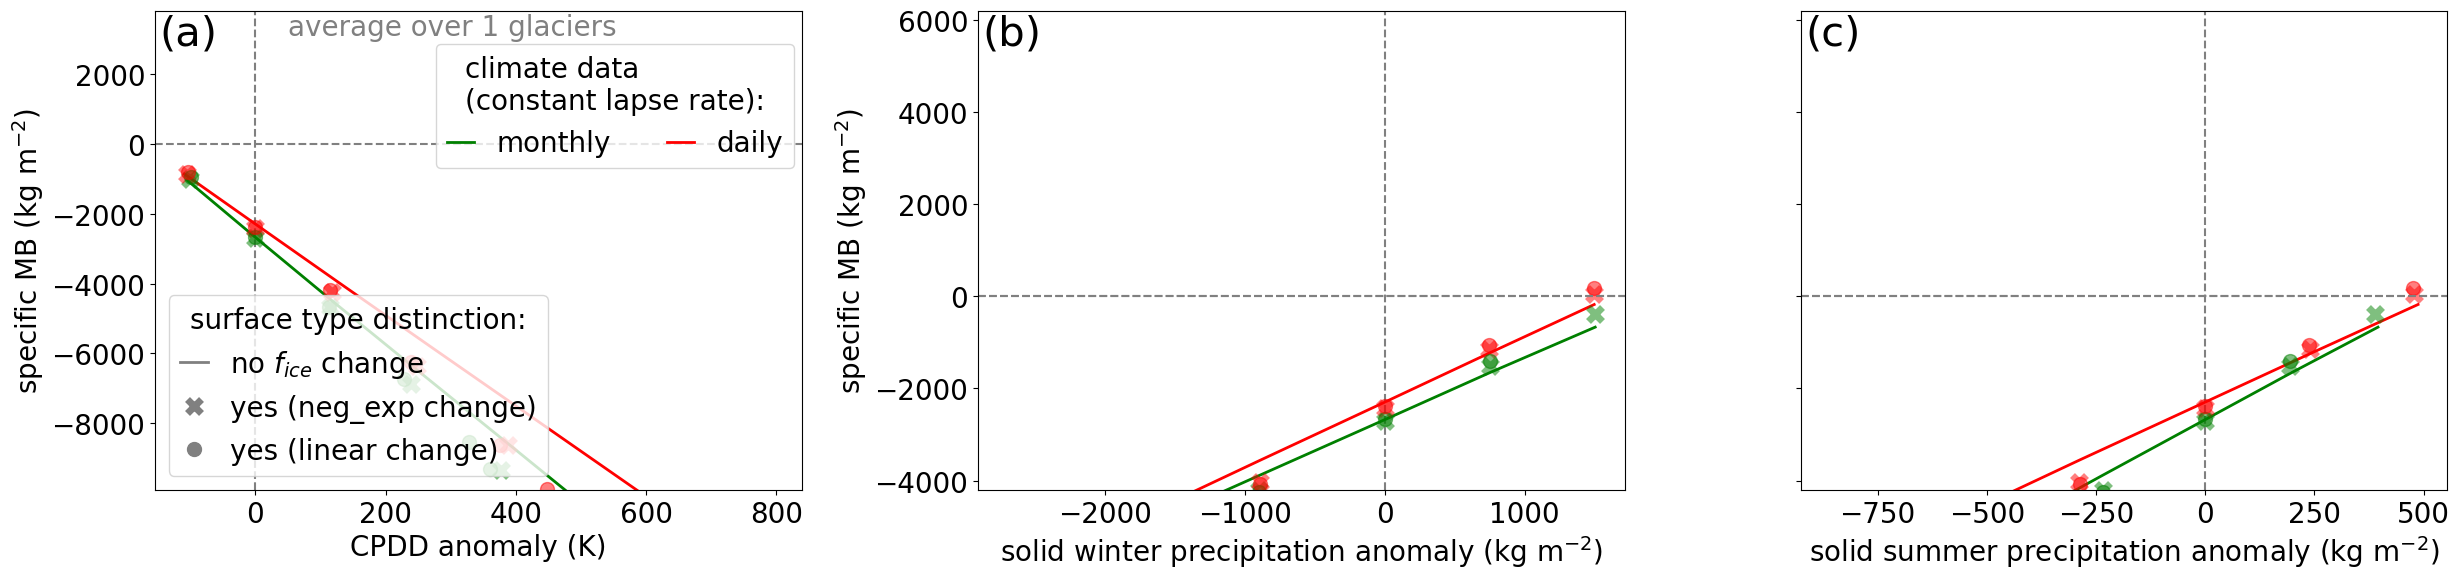

In [511]:
rgi = ['RGI60-11.01450']

grad_type='cte'
time_span = '5_last_years'
dynamical = True
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()

In [435]:
dyn.loc[(dyn.sfc_type=='linear')].groupby(['pf_mul','mb_type']).mean()

/tmp/ipykernel_14883/2602113903.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dyn.loc[(dyn.sfc_type=='linear')].groupby(['pf_mul','mb_type']).mean()


year  temp_bias        CPDD  winter CPDD  \
pf_mul mb_type                                                       
0.10   mb_monthly       2011.5        0.0  384.875333    14.960476   
       mb_pseudo_daily  2011.5        0.0  470.544750    39.230537   
       mb_real_daily    2011.5        0.0  471.404904    35.139646   
0.20   mb_monthly       2011.5        0.0  384.047210    15.061203   
       mb_pseudo_daily  2011.5        0.0  467.940275    38.924711   
       mb_real_daily    2011.5        0.0  470.029380    35.180995   
0.30   mb_monthly       2011.5        0.0  382.213940    14.890367   
       mb_pseudo_daily  2011.5        0.0  465.553124    38.604426   
       mb_real_daily    2011.5        0.0  467.619847    34.856184   
0.50   mb_monthly       2011.5        0.0  379.665240    14.678857   
       mb_pseudo_daily  2011.5        0.0  461.891128    38.084935   
       mb_real_daily    2011.5        0.0  464.059884    34.366906   
0.70   mb_monthly       2011.5        0.0  377.232855    14.371304   
       mb_pseudo_daily  2011.5        0.0  459.027312    37.628294   
       mb_real_daily    2011.5        0.0  461.149261    33.882810   
1.25   mb_monthly       2011.5        0.0  374.244365    13.990158   
       mb_pseudo_daily  2011.5        0.0  454.320869    36.795374   
       mb_real_daily    2011.5        0.0  456.780015    33.069501   
1.50   mb_pseudo_daily  2011.5        0.0  452.940407    36.490675   
       mb_real_daily    2011.5        0.0  455.579030    32.787058   

                        summer CPDD  solid annual prcp  solid winter prcp  \
pf_mul mb_type                                                              
0.10   mb_monthly        368.663248         381.288760         280.897673   
       mb_pseudo_daily   430.467486         380.414438         280.709173   
       mb_real_daily     435.318598         390.825924         278.512845   
0.20   mb_monthly        367.753570         762.976127         561.690114   
       mb_pseudo_daily   428.165847         761.859498         561.548672   
       mb_real_daily     433.921752         782.143896         556.958683   
0.30   mb_monthly        366.091544        1145.451750         842.746670   
       mb_pseudo_daily   426.101075        1144.137921         842.544311   
       mb_real_daily     431.828063        1174.406232         835.685292   
0.50   mb_monthly        363.771258        1911.471462        1404.970893   
       mb_pseudo_daily   422.964826        1910.127207        1404.742526   
       mb_real_daily     428.766841        1960.160199        1393.342540   
0.70   mb_monthly        361.640091        2678.909432        1967.735950   
       mb_pseudo_daily   420.556153        2677.549721        1967.367887   
       mb_real_daily     426.347086        2747.330798        1951.498211   
1.25   mb_monthly        359.034998        4791.030138        3515.260464   
       mb_pseudo_daily   416.691043        4791.725519        3515.282854   
       mb_real_daily     422.798304        4914.874701        3487.308756   
1.50   mb_pseudo_daily   415.612991        5753.864314        4219.347516   
       mb_real_daily     421.877256        5900.846349        4185.895988   

                        solid summer prcp      spec_mb  specific winter mb  \
pf_mul mb_type                                                               
0.10   mb_monthly               98.828385 -6497.707013           26.522485   
       mb_pseudo_daily          98.144495 -6837.106511         -255.305010   
       mb_real_daily           110.741580 -7031.711937         -230.018322   
0.20   mb_monthly              198.124321 -5843.666689          314.854802   
       mb_pseudo_daily         197.190129 -6090.456731           67.478474   
       mb_real_daily           222.025236 -6282.082942           78.131386   
0.30   mb_monthly              297.965041 -5208.015593          604.464898   
       mb_pseudo_daily         296.884106 -5392.214198          376.152257   
       mb_

/tmp/ipykernel_14883/867136137.py:72: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()
/tmp/ipykernel_14883/27273688.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
1
1 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


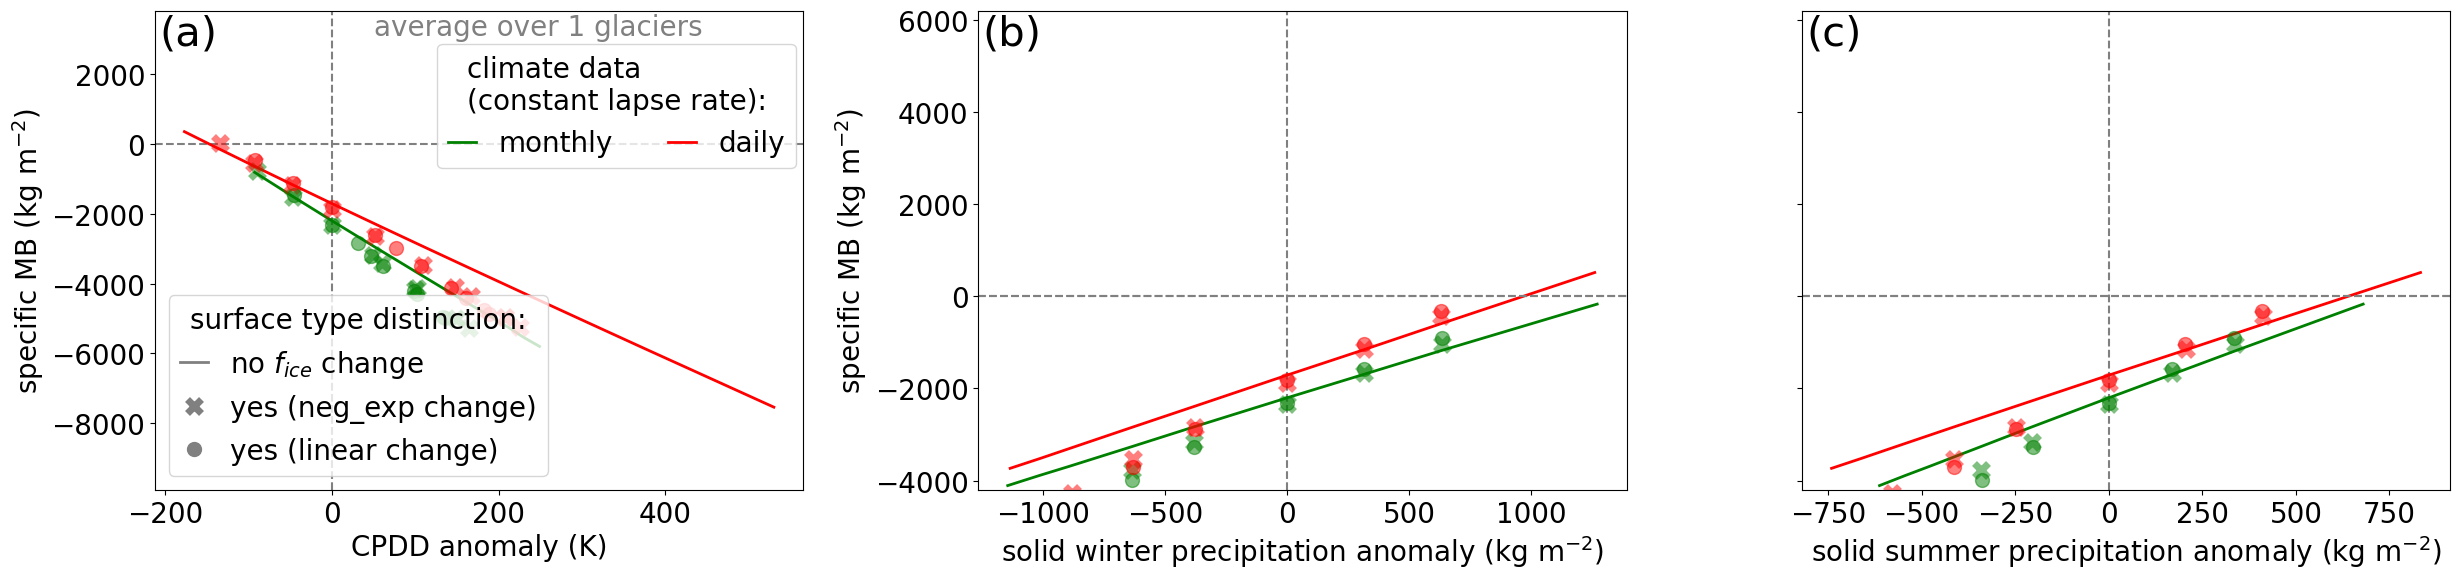

In [280]:
rgi = 'all'
grad_type='cte'
time_span = '5_last_years'
dynamical = True
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(dynamical=dynamical,
                               time_span=time_span,
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(dynamical =dynamical, 
                              rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly',
                            time_span=time_span,
                              calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()

plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}_dynamical_{time_span}.png')
plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}_dynamical_{time_span}.pdf')

/tmp/ipykernel_62880/3163584521.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217
217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_62880/3677135677.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


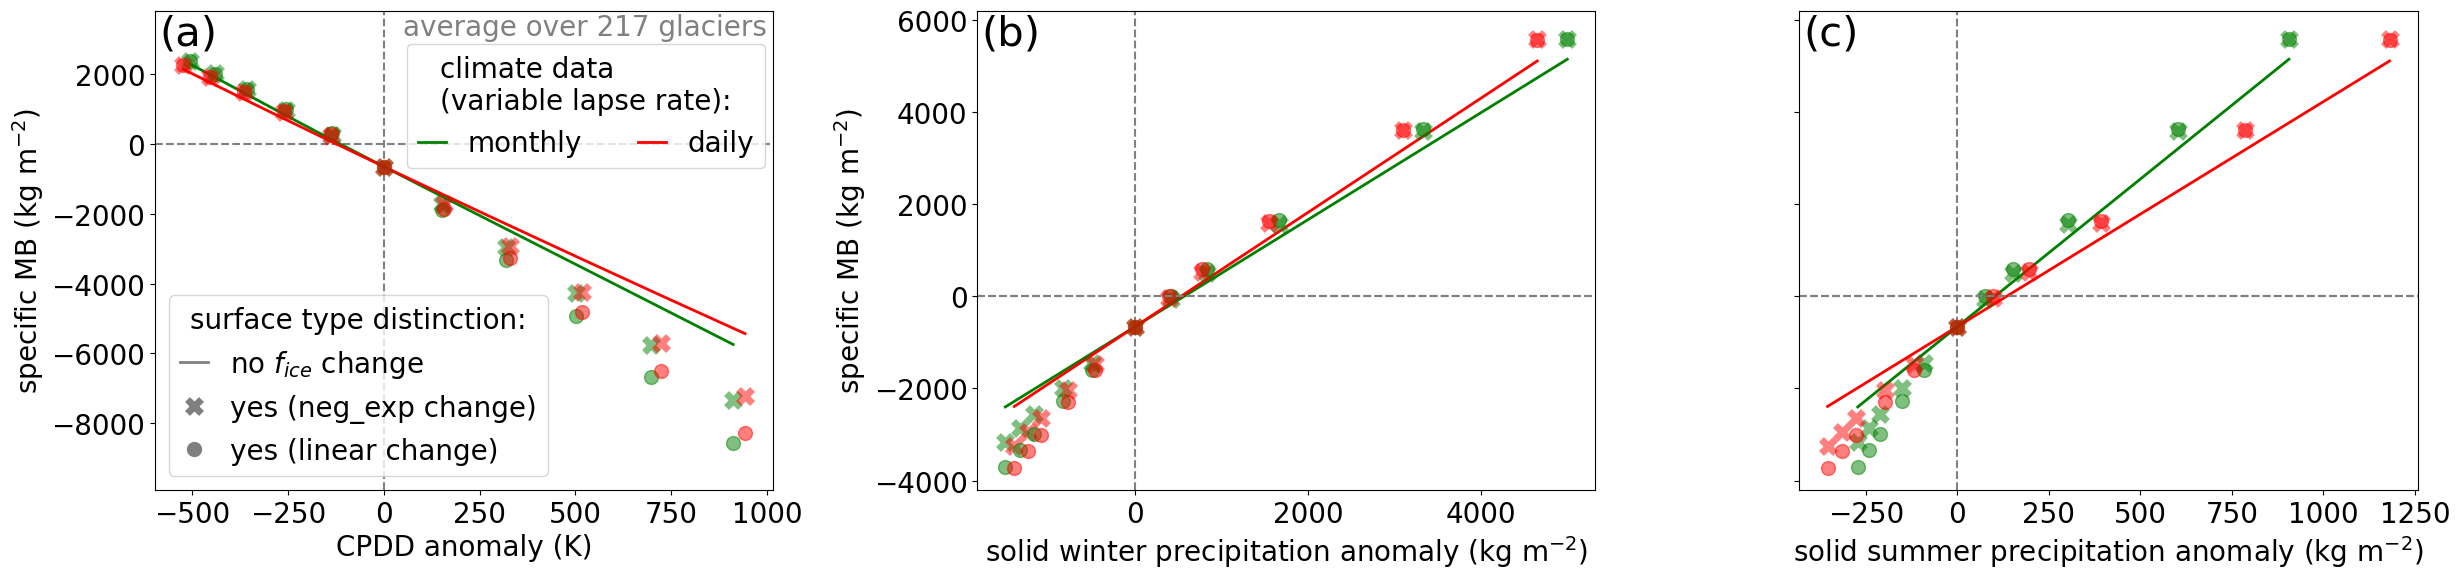

In [18]:
rgi = 'all'
grad_type='var_an_cycle'
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,6.2))
plot_non_linearities_temp_bias(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                               melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                only_simplest=True, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                              alpha_sfc_type=0.5)


plot_non_linearities_prcp_fac(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly', calib_period_avg=True, anomaly =False, 
                         calib_type = calib_type, only_simplest=True, ms_sfc_type = 10, #xs=axs
                              alpha_sfc_type=0.5,
                              grad_type = grad_type,
                               me_sfc_type=5
                             )
plt.tight_layout()
fig_path = '/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/figures_paper_oct_2022'

plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}.png')
plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}.pdf')

what do I added on this plot?
- check non-linearities cte vs var_an_cycle temp. lapse rate 
- also include neg_exp

**More advanced Fig.:**

/tmp/ipykernel_65134/2945377184.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217


/tmp/ipykernel_65134/1094218111.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_65134/2945377184.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['temp_bias','sfc_type', 'mb_type']).mean()


217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)
217
217 ref glaciers: mean climate and specific MB of 2000-2020 with anomalies
(melt_f_update: monthly, calib_type: calib_only_geod_temp_b_0_pf_fit_via_winter_mb)


/tmp/ipykernel_65134/1094218111.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_mean = pd_sensitivity_mb_sel.groupby(['pf_mul','sfc_type', 'mb_type']).mean()


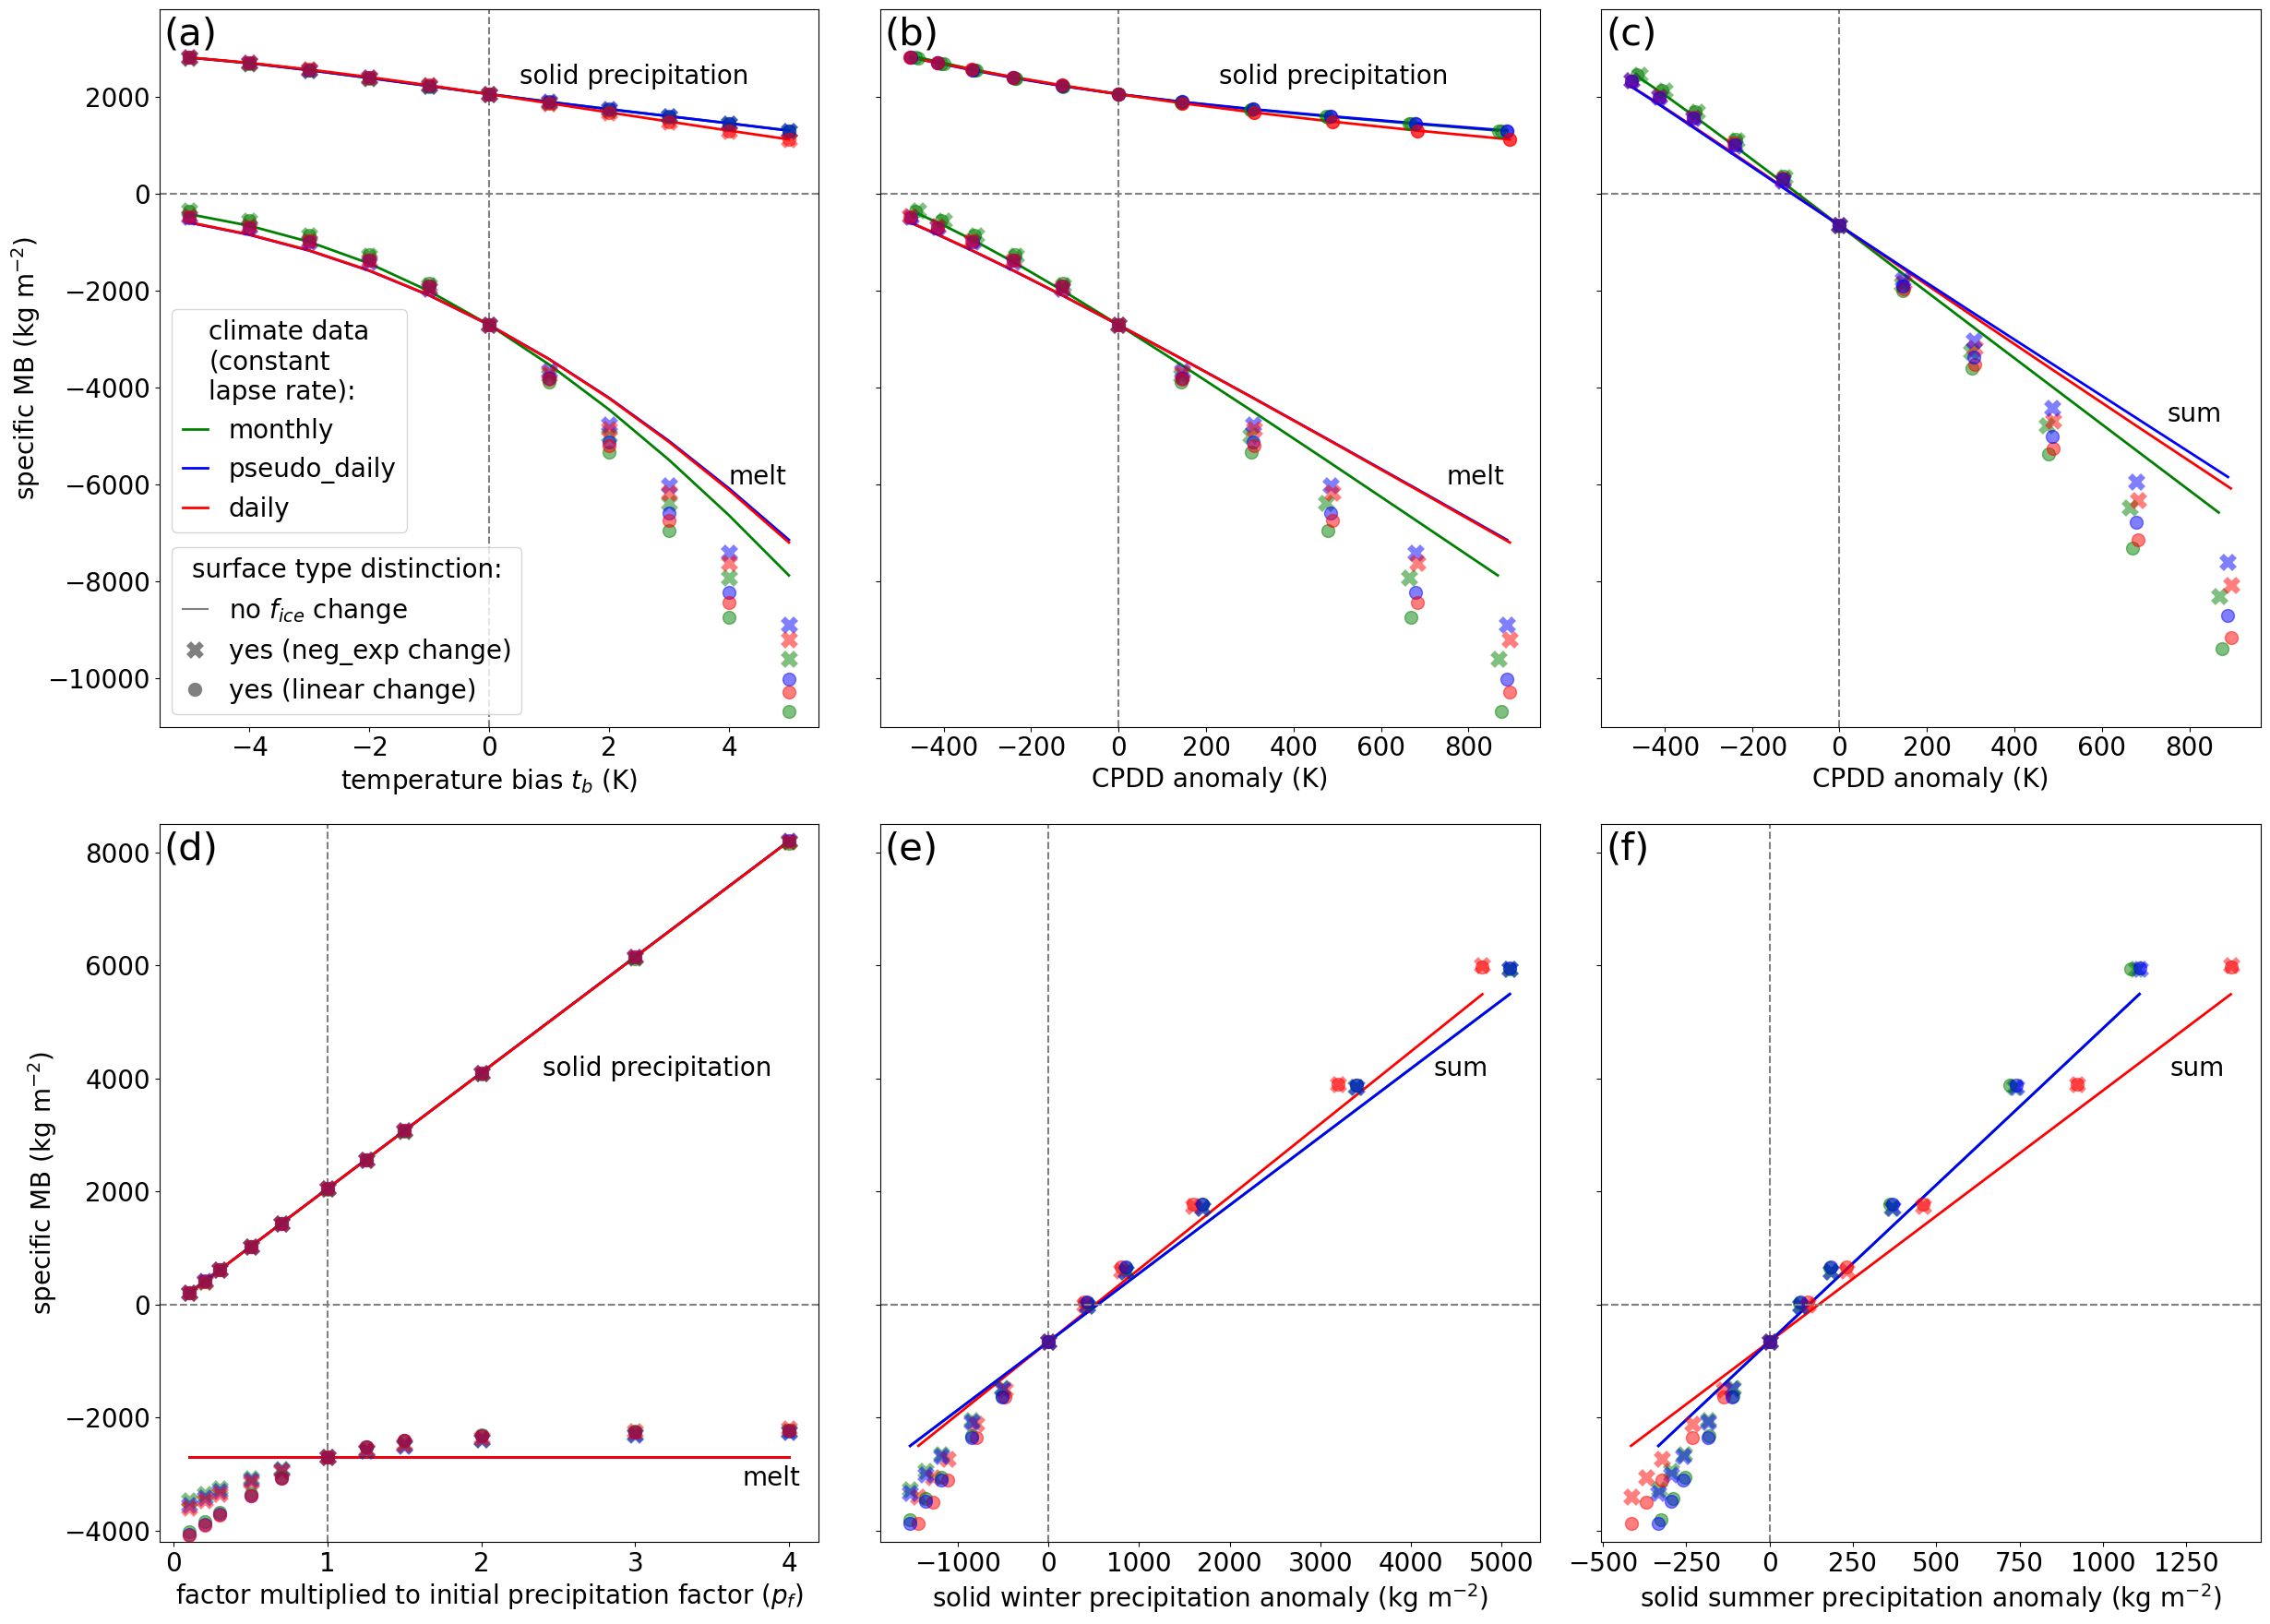

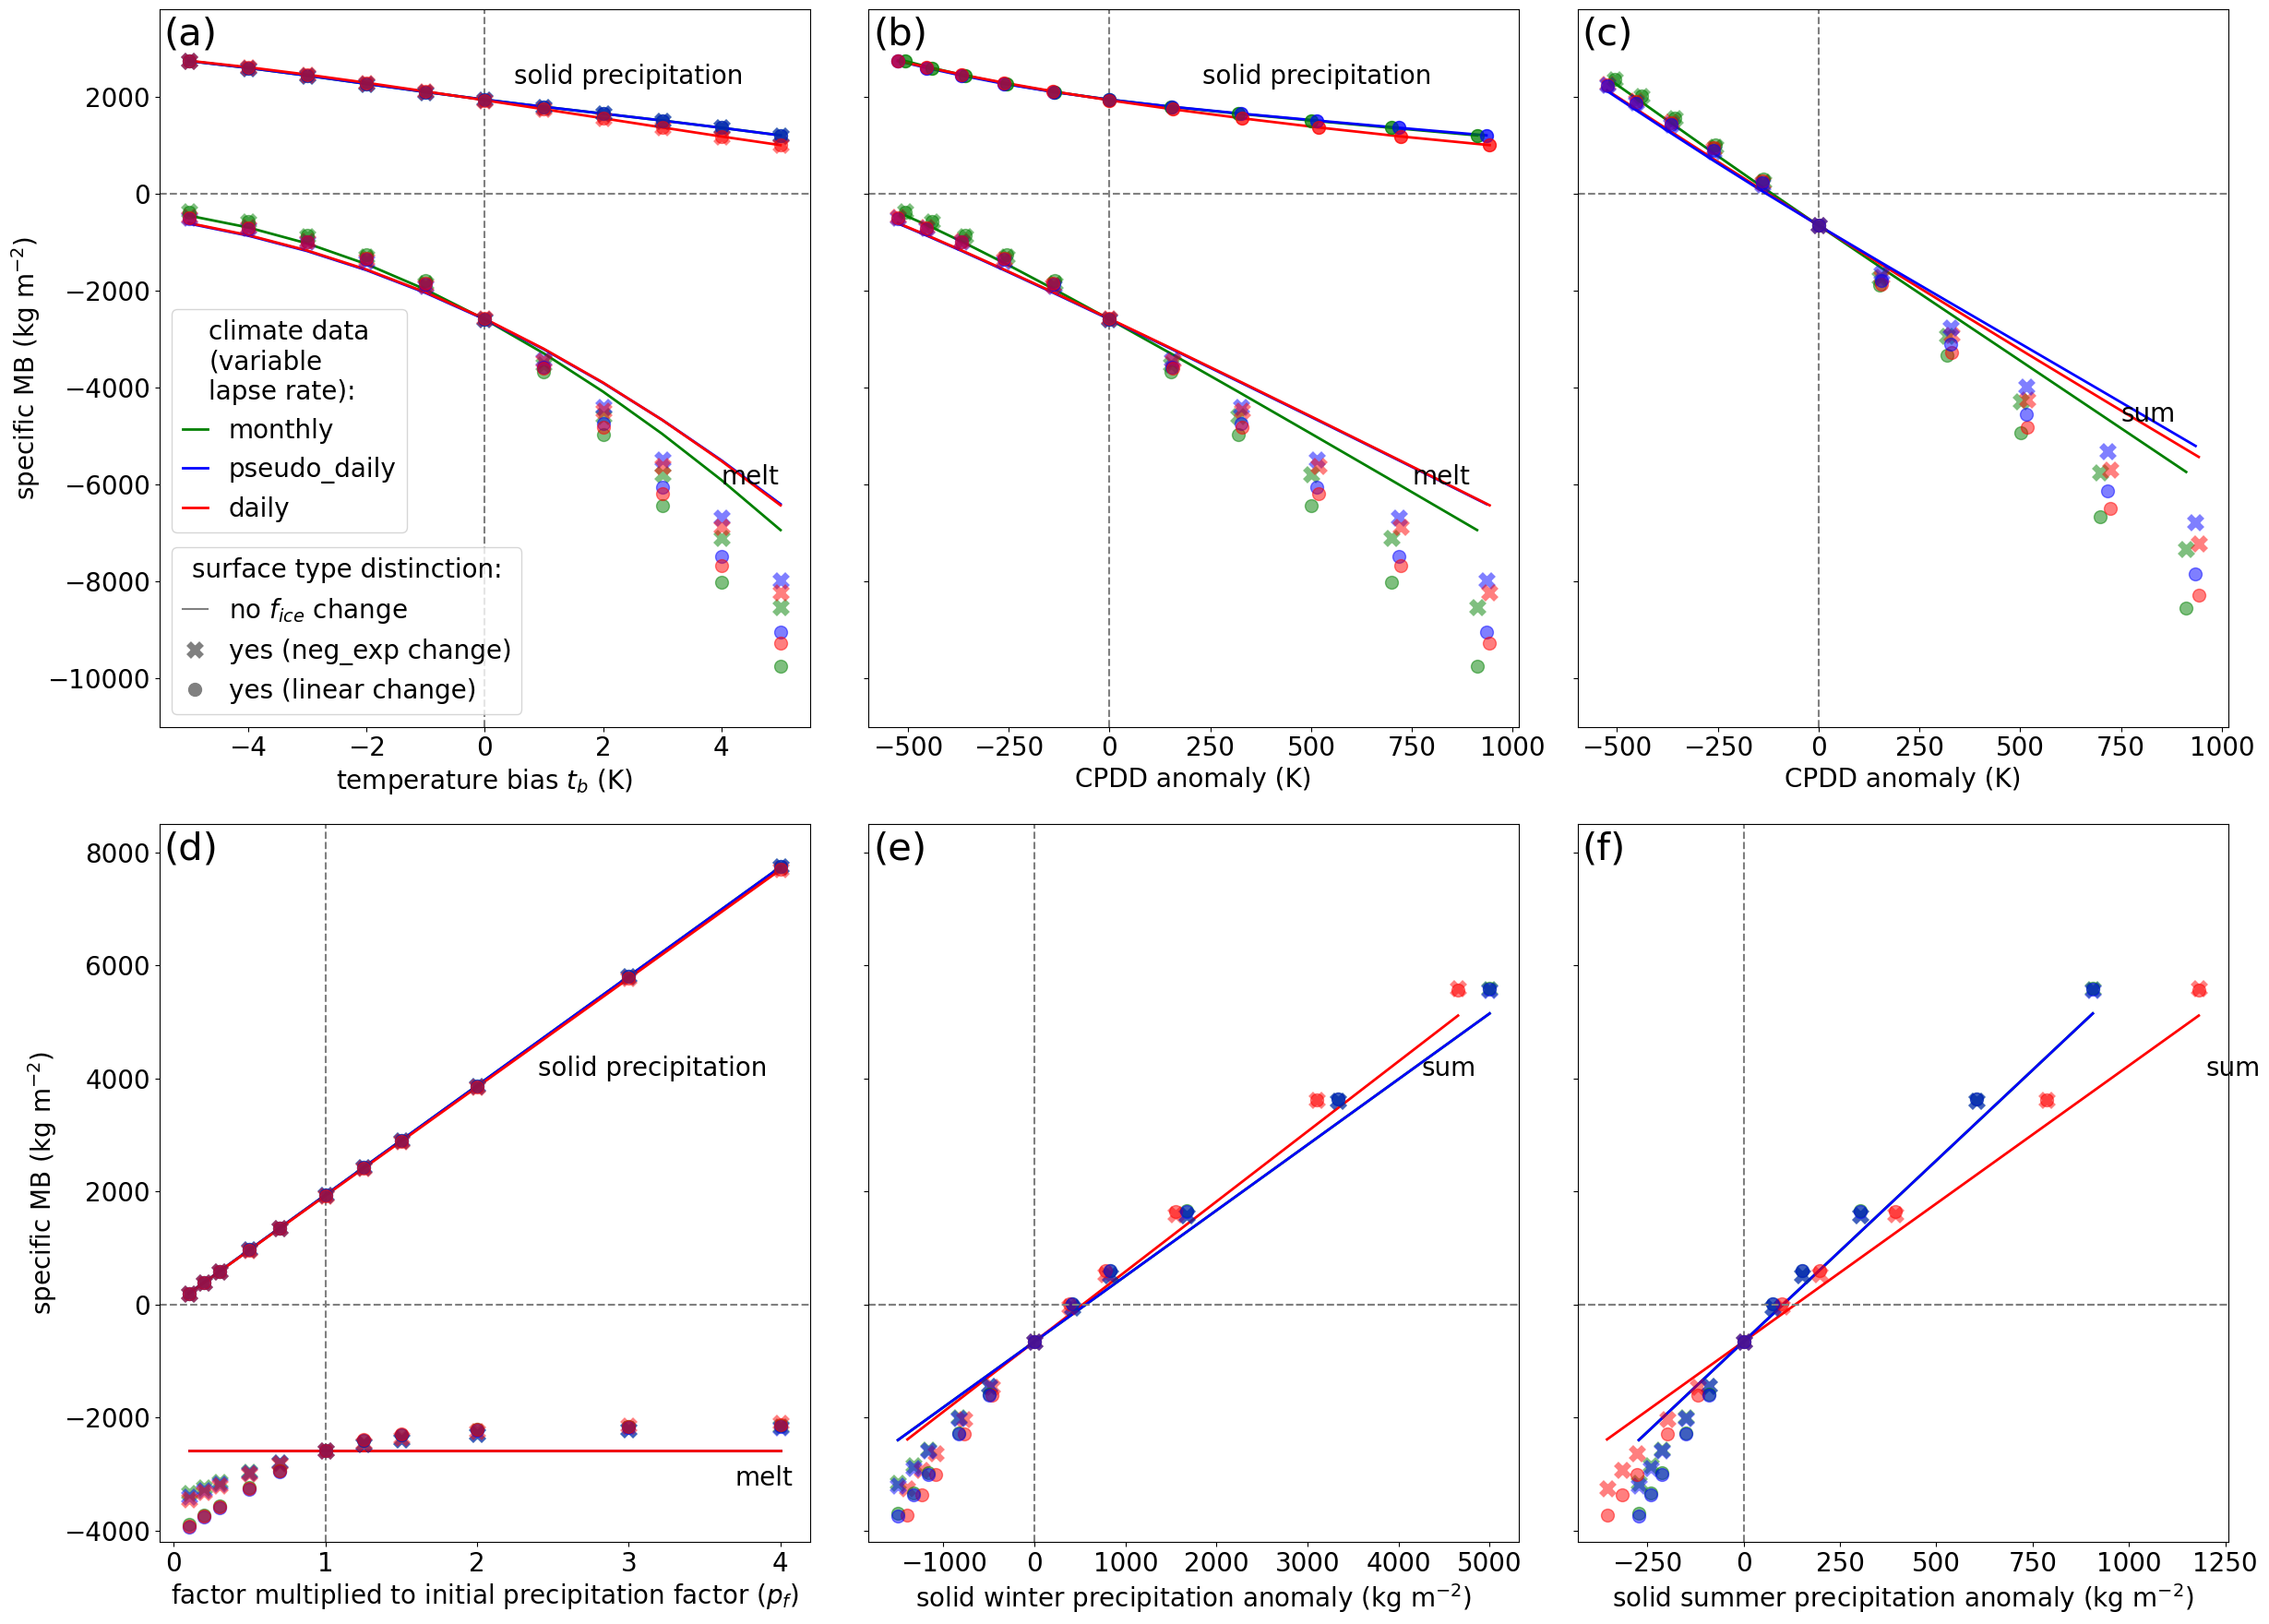

In [31]:
only_simplest = False

rgi = 'all'
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb' #'calib_only_geod_temp_b_0_pf_cte_via_std'

for grad_type in ['cte', 'var_an_cycle']:
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(25,18))
    plot_non_linearities_temp_bias(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac',
                                   melt_f_update = 'monthly', calib_period_avg=True, anomaly = False,
                                    calib_type = calib_type,#,axs=axs # 'calib_only_geod_temp_b_0_pf_cte_via_std'
                                    only_simplest=only_simplest, ms_sfc_type = 10, me_sfc_type=5, grad_type=grad_type,
                                  alpha_sfc_type=0.5)

    plot_non_linearities_prcp_fac(rgi=rgi, sensitivity='varying_temp_bias_prcp_fac', melt_f_update = 'monthly', calib_period_avg=True, anomaly =False, 
                             calib_type = calib_type, only_simplest=only_simplest, ms_sfc_type = 10, #xs=axs
                                  alpha_sfc_type=0.5,
                                  grad_type = grad_type,
                                   me_sfc_type=5
                                 )
    plt.tight_layout()

    plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}_advanced.png')
    plt.savefig(f'{fig_path}/specific_mb_cpdd_prcp_anomaly_bolibar_comparison_{grad_type}_advanced.pdf')

In [46]:
pd_sensitivity_mb#.rgi_id.unique()

year  temp_bias sfc_type        mb_type        CPDD  winter CPDD  \
0    2004.0       -1.0    False     mb_monthly  215.189031     0.446434   
1    2005.0       -1.0    False     mb_monthly  229.409721    10.134623   
2    2006.0       -1.0    False     mb_monthly  327.117543     9.009504   
3    2007.0       -1.0    False     mb_monthly  191.550158    21.822163   
4    2008.0       -1.0    False     mb_monthly  204.782909     2.789356   
..      ...        ...      ...            ...         ...          ...   
667  2015.0        0.0   linear  mb_real_daily  557.565432    46.013348   
668  2016.0        0.0   linear  mb_real_daily  466.074425    30.348973   
669  2017.0        0.0   linear  mb_real_daily  533.902940    16.607127   
670  2018.0        0.0   linear  mb_real_daily  606.282459    42.693447   
671  2019.0        0.0   linear  mb_real_daily  526.810110    35.454949   

     summer CPDD  solid annual prcp  solid winter prcp  solid summer prcp  \
0     204.930669        4204.102989        3349.060503        1307.993286   
1     220.277892        3568.400494        2408.992383        1293.282206   
2     310.617153        3784.613895        2509.651351        1310.578050   
3     183.277490        4341.606444        2158.037357        1786.868065   
4     200.686194        4416.996335        2972.877994        1147.430015   
..           ...                ...                ...                ...   
667   526.404773        5453.835843        4674.745106        1621.351211   
668   451.036907        5888.155798        4128.951501        1824.792227   
669   502.463197        6076.908846        3622.002780        1464.168963   
670   559.008259        6057.679741        5197.010696         744.308135   
671   492.064861        6431.148207        4742.674134        1483.973989   

     ...          rgi_id        pf  pf_calib melt_f_update  melt_f_change  \
0    ...  RGI60-11.01450  1.935276  1.935276         False          False   
1    ...  RGI60-11.01450  1.935276  1.935276         False          False   
2    ...  RGI60-11.01450  1.935276  1.935276         False          False   
3    ...  RGI60-11.01450  1.935276  1.935276         False          False   
4    ...  RGI60-11.01450  1.935276  1.935276         False          False   
..   ...             ...       ...       ...           ...            ...   
667  ...  RGI60-11.01450  2.902915  1.935276       monthly         linear   
668  ...  RGI60-11.01450  2.902915  1.935276       monthly         linear   
669  ...  RGI60-11.01450  2.902915  1.935276       monthly         linear   
670  ...  RGI60-11.01450  2.902915  1.935276       monthly         linear   
671  ...  RGI60-11.01450  2.902915  1.935276       monthly         linear   

     grad_type spec_mb_only_melt winter_mb_only_melt summer_mb_only_melt  \
0          cte      -2985.238860           -6.193221        -2842.928354   
1          cte      -3182.517306         -140.593922        -3055.834773   
2          cte      -4537.982246         -124.985560        -4309.078364   
3          cte      -2657.305408         -302.730900        -2542.541708   
4          cte      -2840.878537          -38.695711        -2784.046300   
..         ...               ...                 ...                 ...   
667        cte      -5882.378812         -569.857141        -5545.739986   
668        cte      -5007.562219         -334.614893        -4853.252607   
669        cte      -5840.140950         -171.506908        -5476.791269   
670        cte      -6603.300133         -461.823965        -6164.499718   
671        cte      -5654.751431         -343.597501        -5208.280205   

     pf_mul  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0  
..      ...  
667     1.5  
668     1.5  
669     1.5  
670     1.5  
671     1.5  

[2000 rows x 23 columns]

In [14]:
pd_sensitivity_mb.columns

Index(['year', 'temp_bias', 'sfc_type', 'mb_type', 'CPDD', 'winter CPDD',
       'summer CPDD', 'solid annual prcp', 'solid winter prcp',
       'solid summer prcp', 'spec_mb', 'specific winter mb',
       'specific summer mb', 'rgi_id', 'pf', 'pf_calib', 'melt_f_update',
       'melt_f_change', 'grad_type', 'spec_mb_only_melt',
       'winter_mb_only_melt', 'summer_mb_only_melt', 'pf_mul'],
      dtype='object')

In [17]:
fname = f'climate_sensitivity_ref_glaciers_{calib_type}_all_ti_models.csv'
pd_sensitivity_mb_fix = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/{fname}',
                                index_col = 'Unnamed: 0')
fname = f'climate_sensitivity_all_ref_glaciers_{calib_type}_all_ti_models_dynamical.csv'
pd_sensitivity_mb_dyn = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/{fname}',
                                index_col = 'Unnamed: 0')

In [36]:
rgi_l = list(set(pd_sensitivity_mb_fix.rgi_id.unique()) & set(pd_sensitivity_mb_dyn.rgi_id.unique()))

In [43]:
handles[5].get_linestyle()

'-'

/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',
/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',


-


/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',
/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',


-


/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',
/tmp/ipykernel_3456/3058090747.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',


-


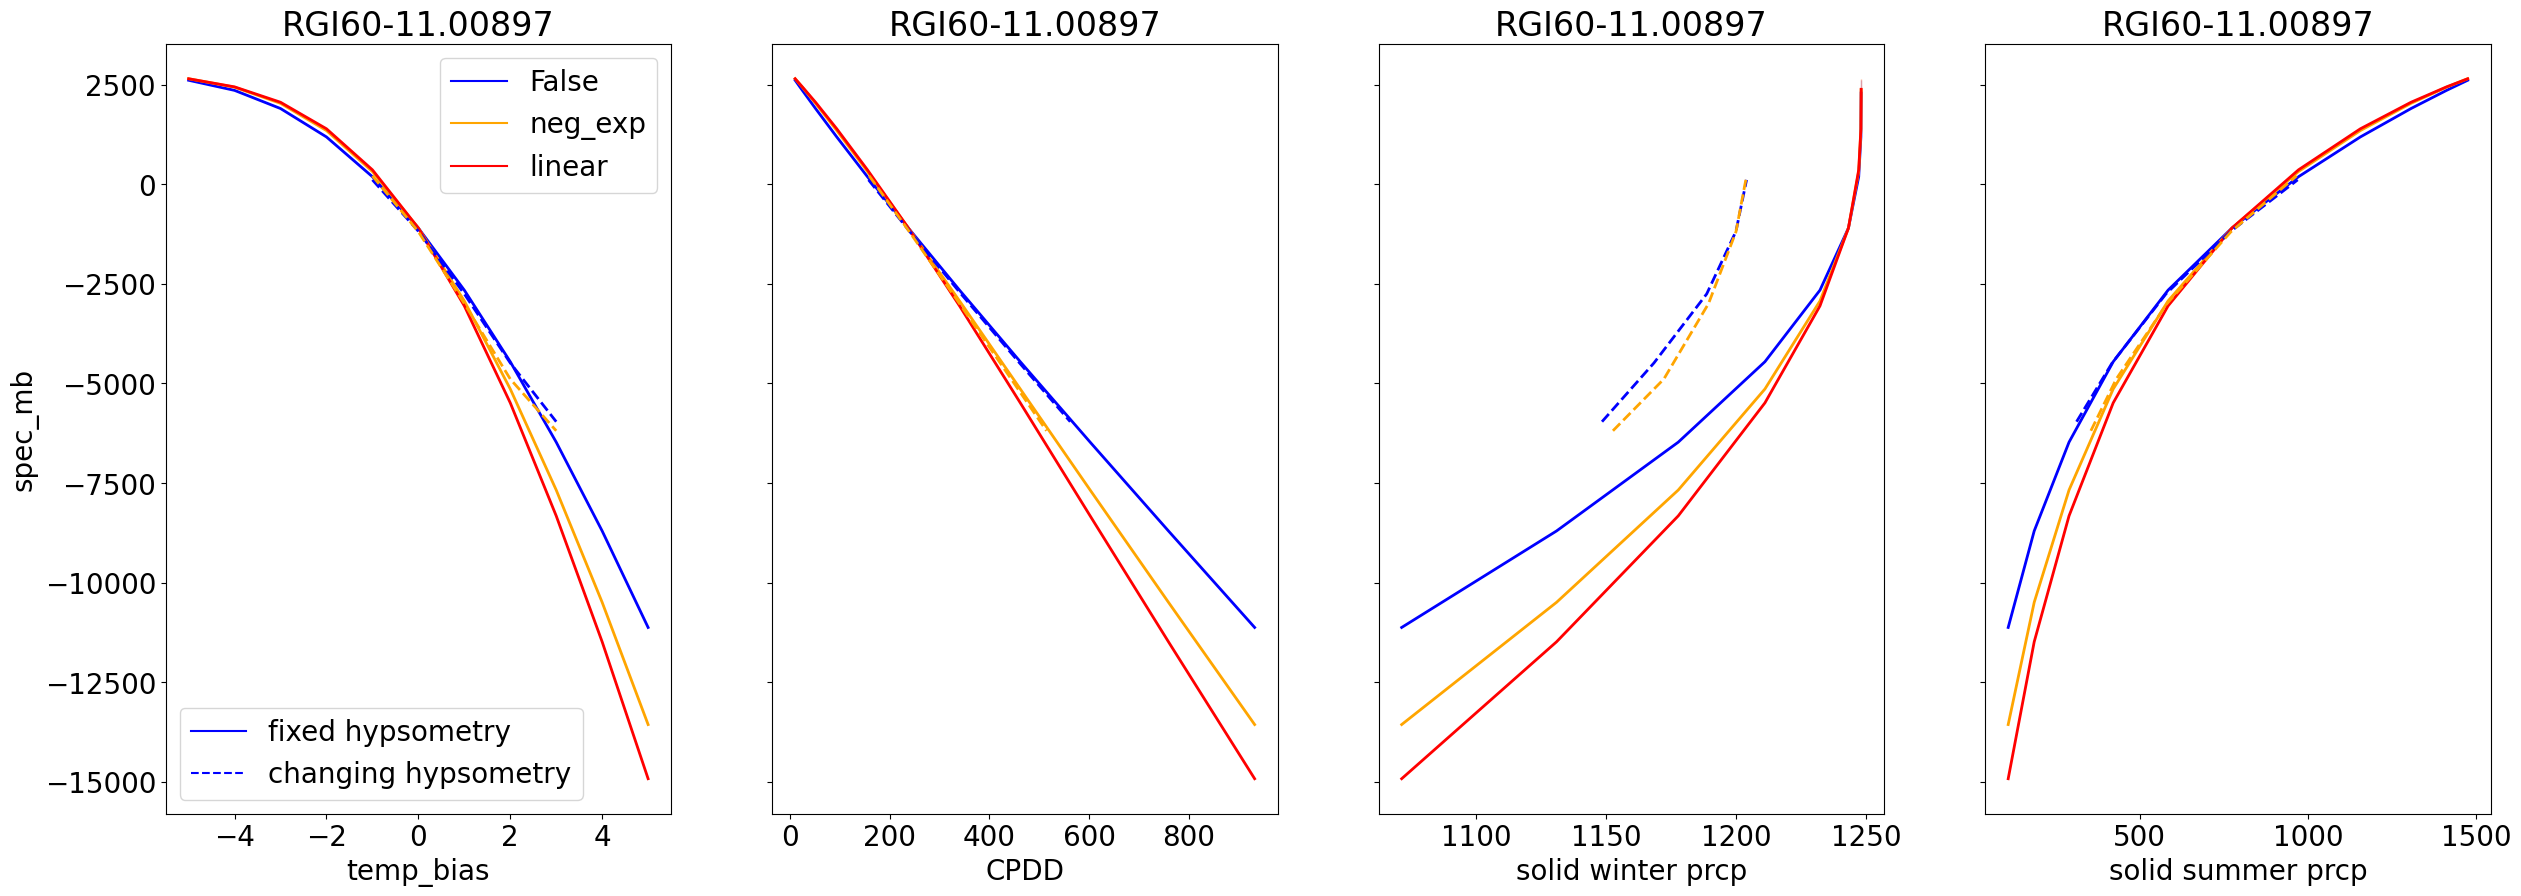

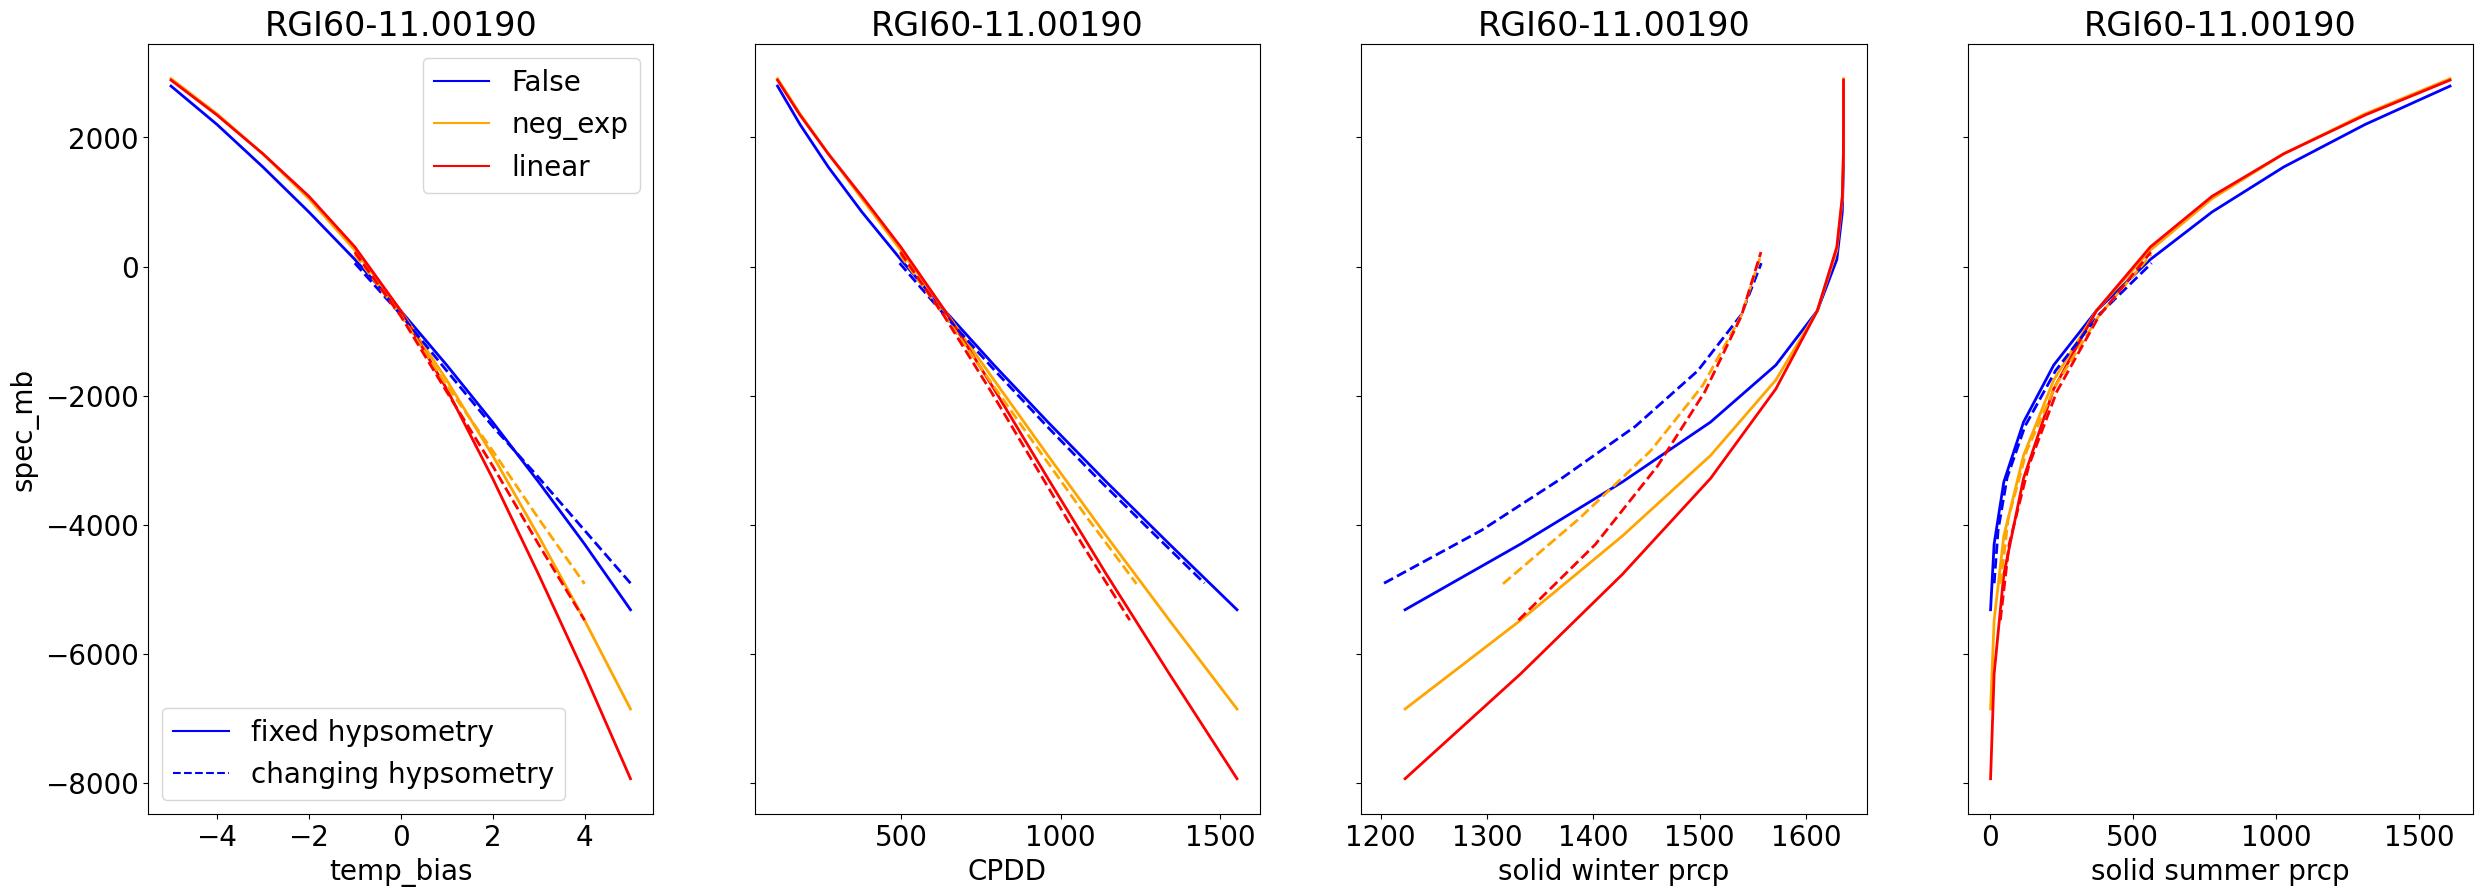

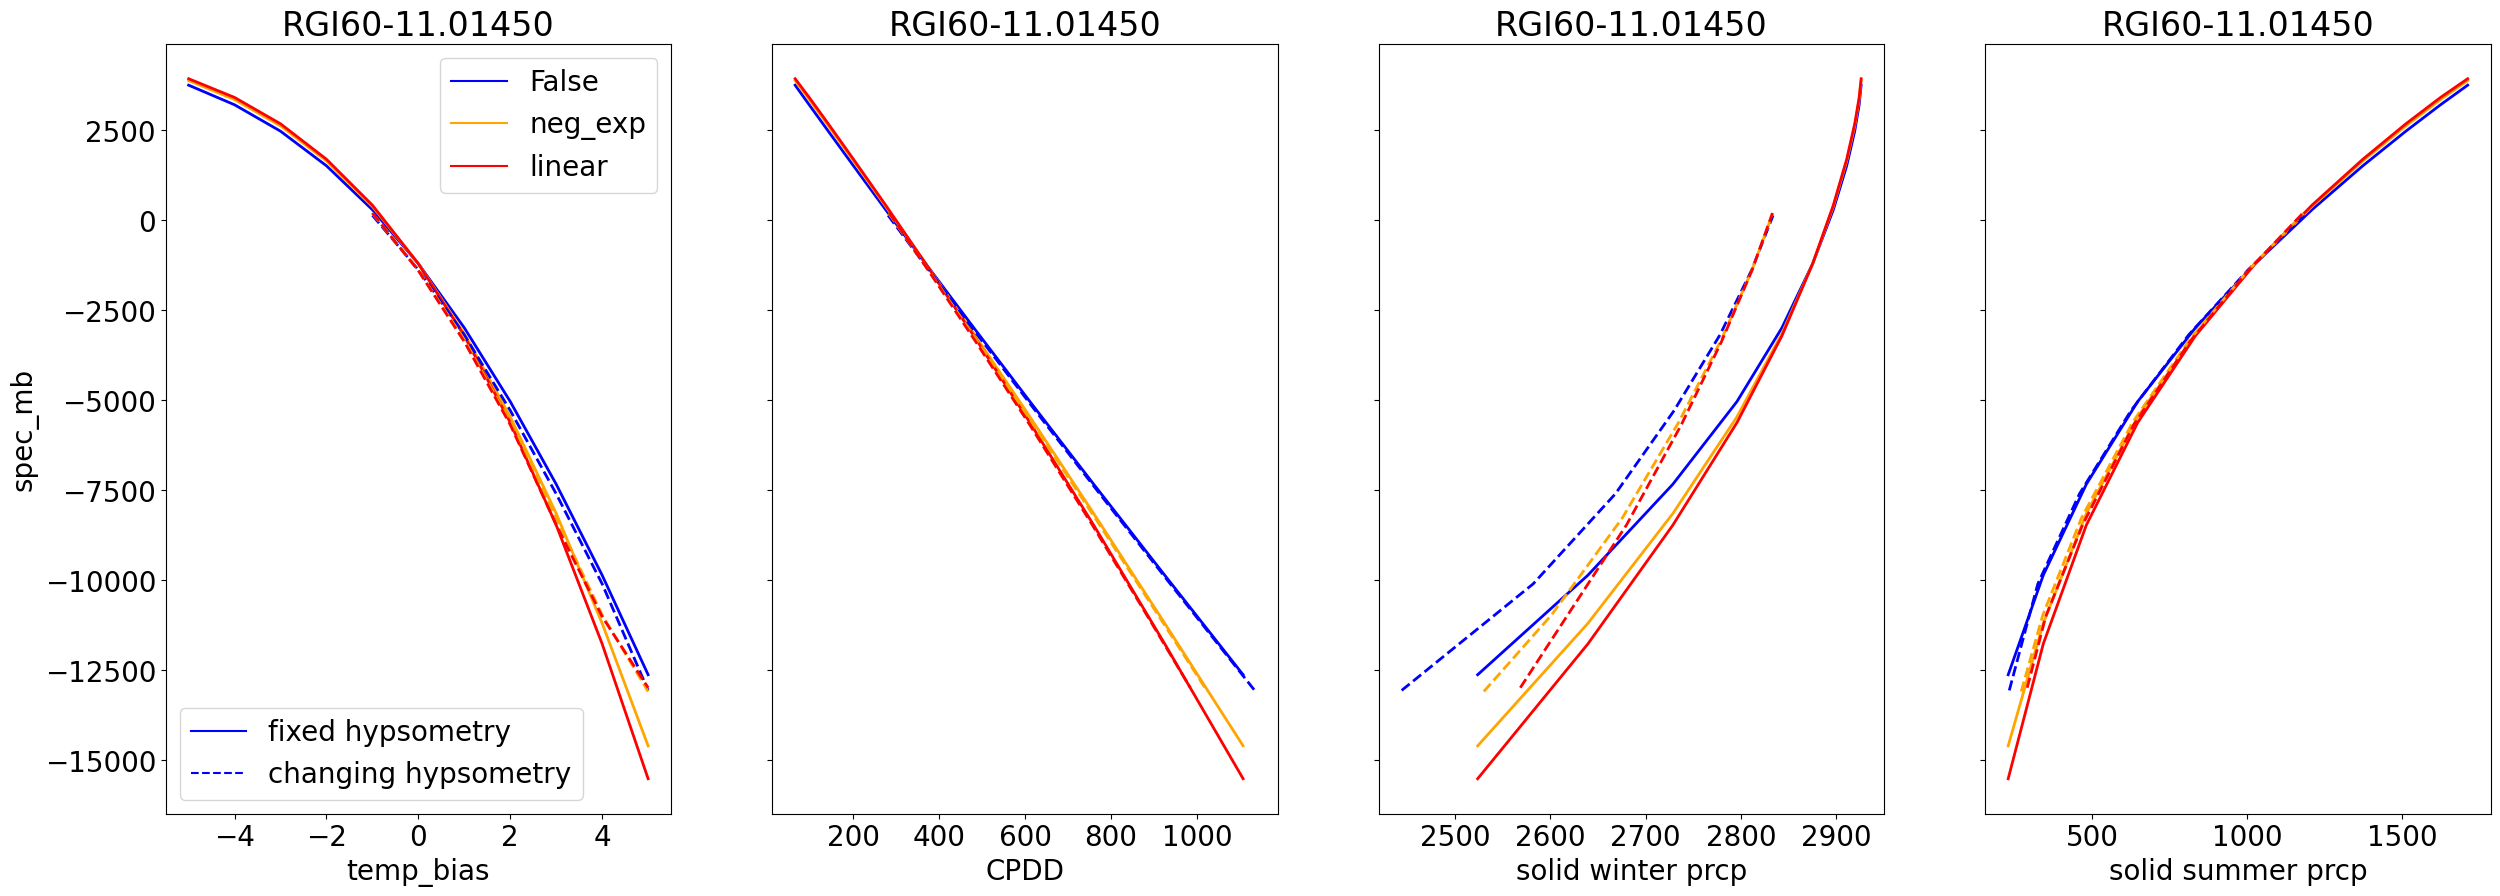

In [45]:
hue_order=['False', 'neg_exp','linear']

for rgi_id in ['RGI60-11.00897','RGI60-11.00190', 'RGI60-11.01450']:
    fig, axs = plt.subplots(1,4,figsize=(30,10), sharey=True)

    for j,dynamical in enumerate([False, True]):
        if dynamical:
            dyn = '_dynamical'
            ls= '--'
            pd_sensitivity_mb = pd_sensitivity_mb_dyn
        else:
            dyn = ''
            ls = '-'
            pd_sensitivity_mb = pd_sensitivity_mb_fix
        pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[(pd_sensitivity_mb.pf_mul.round(2)==1)].dropna()
        pd_sensitivity_mb_sel = pd_sensitivity_mb_sel.loc[(pd_sensitivity_mb_sel.rgi_id == rgi_id)]
        pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type',
                                                                    'grad_type']).mean().reset_index()
        pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel_mean.loc[(pd_sensitivity_mb_sel_mean.grad_type=='cte')&(pd_sensitivity_mb_sel_mean.mb_type=='mb_monthly')]

        sns.lineplot(x= 'temp_bias', y= 'spec_mb',hue='sfc_type',
                     palette = sns.color_palette(['blue','orange', 'red']),
                     hue_order = hue_order,
                     data = pd_sensitivity_mb_sel_mean, #.loc[(pd_sensitivity_mb_sel_mean.sfc_type=='neg_exp')],
                    label = dyn, ax=axs[0], ls= ls, lw=2)
        axs[0].set_title(rgi_id)
        if dynamical:
            handles, labels = axs[0].get_legend_handles_labels()
            axs[0].legend().remove()
            leg0 = axs[0].legend(handles[:3], labels[:3])
            #print(handles[3].get_linestyle())
            handles[3].set_linestyle('--')
            axs[0].legend([handles[0],handles[3]], ['fixed hypsometry', 'changing hypsometry'])
            axs[0].add_artist(leg0)


        sns.lineplot(x= 'CPDD', y= 'spec_mb',hue='sfc_type',palette=sns.color_palette(['blue', 'orange',
                                                                                       'red']),
                      hue_order = hue_order,
                     data = pd_sensitivity_mb_sel_mean, #.loc[(pd_sensitivity_mb_sel_mean.sfc_type=='neg_exp')],
                    label = dyn, ax=axs[1],ls = ls,lw=2)
        axs[1].set_title(rgi_id)
        
        sns.lineplot(x= 'solid winter prcp', y= 'spec_mb',hue='sfc_type',
                     palette=sns.color_palette(['blue', 'orange', 'red']),
                    hue_order = hue_order,
                     data = pd_sensitivity_mb_sel_mean, #.loc[(pd_sensitivity_mb_sel_mean.sfc_type=='neg_exp')],
                    label = dyn, ax=axs[2],ls = ls,lw=2)
        axs[2].set_title(rgi_id)
        
        sns.lineplot(x= 'solid summer prcp', y= 'spec_mb',hue='sfc_type',
                     palette=sns.color_palette(['blue', 'orange', 'red']),
                     data = pd_sensitivity_mb_sel_mean, #.loc[(pd_sensitivity_mb_sel_mean.sfc_type=='neg_exp')],
                    label = dyn, ax=axs[3],
                     hue_order = hue_order,lw=2,
                     ls = ls)
        axs[3].set_title(rgi_id)
        
        # remove legends
        axs[1].legend().remove()
        axs[2].legend().remove()
        axs[3].legend().remove()

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (139, 94)
  Grid (dx, dy): (50.0, -50.0)

In [31]:
pd_sensitivity_mb_sel_mean

/tmp/ipykernel_24283/2268134137.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_sensitivity_mb_sel_mean = pd_sensitivity_mb_sel.groupby(['temp_bias', 'sfc_type', 'mb_type', 'grad_type']).mean().reset_index()


temp_bias sfc_type          mb_type     grad_type    year         CPDD  \
0         -5.0    False       mb_monthly           cte  2009.5    10.203635   
1         -5.0    False       mb_monthly  var_an_cycle  2009.5    12.748477   
2         -5.0    False  mb_pseudo_daily           cte  2009.5    43.934996   
3         -5.0    False  mb_pseudo_daily  var_an_cycle  2009.5    51.290168   
4         -5.0    False    mb_real_daily           cte  2009.5    40.255442   
..         ...      ...              ...           ...     ...          ...   
193        5.0  neg_exp       mb_monthly  var_an_cycle  2009.5  1005.206755   
194        5.0  neg_exp  mb_pseudo_daily           cte  2009.5  1029.865465   
195        5.0  neg_exp  mb_pseudo_daily  var_an_cycle  2009.5  1107.101841   
196        5.0  neg_exp    mb_real_daily           cte  2009.5  1034.766354   
197        5.0  neg_exp    mb_real_daily  var_an_cycle  2009.5  1113.132527   

     winter CPDD  summer CPDD  solid annual prcp  solid winter prcp  \
0       0.000000    10.203635        2744.164774        1248.095145   
1       0.000000    12.748477        2732.403589        1248.095145   
2       1.194625    42.737908        2744.164774        1248.095145   
3       1.575541    49.711059        2732.403589        1248.095145   
4       0.185077    40.070248        2707.637109        1247.884956   
..           ...          ...                ...                ...   
193    87.879303   914.745040        1138.070848        1034.531961   
194   143.090488   885.028505        1198.738723        1071.208736   
195   168.986487   936.114942        1138.070848        1034.531961   
196   140.813469   892.422855        1303.480887        1002.955589   
197   168.099645   943.248429        1217.256188         951.790164   

     solid summer prcp       spec_mb  specific winter mb  specific summer mb  \
0          1474.015210   2609.281837         1248.095145         1339.132273   
1          1462.254025   2588.233618         1248.095145         1318.084054   
2          1474.015210   2318.311846         1236.515889         1059.765420   
3          1462.254025   2296.931672         1234.718241         1040.189311   
4          1437.697849   2306.557833         1246.040972         1038.463722   
..                 ...           ...                 ...                 ...   
193          84.775017 -12590.570816         -135.835315       -12435.316248   
194         109.735625 -11283.170703         -385.714949       -10889.189107   
195          84.775017 -10652.377501         -495.274050       -10150.921807   
196         283.852134 -11790.944565         -538.498957       -11247.337338   
197         249.795113 -11288.459121         -690.849283       -10591.648243   

           pf  pf_calib  spec_mb_only_melt  winter_mb_only_melt  \
0    3.458125  3.458125        -134.882938         3.410605e-14   
1    3.458125  3.458125        -144.169971         3.410605e-14   
2    3.458125  3.458125        -425.852928        -1.157926e+01   
3    3.458125  3.458125        -435.471917        -1.337690e+01   
4    3.458125  3.458125        -401.079276        -1.843984e+00   
..        ...       ...                ...                  ...   
193  3.458125  3.458125      -13728.641665        -1.170367e+03   
194  3.458125  3.458125      -12481.909426        -1.456924e+03   
195  3.458125  3.458125      -11790.448350        -1.529806e+03   
196  3.458125  3.458125      -13094.425452        -1.541455e+03   
197  3.458125  3.458125      -12505.715309        -1.642639e+03   

     summer_mb_only_melt  pf_mul  
0            -134.882938     1.0  
1            -144.169971     1.0  
2            -414.249790     1.0  
3            -422.064714     1.0  
4            -399.234126     1.0  
..                   ...     ...  
193        -12520.091265     1.0  
194        -10998.924732     1.0  
195        -10235.696824     1.0  
196        -11531.189472     1.0  
197        -10841.443357     1.0  

[198 rows x 20 c

Text(0.5, 1.0, 'RGI60-11.00897')

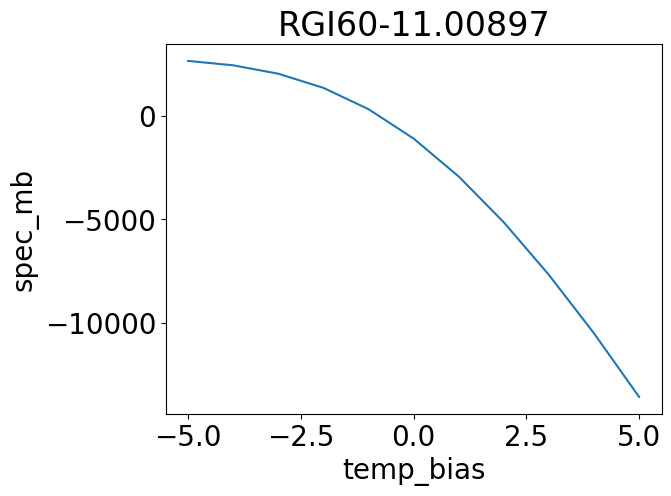

In [32]:
pd_sensitivity_mb = pd.read_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/climate_sensitivity_ref_glaciers_{calib_types[-1]}_cte.csv', index_col = 'Unnamed: 0')
pd_sensitivity_mb_sel = pd_sensitivity_mb.loc[pd_sensitivity_mb['pf_mul'].round(2) == 1]

pd_sensitivity_mb_sel = pd_sensitivity_mb_sel.loc[(pd_sensitivity_mb_sel.mb_type=='mb_monthly')& (pd_sensitivity_mb_sel.sfc_type=='False')]
pd_sensitivity_mb_temp_bias_anomaly = pd_sensitivity_mb_sel.groupby(['temp_bias', 'rgi_id']).mean() - pd_sensitivity_mb_temp_bias.loc[(0,)]
pd_sensitivity_mb_temp_bias_anomaly = pd_sensitivity_mb_temp_bias_anomaly.groupby(['temp_bias']).mean()
pd_sensitivity_mb_temp_bias_anomaly = pd_sensitivity_mb_temp_bias_anomaly.sort_values(by=['CPDD'])


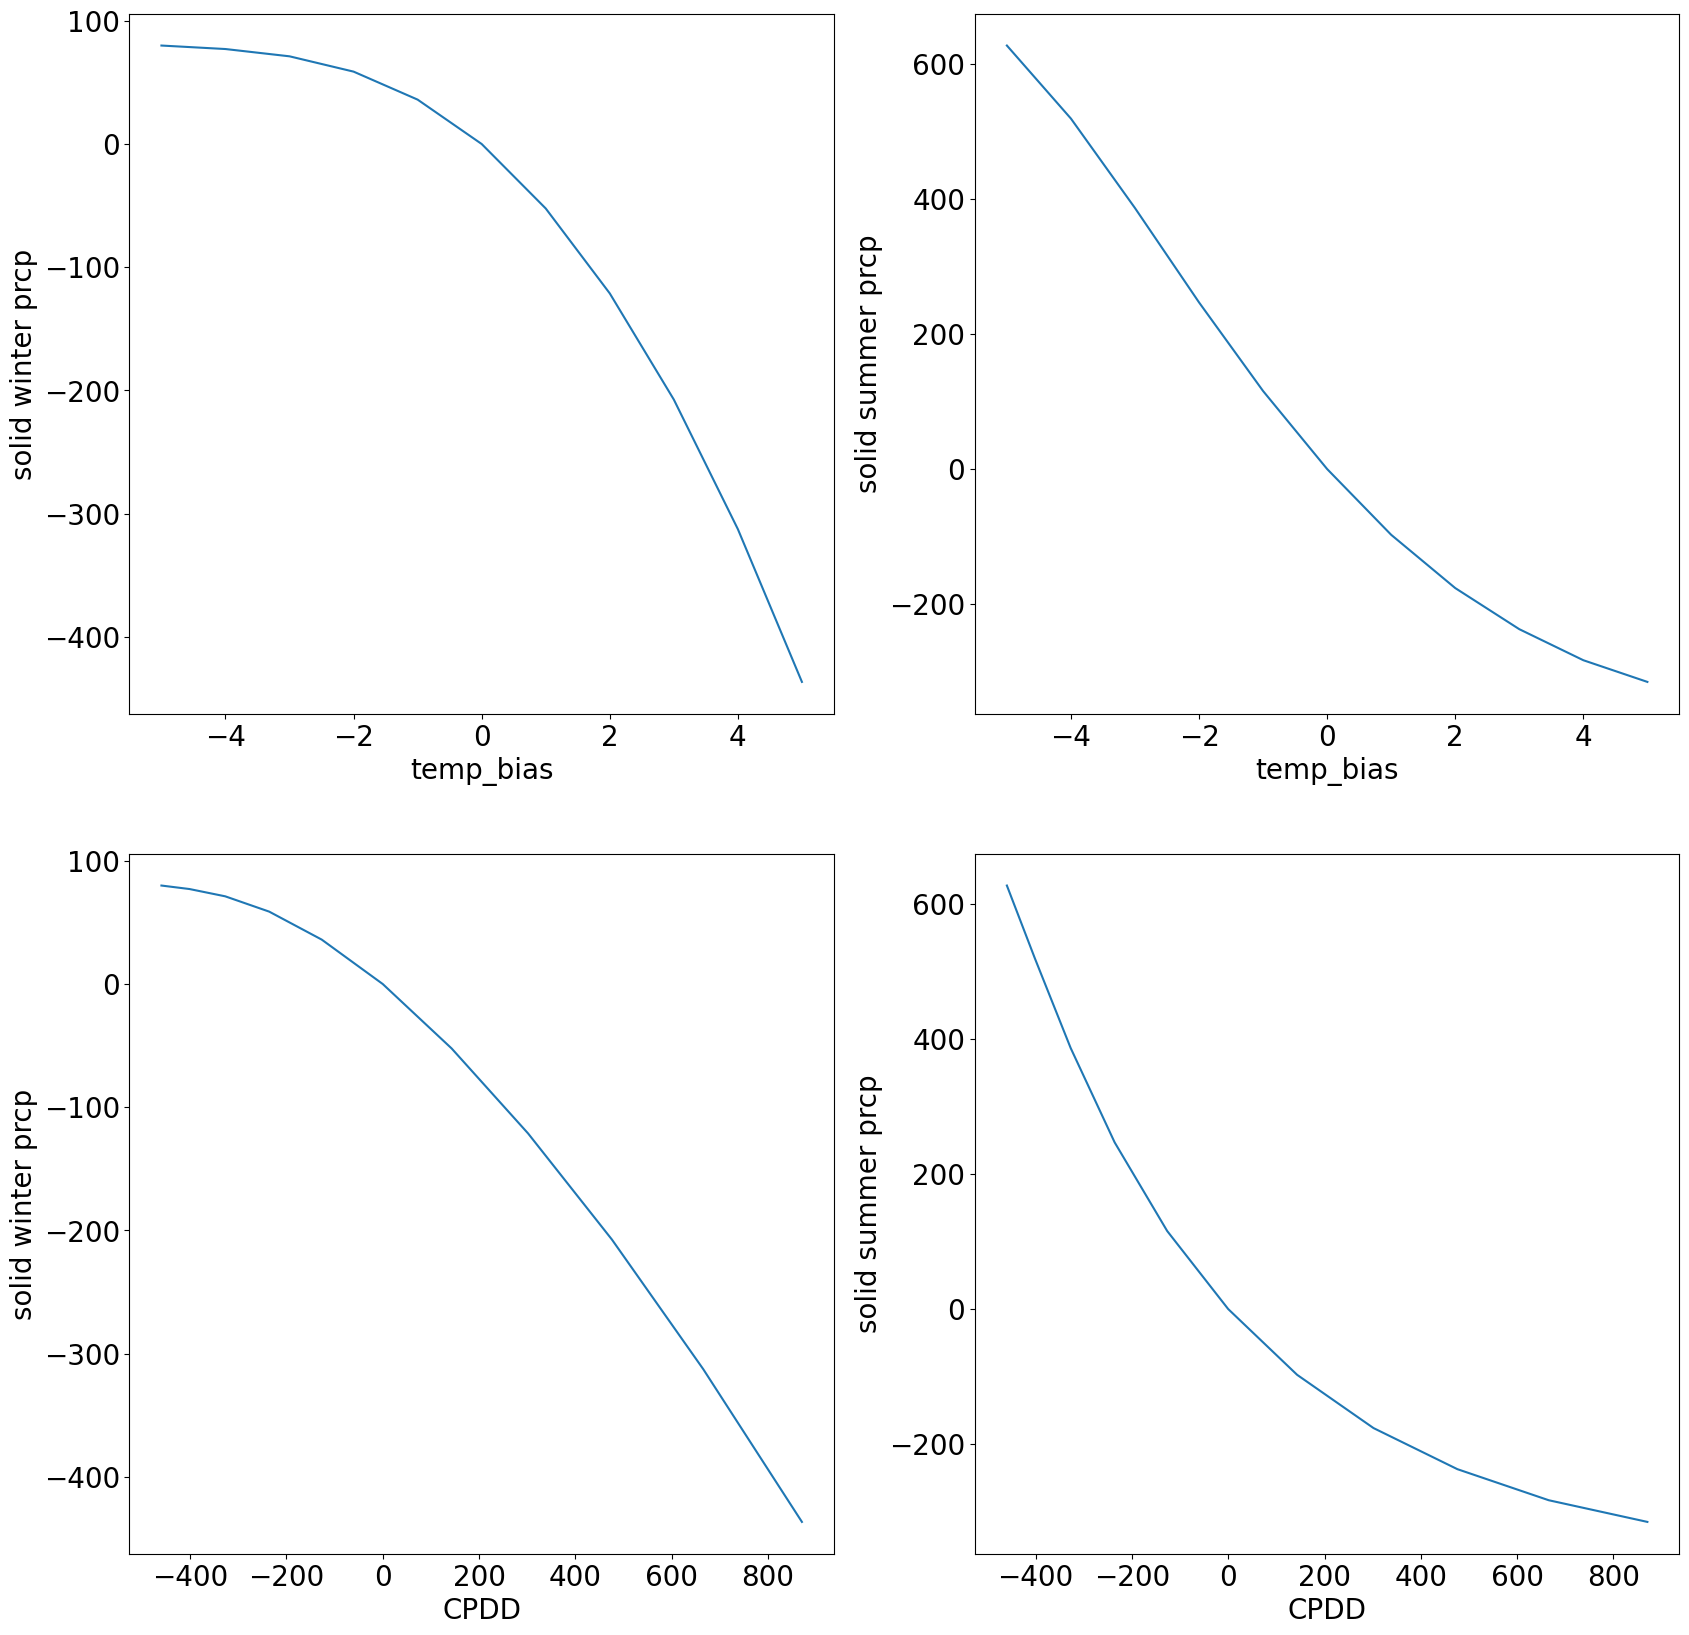

In [69]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
j = 0
for t in ['winter', 'summer']:
    ax = axs[0][j]
    ax.plot(pd_sensitivity_mb_temp_bias_anomaly.index, pd_sensitivity_mb_temp_bias_anomaly[f'solid {t} prcp'], '-')
    ax.set_xlabel('temp_bias')
    ax.set_ylabel(f'solid {t} prcp anomaly')
    j+=1
    
j = 0
for t in ['winter', 'summer']: 
    ax = axs[1][j]
    ax.plot(pd_sensitivity_mb_temp_bias_anomaly['CPDD'], pd_sensitivity_mb_temp_bias_anomaly[f'solid {t} prcp'], '-')
    ax.set_xlabel('CPDD')
    ax.set_ylabel(f'solid {t} prcp anomaly')
    j+=1

Text(0, 0.5, 'solid summer prcp')

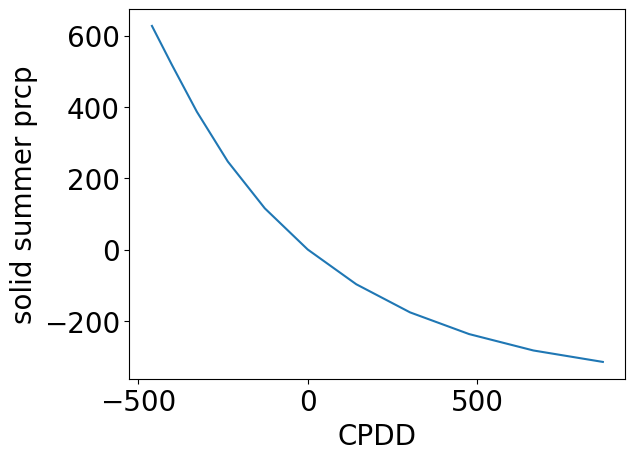

Text(0, 0.5, 'solid winter prcp')

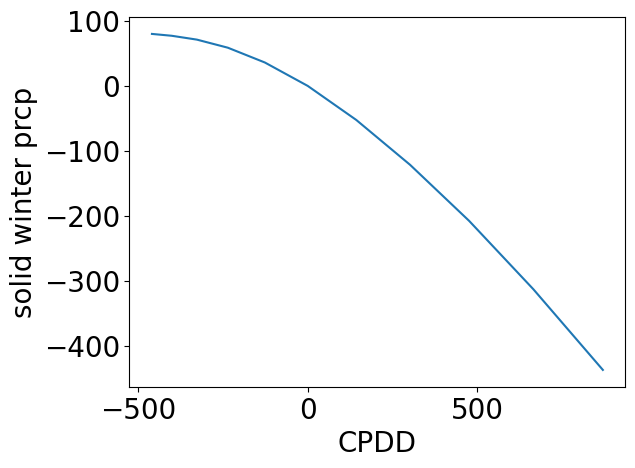

In [61]:
pd_sensitivity_mb_temp_bias_anomaly = pd_sensitivity_mb_temp_bias_anomaly.sort_values(by=['CPDD'])
plt.plot(pd_sensitivity_mb_temp_bias_anomaly['CPDD'], pd_sensitivity_mb_temp_bias_anomaly['solid winter prcp'], '-')
plt.xlabel('CPDD')
plt.ylabel('solid winter prcp')